In [1]:
%reset 

# clears variables in workspace
# note on resetting:
# especially while you're debugging, you want to clear your variables between attempts to solve. Why?
# A) you may have noticed that pyomo doesn't like things being redefined
# more importantly, B) the variables keep their values, so an infeasible solution becomes an infeasible guess. 

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np
sym.init_printing()
from IPython.display import display #for pretty 
import log

#plotting
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
from matplotlib.animation import PillowWriter
%matplotlib inline

gait_name = "ThreeD_StepUp_6"
path = "/Users/Marethe/Documents/GitHub/Masters/2D_gait_generation/Results/"

logger = log.setup_custom_logger(log_level = "INFO", log_path="C:"+path)
logger.info("-------------------------------------------------------")
logger.info(f"Gait name: {gait_name}")
logger.info("3D step up front")
logger.info("-------------------------------------------------------")    


# create the model
m = ConcreteModel()
m.clear()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


[2023-10-15T08:15:30+0200.0016][INFO ][<ipython-input-1-b50b659b477d>] - -------------------------------------------------------
[2023-10-15T08:15:30+0200.0020][INFO ][<ipython-input-1-b50b659b477d>] - Gait name: ThreeD_StepUp_6
[2023-10-15T08:15:30+0200.0020][INFO ][<ipython-input-1-b50b659b477d>] - 3D step up front
[2023-10-15T08:15:30+0200.0024][INFO ][<ipython-input-1-b50b659b477d>] - -------------------------------------------------------


## Variables

In [2]:
#Node Points
N = 40
cN = 3

#Mass
FemurMass = 0.4 #kg
TibiaMass = 0.4 #kg          #CALLEN checking if scaling is the problem    
BodyMass = 1.5 #kg

#Lengths
FemurLength = 0.115 #m
TibiaLength = 0.115 #m
BodyLength = 0.335 #m
BodyWidth = 0.185 #m
LegRadius = 0.06 #m

#Servo Motor Specs
m.Tmax = 6.864655 #Nm, corresponding to a 8V input                 #CALLEN changed this back, maybe high values is wrong
m.Wmax = 8.055366 #rad/s, corresponding to a 8V input

#Time Bounds
tmax = 0.1 #s 
tmin = 0.01 #s
hm = 1 #factor

#Travel distance
m.distance = 0.03 #m
m.vel = 0.1 #m/s
z_clearance = 0.025#m
stair_height=0.05 #m
x_clearance=0.01 #m
dist_from_step = 0.05 #m
step_length =0.05 #m

pi=np.pi

# define the vectors for the contact model
stairs_1=np.zeros(N+1)
stairs_2=np.zeros(N+1)
stairs_3=np.zeros(N+1)
stairs_4=np.zeros(N+1)

for i in range(N+1):
        if i>=1*N/8:
            stairs_1[i]=stair_height
        if i>=5*N/8:
            stairs_2[i]=stair_height

logger.info(f"Nodes = {N}, time variable {tmax}-{tmin}")
# logger.info(f"m.distance = {m.distance}")
logger.info(f"z_clearance = {z_clearance}")
logger.info(f"Stair_height = {stair_height}m, x_clearance = {x_clearance}m, dist_from_step = {dist_from_step}, step_length = {step_length}")

[2023-10-15T08:15:30+0200.0049][INFO ][<ipython-input-2-b53168e23845>] - Nodes = 40, time variable 0.1-0.01
[2023-10-15T08:15:30+0200.0051][INFO ][<ipython-input-2-b53168e23845>] - z_clearance = 0.025
[2023-10-15T08:15:30+0200.0054][INFO ][<ipython-input-2-b53168e23845>] - Stair_height = 0.05m, x_clearance = 0.01m, dist_from_step = 0.05, step_length = 0.05


## Symbolic Equations

In [3]:
# create symbolic variables

# system parameters
g = sym.symbols('g')
m_b,m_f1,m_t1,m_f2,m_t2,m_f3,m_t3,m_f4,m_t4 = sym.symbols(['m_{body}','m_{femur1}','m_{tibia1}','m_{femur2}','m_{tibia2}','m_{femur3}','m_{tibia3}','m_{femur4}','m_{tibia4}']) # mass of links 
r,w_b,l_b,l_f1,l_t1,l_f2,l_t2,l_f3,l_t3,l_f4,l_t4 = sym.symbols(['r_{leg}','w_{body}','l_{body}','l_{femur1}','l_{tibia1}','l_{femur2}','l_{tibia2}','l_{femur3}','l_{tibia3}','l_{femur4}','l_{tibia4}']) # length of links
In_bx,In_by,In_bz,In_fxy,In_txy,In_fz,In_tz = sym.symbols(['In_{bx}','In_{by}','In_{bz}','In_{femurXY}','In_{tibiaXY}','In_{femurZ}','In_{tibiaZ}'])

# generalized coordinates
x,y,z,th_by,th_bx,th_bz,th_h1,th_k1,th_h2,th_k2,th_h3,th_k3,th_h4,th_k4 = sym.symbols(['x','y','z','theta_{bodyy}','theta_{bodyx}','theta_{bodyz}','theta_{hip1}','theta_{knee1}','theta_{hip2}','theta_{knee2}','theta_{hip3}','theta_{knee3}','theta_{hip4}','theta_{knee4}']) #position
dx,dy,dz,dth_by,dth_bx,dth_bz,dth_h1,dth_k1,dth_h2,dth_k2,dth_h3,dth_k3,dth_h4,dth_k4 = sym.symbols(['\dot{x}','\dot{y}','\dot{z}','\dot{\\theta}_{bodyy}','\dot{\\theta}_{bodyx}','\dot{\\theta}_{bodyz}','\dot{\\theta}_{hip1}','\dot{\\theta}_{knee1}','\dot{\\theta}_{hip2}','\dot{\\theta}_{knee2}','\dot{\\theta}_{hip3}','\dot{\\theta}_{knee3}','\dot{\\theta}_{hip4}','\dot{\\theta}_{knee4}']) #velocity
ddx,ddy,ddz,ddth_by,ddth_bx,ddth_bz,ddth_h1,ddth_k1,ddth_h2,ddth_k2,ddth_h3,ddth_k3,ddth_h4,ddth_k4 = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{z}','\ddot{\\theta}_{bodyy}','\ddot{\\theta}_{bodyx}','\ddot{\\theta}_{bodyz}','\ddot{\\theta}_{hip1}','\ddot{\\theta}_{knee1}','\ddot{\\theta}_{hip2}','\ddot{\\theta}_{knee2}','\ddot{\\theta}_{hip3}','\ddot{\\theta}_{knee3}','\ddot{\\theta}_{hip4}','\ddot{\\theta}_{knee4}']) #acceleration

q = sym.Matrix([[x],[y],[z],[th_by],[th_bx],[th_bz],[th_h1],[th_k1],[th_h2],[th_k2],[th_h3],[th_k3],[th_h4],[th_k4]]) #group into matrices
dq = sym.Matrix([[dx],[dy],[dz],[dth_by],[dth_bx],[dth_bz],[dth_h1],[dth_k1],[dth_h2],[dth_k2],[dth_h3],[dth_k3],[dth_h4],[dth_k4]])
ddq = sym.Matrix([[ddx],[ddy],[ddz],[ddth_by],[ddth_bx],[ddth_bz],[ddth_h1],[ddth_k1],[ddth_h2],[ddth_k2],[ddth_h3],[ddth_k3],[ddth_h4],[ddth_k4]])

# forces
tau_h1,tau_k1,tau_h2,tau_k2,tau_h3,tau_k3,tau_h4,tau_k4,GRF1x,GRF1y,GRF1z,GRF2x,GRF2y,GRF2z,GRF3x,GRF3y,GRF3z,GRF4x,GRF4y,GRF4z = sym.symbols(['\\tau_{hip1}','\\tau_{knee1}','\\tau_{hip2}','\\tau_{knee2}','\\tau_{hip3}','\\tau_{knee3}','\\tau_{hip4}','\\tau_{knee4}','G1_x','G1_y','G1_z','G2_x','G2_y','G2_z','G3_x','G3_y','G3_z','G4_x','G4_y','G4_z']) 


In [4]:
#Euler Rotation Theorem
Rx=[[1, 0, 0], [0, sym.cos(th_bx), -sym.sin(th_bx)], [0, sym.sin(th_bx), sym.cos(th_bx)]]
Ry=[[sym.cos(th_by), 0, sym.sin(th_by)], [0, 1, 0], [-sym.sin(th_by), 0, sym.cos(th_by)]]
Rz=[[sym.cos(th_bz), -sym.sin(th_bz), 0], [sym.sin(th_bz), sym.cos(th_bz), 0], [0, 0, 1]]
Rxz=np.matmul(Rx,Rz)
Rxyz=np.matmul(Rxz,Ry)

hip11=[[l_b/2],[w_b/2],[0]]
hip22=[[l_b/2],[-w_b/2],[0]]
hip33=[[-l_b/2],[w_b/2],[0]]
hip44=[[-l_b/2],[-w_b/2],[0]]

femur11=[[l_b/2+l_f1/2*sym.sin(th_h1)],[w_b/2],[-l_f1/2*sym.cos(th_h1)]]
femur22=[[l_b/2+l_f1/2*sym.sin(th_h2)],[-w_b/2],[-l_f1/2*sym.cos(th_h2)]]
femur33=[[-l_b/2+l_f1/2*sym.sin(th_h3)],[w_b/2],[-l_f1/2*sym.cos(th_h3)]]
femur44=[[-l_b/2+l_f1/2*sym.sin(th_h4)],[-w_b/2],[-l_f1/2*sym.cos(th_h4)]]

knee11=[[l_b/2+l_f1*sym.sin(th_h1)],[w_b/2],[-l_f1*sym.cos(th_h1)]]
knee22=[[l_b/2+l_f1*sym.sin(th_h2)],[-w_b/2],[-l_f1*sym.cos(th_h2)]]
knee33=[[-l_b/2+l_f1*sym.sin(th_h3)],[w_b/2],[-l_f1*sym.cos(th_h3)]]
knee44=[[-l_b/2+l_f1*sym.sin(th_h4)],[-w_b/2],[-l_f1*sym.cos(th_h4)]]


#CALLEN: note you are using l_t1 for all, and not l_t2, l_t3 etc (same for l_f). Shouldnt make a difference though


tibia11=[[l_b/2+l_f1*sym.sin(th_h1)+l_t1/2*sym.sin(th_k1)],[w_b/2],[-l_f1*sym.cos(th_h1)-l_t1/2*sym.cos(th_k1)]]
tibia22=[[l_b/2+l_f1*sym.sin(th_h2)+l_t1/2*sym.sin(th_k2)],[-w_b/2],[-l_f1*sym.cos(th_h2)-l_t1/2*sym.cos(th_k2)]]
tibia33=[[-l_b/2+l_f1*sym.sin(th_h3)+l_t1/2*sym.sin(th_k3)],[w_b/2],[-l_f1*sym.cos(th_h3)-l_t1/2*sym.cos(th_k3)]]
tibia44=[[-l_b/2+l_f1*sym.sin(th_h4)+l_t1/2*sym.sin(th_k4)],[-w_b/2],[-l_f1*sym.cos(th_h4)-l_t1/2*sym.cos(th_k4)]]

foot11=[[l_b/2+l_f1*sym.sin(th_h1)+l_t1*sym.sin(th_k1)],[w_b/2],[-l_f1*sym.cos(th_h1)-l_t1*sym.cos(th_k1)]]
foot22=[[l_b/2+l_f1*sym.sin(th_h2)+l_t1*sym.sin(th_k2)],[-w_b/2],[-l_f1*sym.cos(th_h2)-l_t1*sym.cos(th_k2)]]
foot33=[[-l_b/2+l_f1*sym.sin(th_h3)+l_t1*sym.sin(th_k3)],[w_b/2],[-l_f1*sym.cos(th_h3)-l_t1*sym.cos(th_k3)]]
foot44=[[-l_b/2+l_f1*sym.sin(th_h4)+l_t1*sym.sin(th_k4)],[-w_b/2],[-l_f1*sym.cos(th_h4)-l_t1*sym.cos(th_k4)]]


In [5]:
# STEP 1: position vector (COM of each link) 
#using relative angles 

com_b = sym.Matrix([[x],[y],[z]])

com_h1 = sym.Matrix(com_b + np.matmul(Rxyz,hip11))
com_h2 = sym.Matrix(com_b + np.matmul(Rxyz,hip22))
com_h3 = sym.Matrix(com_b + np.matmul(Rxyz,hip33))
com_h4 = sym.Matrix(com_b + np.matmul(Rxyz,hip44))

com_f1 = sym.Matrix(com_b + np.matmul(Rxyz,femur11))
com_f2 = sym.Matrix(com_b + np.matmul(Rxyz,femur22))
com_f3 = sym.Matrix(com_b + np.matmul(Rxyz,femur33))
com_f4 = sym.Matrix(com_b + np.matmul(Rxyz,femur44))

com_k1 = sym.Matrix(com_b + np.matmul(Rxyz,knee11))
com_k2 = sym.Matrix(com_b + np.matmul(Rxyz,knee22))
com_k3 = sym.Matrix(com_b + np.matmul(Rxyz,knee33))
com_k4 = sym.Matrix(com_b + np.matmul(Rxyz,knee44))

com_t1 = sym.Matrix(com_b + np.matmul(Rxyz,tibia11))
com_t2 = sym.Matrix(com_b + np.matmul(Rxyz,tibia22))
com_t3 = sym.Matrix(com_b + np.matmul(Rxyz,tibia33))
com_t4 = sym.Matrix(com_b + np.matmul(Rxyz,tibia44))

foot1_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot11))
foot1x = sym.Matrix([foot1_pos[0]])
foot1y = sym.Matrix([foot1_pos[1]])
foot1z = sym.Matrix([foot1_pos[2]])
foot1z = foot1z[0].simplify()
foot2_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot22))
foot2x = sym.Matrix([foot2_pos[0]])
foot2y = sym.Matrix([foot2_pos[1]])
foot2z = sym.Matrix([foot2_pos[2]])
foot2z = foot2z[0].simplify()
foot3_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot33))
foot3x = sym.Matrix([foot3_pos[0]])
foot3y = sym.Matrix([foot3_pos[1]])
foot3z = sym.Matrix([foot3_pos[2]])
foot3z = foot3z[0].simplify()
foot4_pos= sym.Matrix(com_b + np.matmul(Rxyz,foot44))
foot4x = sym.Matrix([foot4_pos[0]])
foot4y = sym.Matrix([foot4_pos[1]])
foot4z = sym.Matrix([foot4_pos[2]])
foot4z = foot4z[0].simplify()


In [6]:
# STEP 2: generate expressions for the system space velocities
v_b = com_b.jacobian(q)*dq

v_f1 = com_f1.jacobian(q)*dq
v_t1 = com_t1.jacobian(q)*dq

v_f2 = com_f2.jacobian(q)*dq
v_t2 = com_t2.jacobian(q)*dq

v_f3 = com_f3.jacobian(q)*dq
v_t3 = com_t3.jacobian(q)*dq

v_f4 = com_f4.jacobian(q)*dq
v_t4 = com_t4.jacobian(q)*dq

foot1dx = foot1x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dx = foot1dx[0].simplify()
foot1dy = foot1y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dy = foot1dy[0].simplify()

foot2dx = foot2x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dx = foot2dx[0].simplify()
foot2dy = foot2y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dy = foot2dy[0].simplify()

foot3dx = foot3x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot3dx = foot3dx[0].simplify()
foot3dy = foot3y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot3dy = foot3dy[0].simplify()

foot4dx = foot4x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot4dx = foot4dx[0].simplify()
foot4dy = foot4y.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot4dy = foot4dy[0].simplify()

foot1x = foot1x[0].simplify()
foot2x = foot2x[0].simplify()
foot3x = foot3x[0].simplify()
foot4x = foot4x[0].simplify()

In [7]:
# STEP 3: generate expressions for the kinetic and potential energy

#Stacy Shield's method
# T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
# V = sym.Matrix([m1*g*y1 + m2*g*y2])

#Callen Fisher's method, better for bigger problems.
M_b = sym.Matrix([[m_b,m_b,m_b]])
M_f1 = sym.Matrix([[m_f1,m_f1,m_f1]])
M_t1 = sym.Matrix([[m_t1,m_t1,m_t1]])
M_f2 = sym.Matrix([[m_f2,m_f2,m_f2]])
M_t2 = sym.Matrix([[m_t2,m_t2,m_t2]])
M_f3 = sym.Matrix([[m_f3,m_f3,m_f3]])
M_t3 = sym.Matrix([[m_t3,m_t3,m_t3]])
M_f4 = sym.Matrix([[m_f4,m_f4,m_f4]])
M_t4 = sym.Matrix([[m_t4,m_t4,m_t4]])

I_b=sym.Matrix([[In_bx,In_by,In_bz]])
I_f=sym.Matrix([[In_fxy,In_fxy,In_fz]])
I_t=sym.Matrix([[In_txy,In_txy,In_tz]])

W_b=sym.Matrix([[dth_bx],[dth_by],[dth_bz]])   
W_h1=sym.Matrix([[dth_bx],[dth_h1+dth_by],[dth_bz]])
W_k1=sym.Matrix([[dth_bx],[dth_k1+dth_by],[dth_bz]])
W_h2=sym.Matrix([[dth_bx],[dth_h2+dth_by],[dth_bz]])
W_k2=sym.Matrix([[dth_bx],[dth_k2+dth_by],[dth_bz]])
W_h3=sym.Matrix([[dth_bx],[dth_h3+dth_by],[dth_bz]])
W_k3=sym.Matrix([[dth_bx],[dth_k3+dth_by],[dth_bz]])
W_h4=sym.Matrix([[dth_bx],[dth_h4+dth_by],[dth_bz]])
W_k4=sym.Matrix([[dth_bx],[dth_k4+dth_by],[dth_bz]])

# linear kinetic energy:
Tl = 0.5*M_b*sym.matrix_multiply_elementwise(v_b,v_b) + 0.5*M_f1*sym.matrix_multiply_elementwise(v_f1,v_f1) + 0.5*M_t1*sym.matrix_multiply_elementwise(v_t1,v_t1) + 0.5*M_f2*sym.matrix_multiply_elementwise(v_f2,v_f2) + 0.5*M_t2*sym.matrix_multiply_elementwise(v_t2,v_t2) + 0.5*M_f3*sym.matrix_multiply_elementwise(v_f3,v_f3) + 0.5*M_t3*sym.matrix_multiply_elementwise(v_t3,v_t3) + 0.5*M_f4*sym.matrix_multiply_elementwise(v_f4,v_f4) + 0.5*M_t4*sym.matrix_multiply_elementwise(v_t4,v_t4)
# angular kinetic energy:
Tw =  0.5*I_b*sym.matrix_multiply_elementwise(W_b,W_b) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h1,W_h1) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k1,W_k1) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h2,W_h2) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k2,W_k2) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h3,W_h3) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k3,W_k3) + 0.5*I_f*sym.matrix_multiply_elementwise(W_h4,W_h4) + 0.5*I_t*sym.matrix_multiply_elementwise(W_k4,W_k4)
#this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([Tl[0]])+sym.Matrix([Tw[0]])
# potential energy
V = m_b*g*com_b[2] + m_f1*g*com_f1[2] + m_t1*g*com_t1[2] + m_f2*g*com_f2[2] + m_t2*g*com_t2[2] + m_f3*g*com_f3[2] + m_t3*g*com_t3[2] + m_f4*g*com_f4[2] + m_t4*g*com_t4[2]   


In [8]:
#Use the manipulator equation to calculate the EoM
#EOM=Mddq+Cdq+G-Q-J.'*GRF ---> Callen's method

M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

#C  = sym.zeros(len(q),len(q))  
#for i in range(len(q)):                                             
#    for j in range(len(q)):
#        for n in range(len(q)):
#            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)  
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);  

Q = sym.zeros(len(q),1)
Q[0]=0                 #x
Q[1]=0                 #y
Q[2]=0                 #z
Q[3]=0    #th x
Q[4]=-tau_h1-tau_h2-tau_h3-tau_h4-tau_k1-tau_k2-tau_k3-tau_k4                           #th y
Q[5]=0                          #th z
Q[6]=tau_h1              #th hip 1
Q[7]=tau_k1                     #th knee 1
Q[8]=tau_h2              #th hip 2
Q[9]=tau_k2                     #th knee 2
Q[10]=tau_h3              #th hip 3
Q[11]=tau_k3                     #th knee 3
Q[12]=tau_h4              #th hip 4
Q[13]=tau_k4                    #th knee 4

J1=foot1_pos.jacobian(q)
GRF_1 = J1.transpose()*sym.Matrix([[GRF1x],[GRF1y],[GRF1z]]) 

J2=foot2_pos.jacobian(q)
GRF_2 = J2.transpose()*sym.Matrix([[GRF2x],[GRF2y],[GRF2z]])

J3=foot3_pos.jacobian(q)
GRF_3 = J3.transpose()*sym.Matrix([[GRF3x],[GRF3y],[GRF3z]]) 

J4=foot4_pos.jacobian(q)
GRF_4 = J4.transpose()*sym.Matrix([[GRF4x],[GRF4y],[GRF4z]])

EOM=M*ddq+G-Q-GRF_1-GRF_2-GRF_3-GRF_4#C*dq+

logger.info("C matrix removed")

EOMs = sym.zeros(len(q),1)
EOMcounter = 0
print(f"EOM simplification starts")
for j in range(len(q)):
    EOMs[j] = EOM[j]#.simplify()  #--> Helps to make simulation faster for bigger problems
#     print(f"EOM loop counter: {j}")
    EOMcounter = EOMcounter + 1


[2023-10-15T08:17:34+0200.0043][INFO ][<ipython-input-8-ec401730e8e9>] - C matrix removed


EOM simplification starts


## Pyomo Stuff Starts

In [9]:
# Lambdify

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,m_b,m_f1,m_t1,m_f2,m_t2,m_f3,m_t3,m_f4,m_t4,
            l_b,l_f1,l_t1,l_f2,l_t2,l_f3,l_t3,l_f4,l_t4,w_b,r,
            In_bx,In_by,In_bz,In_fxy,In_txy,In_fz,In_tz,
            x,y,z,th_bx,th_by,th_bz,th_h1,th_k1,th_h2,th_k2,th_h3,th_k3,th_h4,th_k4,
            dx,dy,dz,dth_bx,dth_by,dth_bz,dth_h1,dth_k1,dth_h2,dth_k2,dth_h3,dth_k3,dth_h4,dth_k4,
            ddx,ddy,ddz,ddth_bx,ddth_by,ddth_bz,ddth_h1,ddth_k1,ddth_h2,ddth_k2,ddth_h3,ddth_k3,ddth_h4,ddth_k4,
            tau_h1,tau_k1,tau_h2,tau_k2,tau_h3,tau_k3,tau_h4,tau_k4,
            GRF1x,GRF1y,GRF1z,GRF2x,GRF2y,GRF2z,GRF3x,GRF3y,GRF3z,GRF4x,GRF4y,GRF4z]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_z = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_th_bx = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_th_by = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_th_bz = sym.lambdify(sym_list,EOMs[5],modules = [func_map])
lambEOM_th_h1 = sym.lambdify(sym_list,EOMs[6],modules = [func_map])
lambEOM_th_k1 = sym.lambdify(sym_list,EOMs[7],modules = [func_map])
lambEOM_th_h2 = sym.lambdify(sym_list,EOMs[8],modules = [func_map])
lambEOM_th_k2 = sym.lambdify(sym_list,EOMs[9],modules = [func_map])
lambEOM_th_h3 = sym.lambdify(sym_list,EOMs[10],modules = [func_map])
lambEOM_th_k3 = sym.lambdify(sym_list,EOMs[11],modules = [func_map])
lambEOM_th_h4 = sym.lambdify(sym_list,EOMs[12],modules = [func_map])
lambEOM_th_k4 = sym.lambdify(sym_list,EOMs[13],modules = [func_map])

lamb_foot1x = sym.lambdify(sym_list,foot1x,modules = [func_map])
lamb_foot1z = sym.lambdify(sym_list,foot1z,modules = [func_map])
lamb_foot1dx = sym.lambdify(sym_list,foot1dx,modules = [func_map])
lamb_foot1dy = sym.lambdify(sym_list,foot1dy,modules = [func_map])

lamb_foot2x = sym.lambdify(sym_list,foot2x,modules = [func_map])
lamb_foot2z = sym.lambdify(sym_list,foot2z,modules = [func_map])
lamb_foot2dx = sym.lambdify(sym_list,foot2dx,modules = [func_map])
lamb_foot2dy = sym.lambdify(sym_list,foot2dy,modules = [func_map])

lamb_foot3x = sym.lambdify(sym_list,foot3x,modules = [func_map])
lamb_foot3z = sym.lambdify(sym_list,foot3z,modules = [func_map])
lamb_foot3dx = sym.lambdify(sym_list,foot3dx,modules = [func_map])
lamb_foot3dy = sym.lambdify(sym_list,foot3dy,modules = [func_map])

lamb_foot4x = sym.lambdify(sym_list,foot4x,modules = [func_map])
lamb_foot4z = sym.lambdify(sym_list,foot4z,modules = [func_map])
lamb_foot4dx = sym.lambdify(sym_list,foot4dx,modules = [func_map])
lamb_foot4dy = sym.lambdify(sym_list,foot4dy,modules = [func_map])


In [10]:
# ConcreteModel SETS -------------------------------------------------------------------------------
m.N = RangeSet(N)
m.cN = RangeSet(cN)

# sets can have multidimensional indices
# (probably a little gratuitous for such a simple model, but thought I'd show you anyway)
links = [('body',1),('bodyWidth',1),('legRadius',1),('femur',1),('tibia',1),('femur',2),('tibia',2),('femur',3),('tibia',3),('femur',4),('tibia',4)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','z','theta_bx','theta_by','theta_bz','theta_h1','theta_k1','theta_h2','theta_k2','theta_h3','theta_k3','theta_h4','theta_k4']
m.DOF = Set(initialize = DOFs) # the coordinates for each link

# system coordinates
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N, bounds = (0,10))

m.h = Var(m.N, bounds =(tmin,tmax))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]


In [11]:
# Substituting variables into ConcreteModel-----------------------------------------------------------------------------------------
m.g = Param(initialize = 9.81) 

# mass of links
def get_m(n, lb, ln):
    if lb == 'femur':
        return FemurMass
    elif lb == 'body':
        return BodyMass
    else: return TibiaMass
m.m = Param(m.L, initialize = get_m)

mbody = sum(m.m[l] for l in links)
mBW = mbody*m.g.value
# m.m.pprint()
print(f'total body mass: {mbody}')
print(f'total body weight: {mBW}')

# length of links
def get_len(n, lb, ln):
    if lb == 'femur':
        return FemurLength
    elif lb == 'body':
        return BodyLength
    elif lb == 'bodyWidth':
        return BodyWidth
    elif lb == 'legRadius':
        return LegRadius
    else: return TibiaLength
m.l = Param(m.L, initialize = get_len) 
# m.l.pprint()

#Inertia
def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.l[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

#Body inertia
m.inbx = 1/12*m.m[('body',1)]*m.l[('body',1)]**2
m.inby = 1/12*m.m[('body',1)]*m.l[('bodyWidth',1)]**2
m.inbz = 1/12*m.m[('body',1)]*(m.l[('body',1)]**2+m.l[('bodyWidth',1)]**2)
m.infxy = m.m[('femur',1)]*m.l[('femur',1)]**2/12
m.intxy = m.m[('tibia',1)]*m.l[('tibia',1)]**2/12
m.infz = m.m[('femur',1)]*m.l[('legRadius',1)]**2/2
m.intz = m.m[('tibia',1)]*m.l[('legRadius',1)]**2/2
    

total body mass: 5.500000000000001
total body weight: 53.95500000000001


In [12]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)


In [13]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)


In [14]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X','Y','Z','THETAbx','THETAby','THETAbz', 'THETAh1','THETAk1', 'THETAh2','THETAk2', 'THETAh3','THETAk3','THETAh4','THETAk4']
m.WDOF = Set(initialize=WDOFs) #change the coordinates

#CALLEN: double check the values below, I increased to 600 to give the optimizer some more wiggle room to find a sol 

m.GRF1 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*mBW
m.GRF2 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*m_robot*g
m.GRF3 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*m_robot*g
m.GRF4 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,600)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)


In [15]:
# SLACK VARIABLES
#CALLEN hopefully a bunch of these will not be required 


m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_2      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_3  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_3  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_3      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_4  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_4  = Var(m.N, m.cN, bounds = (0.0,None))  
m.gamma_4      = Var(m.N, m.cN, bounds = (0.0,None)) 


In [16]:
# # CONTACTS
# # Leg 1 --------------------------------------------------------------------------------------------------------------

# #CALLEN allows foot to make and break contact 
def def_a_contact_1(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_1[n,c] == lamb_foot1z(*var_list)-stairs_1[n]
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)

def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF1[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)

#condition
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_a_contact_2(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_2[n,c] == lamb_foot2z(*var_list)-stairs_2[n]
m.def_a_contact_2 = Constraint(m.N, m.cN, rule = def_a_contact_2)

def def_b_contact_2(m,n,c):   
    return m.b_contact_2[n,c] == m.GRF2[n,c,'Z','ps']
m.def_b_contact_2 = Constraint(m.N, m.cN, rule = def_b_contact_2)

#condition
def def_contact_2_pr(m,n):
    a_contact_2_pr = m.a_contact_2[n,1] + m.a_contact_2[n,2] + m.a_contact_2[n,3] 
    b_contact_2_pr = m.b_contact_2[n,1] + m.b_contact_2[n,2] + m.b_contact_2[n,3]  
    return a_contact_2_pr*b_contact_2_pr <= m.eps
m.def_contact_2_pr = Constraint(m.N, rule = def_contact_2_pr)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_a_contact_3(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_3[n,c] == lamb_foot3z(*var_list)-stairs_3[n]
m.def_a_contact_3 = Constraint(m.N, m.cN, rule = def_a_contact_3)

def def_b_contact_3(m,n,c):   
    return m.b_contact_3[n,c] == m.GRF3[n,c,'Z','ps']
m.def_b_contact_3 = Constraint(m.N, m.cN, rule = def_b_contact_3)

#condition
def def_contact_3_pr(m,n):
    a_contact_3_pr = m.a_contact_3[n,1] + m.a_contact_3[n,2] + m.a_contact_3[n,3] 
    b_contact_3_pr = m.b_contact_3[n,1] + m.b_contact_3[n,2] + m.b_contact_3[n,3]  
    return a_contact_3_pr*b_contact_3_pr <= m.eps
m.def_contact_3_pr = Constraint(m.N, rule = def_contact_3_pr)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_a_contact_4(m,n,c):   
        var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        return m.a_contact_4[n,c] == lamb_foot4z(*var_list)-stairs_4[n]
m.def_a_contact_4 = Constraint(m.N, m.cN, rule = def_a_contact_4)

def def_b_contact_4(m,n,c):   
    return m.b_contact_4[n,c] == m.GRF4[n,c,'Z','ps']
m.def_b_contact_4 = Constraint(m.N, m.cN, rule = def_b_contact_4)

#condition
def def_contact_4_pr(m,n):
    a_contact_4_pr = m.a_contact_4[n,1] + m.a_contact_4[n,2] + m.a_contact_4[n,3] 
    b_contact_4_pr = m.b_contact_4[n,1] + m.b_contact_4[n,2] + m.b_contact_4[n,3]  
    return a_contact_4_pr*b_contact_4_pr <= m.eps
m.def_contact_4_pr = Constraint(m.N, rule = def_contact_4_pr)


In [17]:
# FRICTION CONE
# Leg 1 -------------------------------------------------------------------------------------------------------------
def def_a_friction_1(m,n,c):   
    return (m.mu*m.GRF1[n,c,'Z','ps'])**2 >= ((m.GRF1[n,c,'X','ps'] + m.GRF1[n,c,'X','ng'])**2+(m.GRF1[n,c,'Y','ps'] + m.GRF1[n,c,'Y','ng'])**2)
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_a_friction_2(m,n,c):   
    return  (m.mu*m.GRF2[n,c,'Z','ps'])**2 >= ((m.GRF2[n,c,'X','ps'] + m.GRF2[n,c,'X','ng'])**2+(m.GRF2[n,c,'Y','ps'] + m.GRF2[n,c,'Y','ng'])**2)
m.def_a_friction_2 = Constraint(m.N, m.cN, rule = def_a_friction_2)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_a_friction_3(m,n,c):   
    return (m.mu*m.GRF3[n,c,'Z','ps'])**2 >= ((m.GRF3[n,c,'X','ps'] + m.GRF3[n,c,'X','ng'])**2+(m.GRF3[n,c,'Y','ps'] + m.GRF3[n,c,'Y','ng'])**2)
m.def_a_friction_3 = Constraint(m.N, m.cN, rule = def_a_friction_3)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_a_friction_4(m,n,c):   
    return (m.mu*m.GRF4[n,c,'Z','ps'])**2 >= ((m.GRF4[n,c,'X','ps'] + m.GRF4[n,c,'X','ng'])**2+(m.GRF4[n,c,'Y','ps'] + m.GRF4[n,c,'Y','ng'])**2)
m.def_a_friction_4 = Constraint(m.N, m.cN, rule = def_a_friction_4)


In [18]:
def def_F1_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF1[n,c,'Z','ps']*lamb_foot1dx(*var_list)*lamb_foot1dx(*var_list)<= m.eps/1
m.def_F1_x = Constraint(m.N, m.cN, rule = def_F1_x)
def def_F1_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF1[n,c,'Z','ps']*lamb_foot1dy(*var_list)*lamb_foot1dy(*var_list)<= m.eps/1
m.def_F1_y = Constraint(m.N, m.cN, rule = def_F1_y)

def def_F2_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF2[n,c,'Z','ps']*lamb_foot2dx(*var_list)*lamb_foot2dx(*var_list)<= m.eps/1
m.def_F2_x = Constraint(m.N, m.cN, rule = def_F2_x)
def def_F2_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF2[n,c,'Z','ps']*lamb_foot2dy(*var_list)*lamb_foot2dy(*var_list)<= m.eps/1
m.def_F2_y = Constraint(m.N, m.cN, rule = def_F2_y)

def def_F3_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF3[n,c,'Z','ps']*lamb_foot3dx(*var_list)*lamb_foot3dx(*var_list)<= m.eps/1
m.def_F3_x = Constraint(m.N, m.cN, rule = def_F3_x)
def def_F3_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF3[n,c,'Z','ps']*lamb_foot3dy(*var_list)*lamb_foot3dy(*var_list)<= m.eps/1
m.def_F3_y = Constraint(m.N, m.cN, rule = def_F3_y)

def def_F4_x(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF4[n,c,'Z','ps']*lamb_foot4dx(*var_list)*lamb_foot4dx(*var_list)<= m.eps/1
m.def_F4_x = Constraint(m.N, m.cN, rule = def_F4_x)
def def_F4_y(m,n,c):   
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return  m.GRF4[n,c,'Z','ps']*lamb_foot4dy(*var_list)*lamb_foot4dy(*var_list)<= m.eps/1
m.def_F4_y = Constraint(m.N, m.cN, rule = def_F4_y)

logger.info(f"Anti-slip: m.GRF4[n,c,'Z','ps']*lamb_foot4dy(*var_list)*lamb_foot4dy(*var_list)<= m.eps/1")

[2023-10-15T08:17:52+0200.0890][INFO ][<ipython-input-18-84e92395580f>] - Anti-slip: m.GRF4[n,c,'Z','ps']*lamb_foot4dy(*var_list)*lamb_foot4dy(*var_list)<= m.eps/1


In [19]:
m.tau_h1 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_1
m.tau_k1 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_1
m.tau_h2 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_2
m.tau_k2 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_2
m.tau_h3 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_3
m.tau_k3 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_3
m.tau_h4 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at hip_4
m.tau_k4 = Var(m.N, bounds = (-m.Tmax,m.Tmax)) # actuator torque at knee_4

# Leg 1 --------------------------------------------------------------------------------------------------------------
def def_hip1_motor_model_p(m,n):
    return  m.tau_h1[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h1']-m.dq0[n,'theta_by'])
m.def_hip1_motor_model_p = Constraint(m.N, rule = def_hip1_motor_model_p)
def def_hip1_motor_model_n(m,n):
    return  m.tau_h1[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h1']-m.dq0[n,'theta_by'])
m.def_hip1_motor_model_n = Constraint(m.N, rule = def_hip1_motor_model_n)

def def_knee1_motor_model_p(m,n):
    return  m.tau_k1[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k1']-m.dq0[n,'theta_h1'])
m.def_knee1_motor_model_p = Constraint(m.N, rule = def_knee1_motor_model_p)
def def_knee1_motor_model_n(m,n):
    return  m.tau_k1[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k1']-m.dq0[n,'theta_h1'])
m.def_knee1_motor_model_n = Constraint(m.N, rule = def_knee1_motor_model_n)

# Leg 2 --------------------------------------------------------------------------------------------------------------
def def_hip2_motor_model_p(m,n):
    return  m.tau_h2[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h2']-m.dq0[n,'theta_by'])
m.def_hip2_motor_model_p = Constraint(m.N, rule = def_hip2_motor_model_p)
def def_hip2_motor_model_n(m,n):
    return  m.tau_h2[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h2']-m.dq0[n,'theta_by'])
m.def_hip2_motor_model_n = Constraint(m.N, rule = def_hip2_motor_model_n)

def def_knee2_motor_model_p(m,n):
    return  m.tau_k2[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k2']-m.dq0[n,'theta_h2'])
m.def_knee2_motor_model_p = Constraint(m.N, rule = def_knee2_motor_model_p)
def def_knee2_motor_model_n(m,n):
    return  m.tau_k2[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k2']-m.dq0[n,'theta_h2'])
m.def_knee2_motor_model_n = Constraint(m.N, rule = def_knee2_motor_model_n)

# Leg 3 --------------------------------------------------------------------------------------------------------------
def def_hip3_motor_model_p(m,n):
    return  m.tau_h3[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h3']-m.dq0[n,'theta_by'])
m.def_hip3_motor_model_p = Constraint(m.N, rule = def_hip3_motor_model_p)
def def_hip3_motor_model_n(m,n):
    return  m.tau_h3[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h3']-m.dq0[n,'theta_by'])
m.def_hip3_motor_model_n = Constraint(m.N, rule = def_hip3_motor_model_n)

def def_knee3_motor_model_p(m,n):
    return  m.tau_k3[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k3']-m.dq0[n,'theta_h3'])
m.def_knee3_motor_model_p = Constraint(m.N, rule = def_knee3_motor_model_p)
def def_knee3_motor_model_n(m,n):
    return  m.tau_k3[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k3']-m.dq0[n,'theta_h3'])
m.def_knee3_motor_model_n = Constraint(m.N, rule = def_knee3_motor_model_n)

# Leg 4 --------------------------------------------------------------------------------------------------------------
def def_hip4_motor_model_p(m,n):
    return  m.tau_h4[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h4']-m.dq0[n,'theta_by'])
m.def_hip4_motor_model_p = Constraint(m.N, rule = def_hip4_motor_model_p)
def def_hip4_motor_model_n(m,n):
    return  m.tau_h4[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_h4']-m.dq0[n,'theta_by'])
m.def_hip4_motor_model_n = Constraint(m.N, rule = def_hip4_motor_model_n)

def def_knee4_motor_model_p(m,n):
    return  m.tau_k4[n] <= m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k4']-m.dq0[n,'theta_h4'])
m.def_knee4_motor_model_p = Constraint(m.N, rule = def_knee4_motor_model_p)
def def_knee4_motor_model_n(m,n):
    return  m.tau_k4[n] >= -m.Tmax-m.Tmax/m.Wmax*(m.dq0[n,'theta_k4']-m.dq0[n,'theta_h4'])
m.def_knee4_motor_model_n = Constraint(m.N, rule = def_knee4_motor_model_n)


In [20]:
def EOM_x(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_y(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, m.cN, rule = EOM_y)

def EOM_z(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_z(*var_list) == 0
m.EOM_z = Constraint(m.N, m.cN, rule = EOM_z)

def EOM_th_bx(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_bx(*var_list) == 0
m.EOM_th_bx = Constraint(m.N, m.cN, rule = EOM_th_bx)

def EOM_th_by(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_by(*var_list) == 0
m.EOM_th_by = Constraint(m.N, m.cN, rule = EOM_th_by)

def EOM_th_bz(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_bz(*var_list) == 0
m.EOM_th_bz = Constraint(m.N, m.cN, rule = EOM_th_bz)

def EOM_th_h1(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h1(*var_list) == 0
m.EOM_th_h1 = Constraint(m.N, m.cN, rule = EOM_th_h1)

def EOM_th_k1(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k1(*var_list) == 0
m.EOM_th_k1 = Constraint(m.N, m.cN, rule = EOM_th_k1)

def EOM_th_h2(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h2(*var_list) == 0
m.EOM_th_h2 = Constraint(m.N, m.cN, rule = EOM_th_h2)

def EOM_th_k2(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k2(*var_list) == 0
m.EOM_th_k2 = Constraint(m.N, m.cN, rule = EOM_th_k2)

def EOM_th_h3(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h3(*var_list) == 0
m.EOM_th_h3 = Constraint(m.N, m.cN, rule = EOM_th_h3)

def EOM_th_k3(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k3(*var_list) == 0
m.EOM_th_k3 = Constraint(m.N, m.cN, rule = EOM_th_k3)

def EOM_th_h4(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_h4(*var_list) == 0
m.EOM_th_h4 = Constraint(m.N, m.cN, rule = EOM_th_h4)

def EOM_th_k4(m,n,c):
    Gx1_in = (m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gy1_in = (m.GRF1[n,c,'Y','ps']-m.GRF1[n,c,'Y','ng'])
    Gx2_in = (m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gy2_in = (m.GRF2[n,c,'Y','ps']-m.GRF2[n,c,'Y','ng'])
    Gx3_in = (m.GRF3[n,c,'X','ps']-m.GRF3[n,c,'X','ng'])
    Gy3_in = (m.GRF3[n,c,'Y','ps']-m.GRF3[n,c,'Y','ng'])
    Gx4_in = (m.GRF4[n,c,'X','ps']-m.GRF4[n,c,'X','ng'])
    Gy4_in = (m.GRF4[n,c,'Y','ps']-m.GRF4[n,c,'Y','ng'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    m.tau_h1[n],m.tau_k1[n],m.tau_h2[n],m.tau_k2[n],m.tau_h3[n],m.tau_k3[n],m.tau_h4[n],m.tau_k4[n],
                    Gx1_in,Gy1_in,m.GRF1[n,c,'Z','ps'],Gx2_in,Gy2_in,m.GRF2[n,c,'Z','ps'],Gx3_in,Gy3_in,m.GRF3[n,c,'Z','ps'],Gx4_in,Gy4_in,m.GRF4[n,c,'Z','ps']]
    return lambEOM_th_k4(*var_list) == 0
m.EOM_th_k4 = Constraint(m.N, m.cN, rule = EOM_th_k4)


In [21]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setyBounds(m,n): 
    return (-1.0, m.q0[n,'y'], 1.0)    
m.setyBounds = Constraint(m.N, rule=setyBounds)
def setzBounds(m,n):
    return (0, m.q0[n,'z'], 5)    
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setth_bx_Bounds(m,n):
    return (-0.785, m.q0[n,'theta_bx'], 0.785)
m.setth_bx_Bounds = Constraint(m.N, rule=setth_bx_Bounds)
def setth_by_Bounds(m,n):
    return (-0.785, m.q0[n,'theta_by'], 0.785)
m.setth_by_Bounds = Constraint(m.N, rule=setth_by_Bounds)
def setth_bz_Bounds(m,n):
    return (-0.785, m.q0[n,'theta_bz'], 0.785)
m.setth_bz_Bounds = Constraint(m.N, rule=setth_bz_Bounds)

def setth_h1_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h1'],1.5)
m.setth_h1_Bounds = Constraint(m.N, rule=setth_h1_Bounds)
def setth_k1_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k1'], 1.5)
m.setth_k1_Bounds = Constraint(m.N, rule=setth_k1_Bounds)
def setth_h2_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h2'],1.5)
m.setth_h2_Bounds = Constraint(m.N, rule=setth_h2_Bounds)
def setth_k2_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k2'],1.5)
m.setth_k2_Bounds = Constraint(m.N, rule=setth_k2_Bounds)
def setth_h3_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h3'], 1.5)
m.setth_h3_Bounds = Constraint(m.N, rule=setth_h3_Bounds)
def setth_k3_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k3'], 1.5)
m.setth_k3_Bounds = Constraint(m.N, rule=setth_k3_Bounds)
def setth_h4_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_h4'], 1.5)
m.setth_h4_Bounds = Constraint(m.N, rule=setth_h4_Bounds)
def setth_k4_Bounds(m,n):
    return (-1.5, m.q0[n,'theta_k4'], 1.5)
m.setth_k4_Bounds = Constraint(m.N, rule=setth_k4_Bounds)

def setdxBounds(m,n):
    return (-10, m.dq0[n,'x'],10.0)   
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdyBounds(m,n):
    return (-10, m.dq0[n,'y'],10)
m.setdyBounds = Constraint(m.N, rule=setdyBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
m.setdzBounds = Constraint(m.N, rule=setdzBounds)
def setdth_bx_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_bx'],4*m.Wmax)
m.setdth_bx_Bounds = Constraint(m.N, rule=setdth_bx_Bounds)
def setdth_by_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_by'],4*m.Wmax)
m.setdth_by_Bounds = Constraint(m.N, rule=setdth_by_Bounds)
def setdth_bz_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_bz'],4*m.Wmax)
m.setdth_bz_Bounds = Constraint(m.N, rule=setdth_bz_Bounds)
def setdth_h1_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h1'],4*m.Wmax)
m.setdth_h1_Bounds = Constraint(m.N, rule=setdth_h1_Bounds)
def setdth_k1_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k1'], 4*m.Wmax)
m.setdth_k1_Bounds = Constraint(m.N, rule=setdth_k1_Bounds)
def setdth_h2_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h2'],4*m.Wmax)
m.setdth_h2_Bounds = Constraint(m.N, rule=setdth_h2_Bounds)
def setdth_k2_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k2'], 4*m.Wmax)
m.setdth_k2_Bounds = Constraint(m.N, rule=setdth_k2_Bounds)
def setdth_h3_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h3'],4*m.Wmax)
m.setdth_h3_Bounds = Constraint(m.N, rule=setdth_h3_Bounds)
def setdth_k3_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k3'], 4*m.Wmax)
m.setdth_k3_Bounds = Constraint(m.N, rule=setdth_k3_Bounds)
def setdth_h4_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_h4'],4*m.Wmax)
m.setdth_h4_Bounds = Constraint(m.N, rule=setdth_h4_Bounds)
def setdth_k4_Bounds(m,n):
    return (-4*m.Wmax, m.dq0[n,'theta_k4'], 4*m.Wmax)
m.setdth_k4_Bounds = Constraint(m.N, rule=setdth_k4_Bounds)


In [22]:
#Relative Knee Angle Constraints
#Knee 1
def relative_th_k1a(m,n):
    return m.q0[n,'theta_k1']-m.q0[n,'theta_h1'] >= 0.1
m.relative_th_k1a = Constraint(m.N, rule = relative_th_k1a)

def th_h1_constraint(m,n):
    return m.q0[n,'theta_h1'] >= -30/180*pi
m.th_h1_constraint = Constraint(m.N, rule = th_h1_constraint)

#Knee 2
def relative_th_k2a(m,n):
    return m.q0[n,'theta_k2']-m.q0[n,'theta_h2'] >= 0.1 
m.relative_th_k2a = Constraint(m.N, rule = relative_th_k2a)

def th_h2_constraint(m,n):
    return m.q0[n,'theta_h2'] >= -30/180*pi
m.th_h2_constraint = Constraint(m.N, rule = th_h2_constraint)

#Knee 3
def relative_th_k3a(m,n):
    return m.q0[n,'theta_k3']-m.q0[n,'theta_h3'] <= -0.1
m.relative_th_k3a = Constraint(m.N, rule = relative_th_k3a)

def th_h3_constraint(m,n):
    return m.q0[n,'theta_h3'] <= 30/180*pi
m.th_h3_constraint = Constraint(m.N, rule = th_h3_constraint)

#Knee 4
def relative_th_k4a(m,n):
    return m.q0[n,'theta_k4']-m.q0[n,'theta_h4'] <= -0.1
m.relative_th_k4a = Constraint(m.N, rule = relative_th_k4a)

def th_h4_constraint(m,n):
    return m.q0[n,'theta_h4'] <= 30/180*pi
m.th_h4_constraint = Constraint(m.N, rule = th_h4_constraint)

logger.info(">< constraint")
logger.info("m.q0[n,'theta_k4']-m.q0[n,'theta_h4'] <= -0.1")
logger.info("return m.q0[n,'theta_h4'] <= 30/180*pi")

[2023-10-15T08:18:12+0200.0791][INFO ][<ipython-input-22-526c96a88eb7>] - >< constraint
[2023-10-15T08:18:12+0200.0793][INFO ][<ipython-input-22-526c96a88eb7>] - m.q0[n,'theta_k4']-m.q0[n,'theta_h4'] <= -0.1
[2023-10-15T08:18:12+0200.0795][INFO ][<ipython-input-22-526c96a88eb7>] - return m.q0[n,'theta_h4'] <= 30/180*pi


In [23]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = 0.01   
        m.q[n,c,'y'].value = 0.01         
        m.q[n,c,'z'].value  = 0.01
        m.q[n,c,'theta_bx'].value = np.random.uniform(np.pi/4,3*np.pi/4)  
        m.q[n,c,'theta_by'].value = np.random.uniform(np.pi/4,3*np.pi/4)  
        m.q[n,c,'theta_bz'].value = np.random.uniform(np.pi/4,3*np.pi/4)  
        m.q[n,c,'theta_h1'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k1'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h2'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k2'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h3'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k3'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_h4'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_k4'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01
            
        m.GRF1[n,c,'Z','ps'].value = 0.01
        m.GRF1[n,c,'X','ps'].value = 0.01 
        m.GRF1[n,c,'X','ng'].value = 0.01 
        
        m.GRF2[n,c,'Z','ps'].value = 0.01
        m.GRF2[n,c,'X','ps'].value = 0.01 
        m.GRF2[n,c,'X','ng'].value = 0.01 
        
        m.GRF3[n,c,'Z','ps'].value = 0.01
        m.GRF3[n,c,'X','ps'].value = 0.01 
        m.GRF3[n,c,'X','ng'].value = 0.01 
        
        m.GRF4[n,c,'Z','ps'].value = 0.01
        m.GRF4[n,c,'X','ps'].value = 0.01 
        m.GRF4[n,c,'X','ng'].value = 0.01
        
logger.info("Random seed")

[2023-10-15T08:18:12+0200.0848][INFO ][<ipython-input-23-c24c451a7a61>] - Random seed


In [24]:
# #---------WALKING GAIT MOVING ONE LEG AT A TIME-----------
# #Enforce contact order 
def contact_order_1(m,n,c):
    # force other feet to stay on the ground
    if (n<=2 or n>2*N/8):
        return m.GRF1[n,c,'Z','ps'] >=5 
    else:
        return Constraint.Skip
m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)

def contact_order_2(m,n,c):
    if (n<4*N/8 or n>6*N/8):
        return m.GRF2[n,c,'Z','ps'] >=5 
    else:
        return Constraint.Skip
m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

def contact_order_3(m,n,c):
    if (n<6*N/8 or n==N):
        return m.GRF3[n,c,'Z','ps'] >=5
    else:
        return Constraint.Skip  
m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)

def contact_order_4(m,n,c):
    if (n<2*N/8 or n>4*N/8):
        return m.GRF4[n,c,'Z','ps'] >=5 
    else:
        return Constraint.Skip
m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)

logger.info("Contact order enforced to allow one foot to move at a time")

[2023-10-15T08:18:12+0200.0895][INFO ][<ipython-input-24-de60ec304fff>] - Contact order enforced to allow one foot to move at a time


In [25]:
# -----------------------Stepping z_clearance enforced---------------------------
# Linked to: WALKING GAIT MOVING ONE LEG AT A TIME
def step_height_1(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<2):
#         return lamb_foot1z(*var_list) <=0.01
    if (n==N/8):
        return lamb_foot1z(*var_list) >=z_clearance+stairs_1[n]
#     if (n>=2*N/8):
#         return lamb_foot1z(*var_list) <=0.01
    return Constraint.Skip
m.step_height_1 = Constraint(m.N,m.cN,rule=step_height_1)

def step_height_2(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<4*N/8):
#         return lamb_foot2z(*var_list) <=0.01
    if (n==5*N/8):
        return lamb_foot2z(*var_list) >=z_clearance+stairs_2[n]
#     if (n>=6*N/8):
#         return lamb_foot2z(*var_list) <=0.01
    return Constraint.Skip
m.step_height_2 = Constraint(m.N,m.cN,rule=step_height_2)

def step_height_3(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<6*N/8):
#         return lamb_foot3z(*var_list) <=0.01
    if (n==7*N/8):
        return lamb_foot3z(*var_list) >=z_clearance+stairs_3[n]
#     if (n==8*N/8):
#         return lamb_foot3z(*var_list) <=0.01
    return Constraint.Skip
# m.step_height_3 = Constraint(m.N,m.cN,rule=step_height_3)

def step_height_4(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#     if (n<=2*N/8):
#         return lamb_foot4z(*var_list) <=0.01
    if (n==3*N/8):
        return lamb_foot4z(*var_list) >=z_clearance+stairs_4[n]
#     if (n>=4*N/8):
#         return lamb_foot4z(*var_list) <=0.01
    return Constraint.Skip 
# m.step_height_4 = Constraint(m.N,m.cN,rule=step_height_4)

logger.info("Step height only enforced at interested apex node")

[2023-10-15T08:18:12+0200.0998][INFO ][<ipython-input-25-f9119cb3bf20>] - Step height only enforced at interested apex node


In [26]:
def step_distance_1_min(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n==N/8):
        return lamb_foot1x(*var_list) >=BodyLength/2+dist_from_step-x_clearance
    if (n>=2*N/8):
        return lamb_foot1x(*var_list) >=BodyLength/2+dist_from_step+x_clearance
    return Constraint.Skip
m.step_distance_1_min = Constraint(m.N,m.cN,rule=step_distance_1_min)

def step_distance_1_max(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n==1):
        return lamb_foot1x(*var_list) <=BodyLength/2
    if (n==N/8):
        return lamb_foot1x(*var_list) <=BodyLength/2+dist_from_step+x_clearance
    if (n>=2*N/8):
        return lamb_foot1x(*var_list) <=BodyLength/2+dist_from_step+step_length 
    return Constraint.Skip
m.step_distance_1_max = Constraint(m.N,m.cN,rule=step_distance_1_max)

def step_distance_2_min(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n==5*N/8):
        return lamb_foot2x(*var_list) >=BodyLength/2+dist_from_step-x_clearance
    if (n>=6*N/8):
        return lamb_foot2x(*var_list) >=BodyLength/2+dist_from_step+x_clearance
    return Constraint.Skip
m.step_distance_2_min = Constraint(m.N,m.cN,rule=step_distance_2_min)

def step_distance_2_max(m,n,c):       
    var_list = [m.g,m.m[('body',1)],m.m[('femur',1)],m.m[('tibia',1)],m.m[('femur',2)],m.m[('tibia',2)],m.m[('femur',3)],m.m[('tibia',3)],m.m[('femur',4)],m.m[('tibia',4)],
                    m.l[('body',1)],m.l[('femur',1)],m.l[('tibia',1)],m.l[('femur',2)],m.l[('tibia',2)],m.l[('femur',3)],m.l[('tibia',3)],m.l[('femur',4)],m.l[('tibia',4)],m.l[('bodyWidth',1)],m.l[('legRadius',1)],
                    m.inbx,m.inby,m.inbz,m.infxy,m.intxy,m.infz,m.intz,
                    m.q[n,c,'x'],m.q[n,c,'y'],m.q[n,c,'z'],m.q[n,c,'theta_bx'],m.q[n,c,'theta_by'],m.q[n,c,'theta_bz'],m.q[n,c,'theta_h1'],m.q[n,c,'theta_k1'],m.q[n,c,'theta_h2'],m.q[n,c,'theta_k2'],
                    m.q[n,c,'theta_h3'],m.q[n,c,'theta_k3'],m.q[n,c,'theta_h4'],m.q[n,c,'theta_k4'],
                    m.dq[n,c,'x'],m.dq[n,c,'y'],m.dq[n,c,'z'],m.dq[n,c,'theta_bx'],m.dq[n,c,'theta_by'],m.dq[n,c,'theta_bz'],m.dq[n,c,'theta_h1'],m.dq[n,c,'theta_k1'],m.dq[n,c,'theta_h2'],m.dq[n,c,'theta_k2'],
                    m.dq[n,c,'theta_h3'],m.dq[n,c,'theta_k3'],m.dq[n,c,'theta_h4'],m.dq[n,c,'theta_k4'],
                    m.ddq[n,c,'x'],m.ddq[n,c,'y'],m.ddq[n,c,'z'],m.ddq[n,c,'theta_bx'],m.ddq[n,c,'theta_by'],m.ddq[n,c,'theta_bz'],m.ddq[n,c,'theta_h1'],m.ddq[n,c,'theta_k1'],m.ddq[n,c,'theta_h2'],m.ddq[n,c,'theta_k2'],
                    m.ddq[n,c,'theta_h3'],m.ddq[n,c,'theta_k3'],m.ddq[n,c,'theta_h4'],m.ddq[n,c,'theta_k4'],
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if (n<=4*N/8):
        return lamb_foot2x(*var_list) <=BodyLength/2
    if (n==5*N/8):
        return lamb_foot2x(*var_list) <=BodyLength/2+dist_from_step+x_clearance
    if (n>=6*N/8):
        return lamb_foot2x(*var_list) <=BodyLength/2+dist_from_step+step_length 
    return Constraint.Skip
m.step_distance_2_max = Constraint(m.N,m.cN,rule=step_distance_2_max)

In [27]:
# #----------WALKING TROT GAIT---------------
# #For 40 NODES
# #Enforce contact order

# #Leg 1
# def contact_order_1(m,n,c):
#     if ((n>1 and n<6) or n>21):
#         return m.GRF1[n,c,'Z','ps'] >=5
#         #return lamb_foot1z(*var_list)==0  #Forces foot to ground    
#     if (n>8 and n<19):
#         return m.GRF1[n,c,'Z','ps'] == 0  #Forces foot to lift up
#     else:
#         return Constraint.Skip
# m.contact_order_1 = Constraint(m.N,m.cN,rule=contact_order_1)

# #Leg 2
# def contact_order_2(m,n,c):
#     if(n<26):
#         return m.GRF2[n,c,'Z','ps'] >=5
#         #return lamb_foot2z(*var_list)==0  #Forces foot to ground 
#     if(n>28):
#         return m.GRF2[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_2 = Constraint(m.N,m.cN,rule=contact_order_2)

# #Leg 3
# def contact_order_3(m,n,c):
#     if(n<26):
#         return m.GRF3[n,c,'Z','ps'] >= 5
#         #return lamb_foot3z(*var_list)==0  #Forces foot to ground 
#     if(n>28):
#         return m.GRF3[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_3 = Constraint(m.N,m.cN,rule=contact_order_3)
    
# #Leg 4
# def contact_order_4(m,n,c):
#     if ((n>1 and n<6) or n>21):
#         return m.GRF4[n,c,'Z','ps'] >= 5
#         #return lamb_foot4z(*var_list)==0  #Forces foot to ground 
#     if (n>8 and n<19):
#         return m.GRF4[n,c,'Z','ps'] == 0 
#     else:
#         return Constraint.Skip
# m.contact_order_4 = Constraint(m.N,m.cN,rule=contact_order_4)

# logger.info("Contact order set for foot 1 and 4 to move at the same nodes and similarly foot 2 and 3")

In [28]:
#Steady State
#--------------------------------------------------------------
    
# def velocity(m,n):
#     if (n==N):
#         return m.vel>=m.q0[n,'x']/duration
#     else:
#         return Constraint.Skip
# m.velocity = Constraint(m.N, rule = velocity)

# def minimum_z(m,n):
# #    if (n==1):
#     return m.q0[n,'z'] <= 9.5*(FemurLength+TibiaLength)/10
# #    else:
# #        return Constraint.Skip
# m.minimum_z = Constraint(m.N, rule = minimum_z)
# logger.info("Maximum z constraint: 9.5*(FemurLength+TibiaLength)/10")

#initial variables
# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'x'].fixed = True
logger.info("No x starting position enforced")
m.q[1,1,'y'].value = 0.0
m.q[1,1,'y'].fixed = True
# m.q[1,1,'z'].value = FemurLength+TibiaLength+1.0
# m.q[1,1,'z'].fixed = True
# m.q[1,1,'theta_bx'].value = 0.0
# m.q[1,1,'theta_bx'].fixed = True
# m.q[1,1,'theta_by'].value = 0.0
# m.q[1,1,'theta_by'].fixed = True
m.q[1,1,'theta_bz'].value = 0.0
m.q[1,1,'theta_bz'].fixed = True
# m.q[1,1,'theta_h1'].value = 0.0#-pi/8
# m.q[1,1,'theta_h1'].fixed = True
# m.q[1,1,'theta_k1'].value = 0.0#pi/8
# m.q[1,1,'theta_k1'].fixed = True
# m.q[1,1,'theta_h2'].value = 0.0#-pi/8
# m.q[1,1,'theta_h2'].fixed = True
# m.q[1,1,'theta_k2'].value = 0.0#pi/8
# m.q[1,1,'theta_k2'].fixed = True
# m.q[1,1,'theta_h3'].value = 0.0#pi/8
# m.q[1,1,'theta_h3'].fixed = True
# m.q[1,1,'theta_k3'].value = 0.0#-pi/8
# m.q[1,1,'theta_k3'].fixed = True
# m.q[1,1,'theta_h4'].value = 0.0#pi/8
# m.q[1,1,'theta_h4'].fixed = True
# m.q[1,1,'theta_k4'].value = 0.0#-pi/8
# m.q[1,1,'theta_k4'].fixed = True

# m.dq[1,1,'x'].value = 0.0
# m.dq[1,1,'x'].fixed = True
# m.dq[1,1,'y'].value = 0.0
# m.dq[1,1,'y'].fixed = True
# m.dq[1,1,'z'].value = 0.0
# m.dq[1,1,'z'].fixed = True

#---------Final position constraints-------------
# def finalXMin(m,n):
#     if (n==N) :
#         return m.q0[n,'x'] >= m.distance
#     else:
#         return Constraint.Skip
# m.finalXMin = Constraint(m.N, rule = finalXMin)

# def finalXMax(m,n):
#     if (n==N) :
#         return m.q0[n,'x'] <= m.distance*3
#     else:
#         return Constraint.Skip
# m.finalXMax = Constraint(m.N, rule = finalXMax)
logger.info("No final distance constraint")

[2023-10-15T08:18:13+0200.0180][INFO ][<ipython-input-28-e0d068720f1c>] - No x starting position enforced
[2023-10-15T08:18:13+0200.0180][INFO ][<ipython-input-28-e0d068720f1c>] - No final distance constraint


In [29]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 5 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)
logger.info("IPOPT starts")
#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
#     return sum(m.h[n] for n in range(1,N+1))/m.q0[N,'x']
   return sum(((m.tau_h1[n]**2+m.tau_k1[n]**2+m.tau_h2[n]**2+m.tau_k2[n]**2+m.tau_h3[n]**2+m.tau_k3[n]**2+m.tau_h4[n]**2+m.tau_k4[n]**2)*m.h[n]) for n in range(1,N+1))/m.q0[n,'x'] #Minimum total actuator force and torque
#     return sum(((m.tau_h1[n]**2+m.tau_k1[n]**2+m.tau_h2[n]**2+m.tau_k2[n]**2+m.tau_h3[n]**2+m.tau_k3[n]**2+m.tau_h4[n]**2+m.tau_k4[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
#     return sum(m.h[n]/(m.q0[n+1,'x']-m.q0[n,'x']) for n in range(1,N))
m.Cost = Objective(rule = CostFun)
logger.info("changed to torque cost func")

for i in range(0,6):
    logger.info(f"Eps: {m.eps.value}")
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

[2023-10-15T08:18:13+0200.0214][INFO ][<ipython-input-29-0b89f4144a72>] - IPOPT starts


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71840
Number of nonzeros in inequality constraint Jacobian.:    19461
Number of nonzeros in Lagrangian Hessian.............:    59222

Total number of variables............................:    10038
                     variables with only lower bounds:      960
    

  71 1.0000000e+000 3.69e+001 8.86e+003  -1.0 3.01e+002  -0.1 1.44e-003 5.91e-004h  1
  72 1.0000000e+000 3.69e+001 7.92e+003  -1.0 9.42e+002  -0.6 2.54e-004 7.23e-004f  1
  73 1.0000000e+000 3.69e+001 7.36e+003  -1.0 2.94e+002  -0.2 1.19e-003 1.32e-003h  1
  74 1.0000000e+000 3.68e+001 9.86e+003  -1.0 8.37e+002  -0.7 1.38e-003 5.16e-004h  1
  75 1.0000000e+000 3.68e+001 9.68e+003  -1.0 7.79e+002  -0.2 2.46e-004 2.70e-004h  1
  76 1.0000000e+000 3.68e+001 1.22e+004  -1.0 7.33e+002   0.2 5.17e-004 3.62e-004h  1
  77r1.0000000e+000 3.68e+001 1.00e+003   1.6 0.00e+000  -0.3 0.00e+000 4.41e-007R  5
  78r1.0000000e+000 3.63e+001 1.01e+003   1.6 7.03e+003    -  7.83e-004 3.36e-004f  1
  79r1.0000000e+000 3.59e+001 1.02e+003   0.9 6.32e+003    -  7.75e-004 3.34e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r1.0000000e+000 3.50e+001 1.02e+003   0.9 8.49e+003    -  4.07e-004 4.26e-004f  1
  81r1.0000000e+000 3.38e+001 1.02e+003   0.9 7.53e+003    

 159 1.0000000e+000 2.93e+001 1.95e+004  -1.0 2.49e+003  -0.6 1.93e-004 3.80e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.0000000e+000 2.93e+001 1.77e+004  -1.0 2.42e+003  -0.1 2.31e-004 1.70e-004h  1
 161 1.0000000e+000 2.93e+001 3.84e+004  -1.0 2.34e+003   0.3 2.25e-004 4.94e-005h  1
 162 1.0000000e+000 2.93e+001 4.27e+004  -1.0 2.42e+003  -0.2 2.97e-004 2.35e-004h  1
 163r1.0000000e+000 2.93e+001 1.00e+003   1.5 0.00e+000   0.2 0.00e+000 3.30e-007R  5
 164r1.0000000e+000 2.89e+001 1.01e+003   1.5 8.36e+003    -  1.23e-004 1.86e-004f  1
 165r1.0000000e+000 2.84e+001 1.09e+003   0.8 7.42e+003    -  8.26e-004 1.91e-004f  1
 166r1.0000000e+000 2.75e+001 1.13e+003   0.8 7.85e+003    -  5.12e-004 2.56e-004f  1
 167r1.0000000e+000 2.59e+001 1.14e+003   0.8 7.00e+003    -  5.05e-004 4.24e-004f  1
 168 1.0000000e+000 2.59e+001 7.90e+001  -1.0 6.59e+003    -  2.55e-003 4.56e-005h  1
 169 1.0000000e+000 2.59e+001 4.60e+002  -1.0 2.00e+004    

 246 1.0000000e+000 1.25e+001 1.08e+004  -1.0 1.98e+005    -  1.11e-003 3.52e-005h  1
 247 1.0000000e+000 1.25e+001 1.08e+004  -1.0 3.48e+005    -  6.62e-004 6.39e-004h  1
 248 1.0000000e+000 1.25e+001 1.51e+004  -1.0 2.81e+005    -  2.49e-003 6.26e-004f  1
 249 1.0000000e+000 1.25e+001 1.51e+004  -1.0 2.97e+005    -  8.78e-005 9.49e-005f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.0000000e+000 1.25e+001 1.53e+004  -1.0 2.01e+005    -  7.41e-004 1.07e-003f  3
 251 1.0000000e+000 1.25e+001 1.65e+004  -1.0 1.67e+005    -  1.24e-004 9.68e-004f  2
 252 1.0000000e+000 1.25e+001 1.54e+004  -1.0 1.46e+005    -  9.92e-004 2.24e-004h  2
 253 1.0000000e+000 1.25e+001 1.56e+004  -1.0 1.79e+005    -  3.47e-005 1.58e-004h  1
 254 1.0000000e+000 1.25e+001 1.50e+004  -1.0 1.14e+005    -  5.33e-004 4.44e-005h  1
 255 1.0000000e+000 1.25e+001 1.55e+004  -1.0 1.21e+005    -  4.05e-004 8.22e-004f  1
 256 1.0000000e+000 1.25e+001 1.69e+004  -1.0 9.78e+004    

 333 1.0000000e+000 1.01e+001 1.09e+004  -1.0 1.61e+004  -3.0 5.61e-004 1.99e-004f  1
 334 1.0000000e+000 1.01e+001 1.09e+004  -1.0 1.27e+004  -2.6 1.21e-004 1.17e-004h  1
 335 1.0000000e+000 1.01e+001 8.58e+003  -1.0 1.80e+004  -3.1 5.11e-004 1.15e-003f  1
 336 1.0000000e+000 1.01e+001 8.04e+003  -1.0 1.45e+004  -2.7 8.41e-005 2.84e-004f  1
 337 1.0000000e+000 1.01e+001 8.00e+003  -1.0 2.13e+004  -3.1 5.04e-005 7.19e-005h  1
 338 1.0000000e+000 1.01e+001 9.42e+003  -1.0 1.48e+004  -2.7 8.27e-004 4.06e-004f  1
 339 1.0000000e+000 1.01e+001 8.90e+003  -1.0 2.62e+004  -3.2 5.03e-004 7.49e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 1.0000000e+000 1.01e+001 1.38e+004  -1.0 1.47e+004  -2.8 9.29e-004 5.12e-005h  1
 341 1.0000000e+000 1.01e+001 7.29e+004  -1.0 6.16e+003  -0.5 2.04e-004 2.11e-005h  2
 342 1.0000000e+000 1.01e+001 6.69e+004  -1.0 6.77e+003  -1.0 2.05e-005 5.94e-005f  2
 343 1.0000000e+000 1.01e+001 6.84e+004  -1.0 7.30e+003  -1

 421 1.0000000e+000 8.20e+000 6.92e+004  -1.0 4.54e+005    -  2.15e-004 7.29e-005h  1
 422 1.0000000e+000 8.20e+000 4.41e+004  -1.0 2.14e+005    -  1.01e-005 7.72e-004f  1
 423 1.0000000e+000 8.26e+000 4.57e+004  -1.0 9.30e+005    -  3.80e-004 3.26e-004f  2
 424 1.0000000e+000 8.26e+000 4.08e+004  -1.0 6.50e+006    -  6.20e-005 2.28e-006h  5
 425 1.0000000e+000 8.31e+000 3.12e+004  -1.0 4.76e+006    -  1.88e-004 5.86e-005f  2
 426 1.0000000e+000 8.36e+000 3.75e+004  -1.0 2.01e+006    -  1.64e-004 3.27e-004f  2
 427 1.0000000e+000 9.09e+000 4.11e+004  -1.0 6.74e+005    -  1.82e-005 1.08e-003f  1
 428 1.0000000e+000 9.09e+000 4.22e+004  -1.0 3.65e+005    -  3.46e-004 3.00e-005h  1
 429 1.0000000e+000 9.09e+000 4.18e+004  -1.0 3.50e+005    -  1.33e-005 1.93e-004f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 1.0000000e+000 9.09e+000 4.19e+004  -1.0 3.39e+005    -  2.87e-004 2.17e-004h  2
 431 1.0000000e+000 9.14e+000 4.08e+004  -1.0 3.74e+005    

 509 1.0000000e+000 3.42e+001 5.19e+004  -1.0 2.29e+005    -  1.09e-003 1.63e-004h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 1.0000000e+000 3.42e+001 5.54e+004  -1.0 1.73e+005    -  1.03e-003 3.51e-004h  3
 511 1.0000000e+000 3.60e+001 5.64e+004  -1.0 1.02e+005    -  1.68e-003 1.52e-003f  1
 512 1.0000000e+000 3.75e+001 6.45e+004  -1.0 1.46e+005    -  1.42e-003 7.79e-004h  1
 513r1.0000000e+000 3.75e+001 1.00e+003   1.6 0.00e+000    -  0.00e+000 4.92e-007R  6
 514r1.0000000e+000 9.21e+000 2.71e+003   1.6 3.89e+004    -  6.50e-003 9.91e-004f  1
 515 1.0000000e+000 9.21e+000 3.08e+001  -1.0 3.83e+003    -  3.43e-003 1.51e-004h  1
 516 1.0000000e+000 9.21e+000 3.87e+002  -1.0 1.39e+004    -  1.13e-003 7.38e-005h  1
 517 1.0000000e+000 9.21e+000 5.90e+004  -1.0 8.45e+004    -  8.42e-003 4.44e-005h  1
 518 1.0000000e+000 9.21e+000 8.24e+004  -1.0 1.95e+005    -  1.84e-003 5.28e-005h  4
 519 1.0000000e+000 9.21e+000 1.02e+005  -1.0 1.91e+005    

 596 1.0000000e+000 6.05e+001 1.26e+005  -1.0 6.77e+004  -3.0 4.61e-004 4.61e-004s 11
 597r1.0000000e+000 6.05e+001 1.00e+003   1.8 0.00e+000    -  0.00e+000 0.00e+000R  1
 598r1.0000000e+000 1.50e+001 1.06e+003   1.8 6.10e+004    -  1.61e-003 9.91e-004f  1
 599 1.0000000e+000 1.50e+001 2.38e+001  -1.0 1.05e+004    -  4.35e-003 2.52e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 1.0000000e+000 1.50e+001 4.24e+002  -1.0 2.02e+004    -  1.31e-003 7.93e-005h  1
 601 1.0000000e+000 1.50e+001 1.01e+003  -1.0 7.67e+004    -  3.94e-004 9.98e-005h  1
 602 1.0000000e+000 1.50e+001 1.02e+003  -1.0 1.02e+005    -  5.25e-005 4.83e-005h  1
 603 1.0000000e+000 1.50e+001 2.98e+004  -1.0 9.86e+004    -  9.46e-003 2.19e-004h  1
 604 1.0000000e+000 1.50e+001 3.12e+004  -1.0 1.01e+005    -  4.72e-004 1.49e-004h  3
 605 1.0000000e+000 1.50e+001 3.73e+004  -1.0 9.69e+004    -  1.40e-003 1.25e-004h  3
 606 1.0000000e+000 1.50e+001 4.11e+004  -1.0 8.54e+004    

 683 1.0000000e+000 1.05e+002 1.72e+003  -1.0 4.96e+004    -  1.15e-003 2.33e-004h  1
 684 1.0000000e+000 1.05e+002 4.39e+003  -1.0 1.08e+005    -  1.39e-003 3.56e-004h  1
 685 1.0000000e+000 1.05e+002 1.10e+004  -1.0 1.43e+005    -  1.74e-003 2.61e-004h  1
 686 1.0000000e+000 1.05e+002 1.80e+004  -1.0 1.52e+005    -  1.69e-003 4.58e-004h  1
 687 1.0000000e+000 1.05e+002 2.02e+004  -1.0 1.60e+005    -  5.10e-004 2.28e-004h  1
 688 1.0000000e+000 1.05e+002 4.53e+004  -1.0 1.93e+005    -  9.83e-004 4.80e-005h  1
 689 1.0000000e+000 1.05e+002 8.28e+004  -1.0 2.13e+005    -  1.20e-003 7.96e-005h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 1.0000000e+000 1.05e+002 1.55e+005  -1.0 2.03e+005    -  1.79e-003 6.86e-005h  2
 691 1.0000000e+000 1.05e+002 1.57e+005  -1.0 1.96e+005    -  7.07e-005 3.18e-005h  5
 692 1.0000000e+000 1.05e+002 1.84e+005  -1.0 2.24e+005    -  5.71e-004 3.17e-005h  5
 693 1.0000000e+000 1.05e+002 2.33e+005  -1.0 2.15e+005    

 796 1.0000000e+000 1.68e+000 2.05e+002  -1.0 6.35e+003    -  3.97e-003 4.12e-003h  1
 797 1.0000000e+000 1.68e+000 2.16e+002  -1.0 6.95e+003    -  1.24e-003 6.70e-004h  1
 798 1.0000000e+000 1.68e+000 3.76e+002  -1.0 9.53e+003    -  4.89e-003 1.05e-003h  1
 799 1.0000000e+000 1.67e+000 3.58e+002  -1.0 1.10e+004    -  1.12e-003 1.41e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 1.0000000e+000 1.67e+000 4.35e+002  -1.0 1.29e+004    -  1.85e-003 6.28e-004h  1
 801 1.0000000e+000 1.67e+000 5.57e+002  -1.0 1.83e+004    -  2.16e-003 3.94e-004h  1
 802 1.0000000e+000 1.67e+000 6.10e+002  -1.0 2.90e+004    -  8.06e-004 1.34e-004h  3
 803 1.0000000e+000 1.67e+000 6.74e+002  -1.0 4.13e+004    -  9.69e-004 1.29e-004h  3
 804 1.0000000e+000 1.67e+000 9.93e+002  -1.0 5.72e+004    -  7.88e-004 9.23e-005h  4
 805 1.0000000e+000 1.67e+000 2.08e+003  -1.0 5.93e+004    -  1.35e-003 7.49e-005h  4
 806 1.0000000e+000 1.67e+000 2.68e+003  -1.0 5.49e+004    

 925r1.0000000e+000 1.45e+000 9.87e+002   0.1 1.19e+001  -0.5 7.56e-001 2.27e-001f  1
 926r1.0000000e+000 6.13e+000 6.31e+002   0.1 3.95e+001  -1.0 3.19e-001 3.68e-001f  1
 927r1.0000000e+000 3.66e+000 9.95e+002   0.1 1.47e+001  -0.5 1.00e+000 4.64e-001f  1
 928r1.0000000e+000 1.42e+000 3.59e+002   0.1 5.79e+000  -0.1 1.00e+000 8.59e-001f  1
 929r1.0000000e+000 1.42e+000 4.18e+002   0.1 2.18e+001  -0.6 8.48e-002 2.85e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930r1.0000000e+000 1.41e+000 3.19e+002   0.1 9.51e+001  -1.1 1.24e-001 1.55e-001f  1
 931r1.0000000e+000 1.41e+000 2.69e+002   0.1 5.15e+000   0.3 4.73e-001 1.62e-001f  1
 932r1.0000000e+000 1.41e+000 3.18e+002   0.1 7.02e+000  -0.2 6.04e-001 2.76e-001f  1
 933r1.0000000e+000 1.40e+000 4.70e+002   0.1 2.13e+001  -0.7 7.97e-001 1.76e-001f  1
 934r1.0000000e+000 1.40e+001 2.94e+002   0.1 7.06e+001  -1.2 2.07e-001 3.29e-001f  1
 935r1.0000000e+000 1.53e+001 4.00e+002   0.1 3.50e+002  -1

1012 1.0000000e+000 1.33e+002 3.84e+003  -1.0 1.84e+005    -  1.07e-003 4.65e-004h  2
1013 1.0000000e+000 1.32e+002 4.00e+003  -1.0 6.77e+003  -5.3 2.39e-002 1.00e-002h  1
1014 1.0000000e+000 1.32e+002 4.01e+003  -1.0 3.71e+005    -  6.72e-004 4.02e-004h  2
1015 1.0000000e+000 1.30e+002 3.95e+003  -1.0 2.81e+004    -  9.82e-003 1.08e-002f  1
1016 1.0000000e+000 1.27e+002 4.42e+003  -1.0 1.53e+004    -  6.83e-002 2.68e-002h  1
1017 1.0000000e+000 1.22e+002 4.12e+003  -1.0 1.31e+004    -  1.49e-002 3.16e-002f  1
1018 1.0000000e+000 1.20e+002 3.99e+003  -1.0 1.35e+004    -  1.93e-002 2.33e-002f  1
1019 1.0000000e+000 1.19e+002 3.93e+003  -1.0 3.86e+004    -  4.66e-003 7.80e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020 1.0000000e+000 1.20e+002 3.88e+003  -1.0 2.19e+003  -4.8 7.31e-002 4.16e-002f  1
1021 1.0000000e+000 4.09e+002 3.57e+003  -1.0 4.79e+004    -  1.17e-002 5.03e-002f  1
1022 1.0000000e+000 4.03e+002 3.37e+003  -1.0 1.95e+003  -5

    'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


[2023-10-15T08:42:25+0200.0511][INFO ][<ipython-input-29-0b89f4144a72>] - changed to torque cost func
[2023-10-15T08:42:25+0200.0514][INFO ][<ipython-input-29-0b89f4144a72>] - Eps: 1000.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71840
Number of nonzeros in inequality constraint Jacobian.:    19461
Number of nonzeros in Lagrangian Hessian.............:   124563

Total number of variables............................:    10038
                     variables with only lower bounds:      960
    

  71 6.7766239e-003 4.05e-004 1.16e-006  -5.7 1.47e+000  -7.3 1.00e+000 1.00e+000h  1
  72 6.5925911e-003 5.48e-005 2.57e-007  -5.7 5.39e-001  -6.9 1.00e+000 1.00e+000h  1
  73 6.5250279e-003 7.60e-006 6.51e-008  -5.7 2.01e-001  -6.5 1.00e+000 1.00e+000h  1
  74 5.9819916e-003 5.49e-004 1.49e-006  -5.7 1.70e+000  -7.4 1.00e+000 1.00e+000h  1
  75 5.4517556e-003 6.12e-004 1.59e-006  -5.7 1.79e+000  -7.5 1.00e+000 1.00e+000h  1
  76 5.2660528e-003 8.20e-005 2.10e-007  -5.7 6.56e-001  -7.1 1.00e+000 1.00e+000h  1
  77 5.1983597e-003 1.13e-005 5.56e-008  -5.7 2.44e-001  -6.6 1.00e+000 1.00e+000h  1
  78 5.0062809e-003 9.71e-005 2.42e-007  -5.7 7.12e-001  -7.1 1.00e+000 1.00e+000h  1
  79 4.9361727e-003 1.34e-005 5.36e-008  -5.7 2.64e-001  -6.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 4.7384027e-003 1.14e-004 2.78e-007  -5.7 7.70e-001  -7.2 1.00e+000 1.00e+000h  1
  81 4.6664081e-003 1.57e-005 6.97e-008  -5.7 2.86e-001  -6

[2023-10-15T08:46:29+0200.0594][INFO ][<ipython-input-29-0b89f4144a72>] - Eps: 100.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71840
Number of nonzeros in inequality constraint Jacobian.:    19461
Number of nonzeros in Lagrangian Hessian.............:   124563

Total number of variables............................:    10038
                     variables with only lower bounds:      960
    

[2023-10-15T08:48:29+0200.0830][INFO ][<ipython-input-29-0b89f4144a72>] - Eps: 10.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71840
Number of nonzeros in inequality constraint Jacobian.:    19461
Number of nonzeros in Lagrangian Hessian.............:   124563

Total number of variables............................:    10038
                     variables with only lower bounds:      960
    

  71 3.6862131e+001 5.74e+000 3.76e+004  -1.0 2.31e+002  -3.0 5.05e-002 5.85e-002h  1
  72 3.8560474e+001 5.61e+000 3.66e+004  -1.0 3.85e+002  -3.4 2.60e-002 2.26e-002h  2
  73 3.9772669e+001 4.82e+000 3.27e+004  -1.0 2.12e+002  -3.0 5.04e-002 1.43e-001h  1
  74 3.9940353e+001 4.22e+000 2.85e+004  -1.0 2.08e+002  -3.5 1.26e-001 1.24e-001h  1
  75 3.9457286e+001 3.74e+000 2.70e+004  -1.0 4.04e+002  -4.0 9.17e-002 1.13e-001h  1
  76 3.8449841e+001 2.99e+000 2.84e+004  -1.0 1.78e+002  -3.5 9.16e-002 2.03e-001h  1
  77 3.7018891e+001 2.37e+000 2.43e+004  -1.0 3.24e+002  -4.0 1.79e-001 2.05e-001h  1
  78 3.5471079e+001 1.49e+000 2.36e+004  -1.0 1.44e+002  -3.6 2.20e-001 3.70e-001h  1
  79 3.3697564e+001 5.23e-001 2.68e+004  -1.0 1.91e+002  -4.1 2.98e-001 6.41e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 3.0524802e+001 2.44e-001 2.62e+004  -1.0 1.60e+002  -4.5 3.93e-001 1.00e+000f  1
  81 2.9333856e+001 1.99e-001 2.36e+004  -1.0 1.48e+002  -5

 159 9.3445618e-007 3.15e-005 1.03e-004  -5.7 3.41e-001  -6.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 5.2730294e-007 2.02e-006 7.51e-007  -5.7 4.54e-002  -6.8 1.00e+000 1.00e+000h  1
 161 5.1078517e-007 1.01e-007 4.99e-009  -5.7 7.89e-003  -6.3 1.00e+000 1.00e+000h  1
 162 5.0855164e-007 1.14e-008 3.10e-009  -5.7 2.52e-003  -5.9 1.00e+000 1.00e+000h  1
 163 1.2056317e-008 7.95e-007 3.24e-006  -7.0 4.09e-002  -6.4 1.00e+000 1.00e+000h  1
 164 3.1344772e-009 1.50e-008 2.60e-008  -7.0 5.40e-003  -6.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 164

                                   (scaled)                 (unscaled)
Objective...............:  3.1344772048951565e-009   3.1344772048951565e-009
Dual infeasibility......:  2.5988133533604410e-008   2.5988133533604410e-008
Constraint violation....:  1.5002179054590670e-008   1.5002179054590670e-008
Complementarity.........:  9.0975986542923961e-008   9.09759865429239

[2023-10-15T08:52:37+0200.0470][INFO ][<ipython-input-29-0b89f4144a72>] - Eps: 1.0


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71840
Number of nonzeros in inequality constraint Jacobian.:    19461
Number of nonzeros in Lagrangian Hessian.............:   124563

Total number of variables............................:    10038
                     variables with only lower bounds:      960
    

  71 7.1283221e-001 3.96e+000 1.89e+005  -1.0 1.53e+002   0.0 7.56e-004 4.01e-003h  1
  72 7.1572298e-001 3.95e+000 4.85e+005  -1.0 1.13e+002   0.4 1.88e-002 6.91e-004h  1
  73 7.4185830e-001 3.93e+000 4.64e+005  -1.0 1.43e+002  -0.0 2.76e-003 5.85e-003h  1
  74 7.4281271e-001 3.93e+000 4.63e+005  -1.0 6.72e+002  -0.5 1.81e-003 1.85e-004h  1
  75 7.5780859e-001 3.92e+000 6.31e+005  -1.0 1.20e+002  -0.1 3.32e-002 3.21e-003h  2
  76 7.9337065e-001 3.90e+000 6.29e+005  -1.0 2.27e+002  -0.6 5.39e-003 3.86e-003h  3
  77 8.2169409e-001 3.88e+000 6.91e+005  -1.0 1.21e+002  -0.1 1.78e-002 5.21e-003h  2
  78 8.3805503e-001 3.87e+000 7.08e+005  -1.0 1.06e+002   0.3 4.23e-003 2.94e-003h  2
  79 8.6375129e-001 3.85e+000 6.91e+005  -1.0 1.23e+002  -0.2 9.19e-004 4.07e-003h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 8.8229663e-001 3.84e+000 7.56e+005  -1.0 1.06e+002   0.2 8.14e-003 2.99e-003h  2
  81 9.2254255e-001 3.82e+000 7.74e+005  -1.0 1.44e+002  -0

 159 3.3070985e+000 3.00e+000 2.22e+007  -1.0 3.15e+002   0.5 1.91e-002 1.38e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 3.3071892e+000 3.00e+000 2.22e+007  -1.0 4.88e+002  -0.0 6.73e-004 1.69e-005h  1
 161 3.3214306e+000 3.00e+000 2.25e+007  -1.0 3.24e+002   0.4 4.14e-003 1.56e-003h  4
 162 3.3309124e+000 2.99e+000 2.24e+007  -1.0 5.43e+002  -0.1 7.22e-005 2.00e-003h  3
 163 3.3520594e+000 2.98e+000 2.59e+007  -1.0 3.39e+002   0.4 2.86e-002 2.33e-003h  2
 164 3.3724391e+000 2.98e+000 2.71e+007  -1.0 3.22e+002   0.8 4.92e-003 1.77e-003h  2
 165 3.3829968e+000 2.97e+000 3.00e+007  -1.0 5.05e+002   0.3 1.70e-002 1.17e-003h  2
 166 3.3941655e+000 2.97e+000 3.05e+007  -1.0 4.21e+002   0.7 2.15e-003 9.09e-004h  3
 167 3.4088573e+000 2.97e+000 3.11e+007  -1.0 5.42e+002   0.3 5.95e-003 1.53e-003h  2
 168 3.4273054e+000 2.96e+000 3.20e+007  -1.0 4.28e+002   0.7 4.03e-003 1.46e-003h  3
 169 3.4387850e+000 2.96e+000 3.19e+007  -1.0 4.93e+002   0

 246 5.1816132e+000 2.58e+000 1.06e+008  -1.0 6.72e+002   1.4 9.97e-005 2.39e-004h  1
 247 5.1960638e+000 2.58e+000 1.06e+008  -1.0 1.12e+003   0.9 5.81e-006 2.05e-003h  2
 248 5.2008575e+000 2.57e+000 1.12e+008  -1.0 6.79e+002   1.4 8.09e-003 3.95e-004h  1
 249 5.2102003e+000 2.57e+000 1.12e+008  -1.0 1.20e+003   0.9 8.07e-004 1.99e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 5.2246939e+000 2.57e+000 1.19e+008  -1.0 6.92e+002   1.3 1.29e-002 1.36e-003h  1
 251 5.2224266e+000 2.56e+000 1.19e+008  -1.0 1.64e+003   0.8 4.75e-005 5.13e-004f  2
 252 5.2403857e+000 2.56e+000 1.19e+008  -1.0 7.05e+002   1.3 1.23e-003 2.12e-003h  1
 253 5.2419711e+000 2.56e+000 1.28e+008  -1.0 5.34e+002   1.7 5.43e-003 1.39e-004h  1
 254 5.2720687e+000 2.55e+000 1.26e+008  -1.0 7.25e+002   1.2 5.41e-004 4.27e-003h  2
 255 5.3020266e+000 2.54e+000 1.28e+008  -1.0 5.36e+002   1.6 3.92e-003 2.73e-003h  2
 256 5.3286878e+000 2.53e+000 1.26e+008  -1.0 7.05e+002   1

 333 5.1873299e+000 1.35e+000 1.15e+005  -1.0 1.62e+002  -1.5 1.00e-002 1.95e-002h  2
 334 5.2056732e+000 1.34e+000 1.16e+005  -1.0 3.67e+003  -2.0 1.60e-004 1.28e-003f  4
 335 5.2587392e+000 1.33e+000 1.13e+005  -1.0 2.15e+002  -1.6 4.54e-002 1.40e-002h  2
 336 5.3497291e+000 1.30e+000 1.29e+005  -1.0 1.30e+002  -1.2 6.45e-002 1.84e-002h  1
 337 5.4613615e+000 1.27e+000 1.24e+005  -1.0 2.52e+002  -1.6 3.70e-002 2.09e-002h  3
 338 5.5672353e+000 1.25e+000 1.26e+005  -1.0 1.25e+002  -1.2 2.82e-002 1.76e-002h  3
 339 5.6650007e+000 1.23e+000 1.22e+005  -1.0 3.09e+002  -1.7 2.72e-002 1.50e-002h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 5.7397872e+000 1.22e+000 1.28e+005  -1.0 1.27e+002  -1.3 3.95e-002 1.18e-002h  3
 341 5.8436332e+000 1.20e+000 1.27e+005  -1.0 3.99e+002  -1.7 2.09e-003 1.15e-002h  3
 342 5.9794496e+000 1.18e+000 1.27e+005  -1.0 1.31e+002  -1.3 2.58e-002 1.74e-002h  2
 343 6.1028799e+000 1.17e+000 1.26e+005  -1.0 6.29e+002  -1

 421 1.0214104e+001 6.09e-001 1.07e+007  -1.0 1.70e+002   0.7 7.83e-003 4.91e-003h  1
 422 1.0193217e+001 6.05e-001 1.06e+007  -1.0 2.14e+002   0.2 1.47e-002 7.05e-003h  2
 423 1.0222908e+001 5.96e-001 1.04e+007  -1.0 1.73e+002   0.7 1.28e-002 1.38e-002h  1
 424 1.0181011e+001 5.92e-001 1.02e+007  -1.0 2.51e+002   0.2 1.37e-002 8.20e-003h  2
 425 1.0195781e+001 5.86e-001 1.03e+007  -1.0 1.73e+002   0.6 2.38e-002 9.05e-003h  2
 426 1.0174218e+001 5.85e-001 1.03e+007  -1.0 3.89e+002   0.1 7.39e-004 2.37e-003h  1
 427 1.0190631e+001 5.78e-001 1.02e+007  -1.0 1.74e+002   0.6 1.54e-002 1.13e-002h  3
 428 1.0235829e+001 5.69e-001 9.67e+006  -1.0 1.46e+002   1.0 8.09e-003 1.57e-002h  1
 429 1.0247010e+001 5.61e-001 9.53e+006  -1.0 1.76e+002   0.5 2.05e-002 1.37e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 1.0272715e+001 5.55e-001 1.05e+007  -1.0 1.44e+002   0.9 3.86e-002 1.12e-002h  2
 431 1.0320013e+001 5.46e-001 1.01e+007  -1.0 1.24e+002   1

 509 9.5481811e+000 3.42e-001 3.56e+008  -1.0 1.19e+002   3.0 1.47e-004 2.89e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 9.5452411e+000 3.41e-001 3.59e+008  -1.0 1.32e+002   2.5 3.46e-003 1.11e-003h  1
 511 9.5443885e+000 3.41e-001 3.68e+008  -1.0 1.22e+002   2.9 2.15e-003 5.82e-004h  1
 512 9.5031328e+000 3.37e-001 3.64e+008  -1.0 1.34e+002   2.5 1.45e-002 1.33e-002h  1
 513 9.4902745e+000 3.34e-001 3.56e+008  -1.0 1.24e+002   2.9 6.10e-003 7.29e-003h  1
 514 9.4890511e+000 3.34e-001 3.62e+008  -1.0 1.35e+002   2.4 5.62e-003 2.94e-004h  1
 515 9.4843923e+000 3.33e-001 3.53e+008  -1.0 1.26e+002   2.8 5.84e-005 1.93e-003h  1
 516 9.4722730e+000 3.31e-001 2.97e+008  -1.0 1.12e+002   3.3 1.02e-003 7.88e-003h  1
 517 9.4683224e+000 3.30e-001 2.88e+008  -1.0 1.28e+002   2.8 8.14e-003 1.39e-003h  1
 518 9.4586284e+000 3.28e-001 3.09e+008  -1.0 1.16e+002   3.2 5.46e-004 5.90e-003h  1
 519 9.4351939e+000 3.26e-001 3.10e+008  -1.0 1.29e+002   2

 596 8.9072463e+000 2.72e-001 7.06e+008  -1.0 8.45e+001   3.0 1.09e-003 4.67e-003h  1
 597 8.9072852e+000 2.72e-001 7.06e+008  -1.0 1.04e+002   2.5 2.03e-004 1.14e-004h  1
 598 8.9003297e+000 2.71e-001 6.89e+008  -1.0 8.44e+001   3.0 8.26e-005 3.21e-003h  1
 599 8.8974361e+000 2.71e-001 6.63e+008  -1.0 8.18e+001   3.4 5.08e-005 1.33e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 8.8971586e+000 2.71e-001 7.68e+008  -1.0 8.47e+001   2.9 2.85e-002 1.41e-004h  1
 601 8.8656705e+000 2.69e-001 5.10e+008  -1.0 8.21e+001   3.3 1.59e-003 1.64e-002h  1
 602 8.8588597e+000 2.68e-001 5.18e+008  -1.0 8.38e+001   2.9 7.87e-003 3.79e-003h  1
 603 8.8585852e+000 2.68e-001 7.24e+008  -1.0 8.08e+001   3.3 1.52e-002 1.57e-004h  1
 604 8.8506319e+000 2.67e-001 7.70e+008  -1.0 7.84e+001   3.7 6.06e-003 4.87e-003h  1
 605 8.8441656e+000 2.66e-001 7.27e+008  -1.0 8.09e+001   3.2 1.93e-004 3.82e-003h  1
 606 8.8440496e+000 2.66e-001 7.30e+008  -1.0 7.81e+001   3

 683 8.7700208e+000 2.42e-001 2.61e+009  -1.0 6.59e+001   3.1 1.91e-002 3.55e-003h  1
 684 8.7700537e+000 2.42e-001 2.61e+009  -1.0 5.87e+001   3.5 3.63e-004 2.87e-004h  1
 685 8.7751410e+000 2.42e-001 2.59e+009  -1.0 8.88e+001   3.0 2.13e-005 6.65e-003h  1
 686 8.7751654e+000 2.42e-001 3.06e+009  -1.0 5.84e+001   3.4 2.66e-002 1.06e-004h  1
 687 8.7780231e+000 2.42e-001 3.06e+009  -1.0 2.29e+002   3.0 9.00e-005 1.15e-003h  1
 688 8.7781428e+000 2.42e-001 3.09e+009  -1.0 5.85e+001   3.4 2.14e-003 2.03e-004h  1
 689 8.7782802e+000 2.42e-001 3.08e+009  -1.0 5.71e+001   3.8 3.11e-005 1.94e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 8.7836219e+000 2.41e-001 2.99e+009  -1.0 5.89e+001   3.3 1.52e-004 5.97e-003h  1
 691 8.7837439e+000 2.41e-001 3.13e+009  -1.0 5.69e+001   3.8 3.20e-003 2.01e-004h  1
 692 8.7873126e+000 2.40e-001 3.06e+009  -1.0 5.88e+001   3.3 8.94e-005 5.77e-003h  1
 693 8.7887292e+000 2.40e-001 2.89e+009  -1.0 5.61e+001   3

 771 8.7792009e+000 2.41e-001 7.49e+009  -1.0 5.44e+001   3.5 1.59e-002 1.09e-003h  1
 772 8.7913694e+000 2.40e-001 7.75e+009  -1.0 5.37e+001   3.9 1.22e-002 7.79e-003h  1
 773 8.7921085e+000 2.39e-001 7.91e+009  -1.0 5.40e+001   3.5 1.84e-002 3.98e-004h  1
 774 8.7971332e+000 2.39e-001 7.75e+009  -1.0 5.39e+001   3.9 6.03e-004 2.76e-003h  1
 775 8.8004274e+000 2.38e-001 7.75e+009  -1.0 5.43e+001   3.4 1.68e-003 1.34e-003h  1
 776 8.8018752e+000 2.38e-001 7.99e+009  -1.0 5.42e+001   3.8 5.44e-003 7.32e-004h  1
 777 8.8530622e+000 2.34e-001 7.80e+009  -1.0 5.42e+001   3.4 2.27e-004 1.92e-002h  1
 778 8.8567398e+000 2.33e-001 7.95e+009  -1.0 5.31e+001   3.8 5.71e-003 1.77e-003h  1
 779 8.8806145e+000 2.32e-001 7.90e+009  -1.0 5.27e+001   3.3 1.84e-004 8.05e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 8.8855261e+000 2.31e-001 7.82e+009  -1.0 5.23e+001   3.7 5.06e-004 2.25e-003h  1
 781 8.8865505e+000 2.31e-001 7.70e+009  -1.0 5.16e+001   3

 859 8.8936348e+000 1.60e-001 1.15e+009  -1.0 1.56e+001   3.6 1.43e-002 1.34e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 8.8928669e+000 1.59e-001 1.15e+009  -1.0 1.78e+001   3.2 1.44e-003 4.28e-003h  1
 861 8.8927722e+000 1.59e-001 1.17e+009  -1.0 1.63e+001   3.6 1.32e-002 5.30e-004h  1
 862 8.8919250e+000 1.58e-001 1.16e+009  -1.0 1.81e+001   3.1 1.43e-002 6.15e-003h  1
 863 8.8921232e+000 1.58e-001 1.18e+009  -1.0 1.68e+001   3.5 1.17e-002 8.98e-004h  1
 864 8.8942706e+000 1.57e-001 1.18e+009  -1.0 1.82e+001   3.1 1.79e-002 5.31e-003h  1
 865 8.8947228e+000 1.57e-001 1.23e+009  -1.0 1.70e+001   3.5 1.35e-002 1.58e-003h  1
 866 8.8976762e+000 1.56e-001 1.26e+009  -1.0 1.85e+001   3.0 3.49e-002 4.71e-003h  1
 867 8.9003976e+000 1.55e-001 1.35e+009  -1.0 1.76e+001   3.4 2.42e-002 3.78e-003h  1
 868 8.9096914e+000 1.55e-001 1.35e+009  -1.0 2.24e+001   3.0 1.34e-002 5.06e-003h  1
 869 8.9111967e+000 1.55e-001 1.42e+009  -1.0 2.02e+001   3

 946 9.5670891e+000 9.27e-002 5.30e+008  -1.0 3.32e+001   1.9 5.79e-002 5.77e-003h  1
 947 9.5973169e+000 8.94e-002 4.75e+008  -1.0 1.92e+001   2.3 8.36e-002 4.77e-002h  1
 948 9.6214926e+000 8.58e-002 4.90e+008  -1.0 3.92e+001   1.8 1.52e-002 4.14e-002h  1
 949 9.6404767e+000 8.33e-002 4.13e+008  -1.0 1.81e+001   2.3 1.01e-001 3.21e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 9.6418613e+000 8.26e-002 4.25e+008  -1.0 1.64e+002   1.8 4.21e-004 1.33e-002f  1
 951 9.6606346e+000 7.98e-002 3.97e+008  -1.0 1.85e+001   2.2 4.98e-002 3.51e-002h  1
 952 9.6609506e+000 7.98e-002 3.91e+008  -1.0 1.38e+001   2.6 6.71e-002 5.22e-004h  1
 953 9.6828965e+000 7.81e-002 3.61e+008  -1.0 1.34e+001   2.1 5.18e-002 2.94e-002h  1
 954 9.6883487e+000 7.76e-002 3.54e+008  -1.0 1.37e+001   2.6 6.66e-002 6.88e-003h  1
 955 9.7734705e+000 7.81e-002 3.45e+008  -1.0 1.30e+001   2.1 7.52e-002 1.10e-001h  1
 956 9.7813755e+000 7.73e-002 3.43e+008  -1.0 1.21e+001   2

1033 2.0331240e+000 8.32e-003 1.35e+000  -1.7 1.87e+001  -3.5 1.00e+000 1.00e+000h  1
1034 1.9901098e+000 8.94e-001 2.41e+001  -1.7 2.03e+002  -4.0 7.61e-002 1.53e-001h  1
1035 1.9333096e+000 3.54e-002 1.90e+000  -1.7 2.06e+001  -3.6 1.00e+000 1.00e+000h  1
1036 1.9306022e+000 1.83e-001 1.20e+001  -1.7 9.00e+001  -4.0 1.53e-001 1.91e-001h  1
1037 1.9122713e+000 1.13e-001 8.16e+000  -1.7 1.59e+000  -1.8 3.63e-001 3.82e-001h  1
1038 1.8993324e+000 2.21e-003 6.36e-001  -1.7 1.15e+000  -2.3 1.00e+000 1.00e+000h  1
1039 1.8662176e+000 1.79e-003 1.01e+000  -1.7 3.51e+000  -2.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040 1.8300576e+000 1.29e-002 3.98e-001  -1.7 1.12e+001  -3.2 1.00e+000 1.00e+000h  1
1041 1.7842550e+000 2.33e-002 5.67e+001  -1.7 4.28e+001  -3.7 1.00e+000 5.90e-001h  1
1042 1.7219317e+000 3.18e-002 5.86e+001  -1.7 1.01e+002  -4.2 1.00e+000 4.55e-001h  1
1043 1.6652605e+000 2.65e-002 1.69e+000  -1.7 2.57e+001  -3

1121 1.6913852e-002 1.45e-001 7.26e-002  -3.8 2.61e+003    -  1.00e+000 7.17e-001h  1
1122 1.6486972e-002 3.27e-002 1.74e-003  -3.8 7.81e+002    -  1.00e+000 1.00e+000h  1
1123 1.6490780e-002 4.92e-004 4.06e-005  -3.8 4.52e+001    -  1.00e+000 1.00e+000h  1
1124 1.6491545e-002 1.68e-006 7.93e-008  -3.8 2.66e+000    -  1.00e+000 1.00e+000h  1
1125 3.4572021e-003 2.10e-001 3.85e-001  -5.7 6.49e+002    -  6.29e-001 8.28e-001h  1
1126 2.7694065e-004 3.26e-001 2.48e-001  -5.7 6.98e+002    -  7.14e-001 1.00e+000h  1
1127 2.2004819e-005 3.17e-002 1.85e-002  -5.7 4.01e+002    -  9.47e-001 1.00e+000h  1
1128 8.2159130e-006 9.19e-001 4.76e-005  -5.7 6.06e+003    -  1.00e+000 1.00e+000H  1
1129 8.0805333e-006 7.79e-003 8.70e-005  -5.7 2.76e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130 8.0802153e-006 1.80e-003 2.15e-004  -5.7 1.19e+002    -  1.00e+000 1.00e+000h  1
1131 8.0811184e-006 7.22e-006 3.48e-008  -5.7 2.36e-001  -8

[2023-10-15T09:20:07+0200.0350][INFO ][<ipython-input-29-0b89f4144a72>] - Eps: 0.1


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71840
Number of nonzeros in inequality constraint Jacobian.:    19461
Number of nonzeros in Lagrangian Hessian.............:   124563

Total number of variables............................:    10038
                     variables with only lower bounds:      960
    

  71 8.1075911e+000 4.15e+000 3.26e+006  -1.0 3.82e+002  -0.9 3.38e-003 1.51e-003h  4
  72 8.3551664e+000 4.14e+000 3.75e+006  -1.0 3.02e+002  -0.5 2.82e-002 2.73e-003h  3
  73 8.4357078e+000 4.14e+000 3.79e+006  -1.0 4.04e+002  -0.9 9.55e-003 1.10e-003h  4
  74 8.5736290e+000 4.13e+000 4.06e+006  -1.0 3.25e+002  -0.5 1.60e-002 1.62e-003h  4
  75 8.7554237e+000 4.13e+000 4.02e+006  -1.0 2.60e+002  -0.1 1.22e-003 1.93e-003h  4
  76 8.9295869e+000 4.12e+000 4.33e+006  -1.0 3.33e+002  -0.6 2.09e-002 2.22e-003h  3
  77 9.9705834e+000 4.09e+000 4.24e+006  -1.0 2.68e+002  -0.1 9.91e-003 1.09e-002w  1
  78 1.0482006e+001 4.07e+000 4.48e+006  -1.0 4.12e+002  -0.6 2.58e-002 7.14e-003w  1
  79 1.2114811e+001 4.03e+000 4.47e+006  -1.0 2.83e+002  -0.2 1.65e-002 1.52e-002w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 9.1799811e+000 4.11e+000 4.63e+006  -1.0 4.53e+002  -0.7 9.91e-003 2.72e-003h  2
  81 9.4189910e+000 4.11e+000 4.99e+006  -1.0 2.87e+002  -0

 159 1.5922616e+001 3.96e+000 7.76e+007  -1.0 6.07e+002   0.5 1.78e-002 1.11e-003h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.5989972e+001 3.95e+000 7.84e+007  -1.0 8.98e+002  -0.0 5.83e-003 4.61e-004h  6
 161 1.6090946e+001 3.95e+000 8.72e+007  -1.0 6.66e+002   0.4 2.06e-002 6.57e-004h  6
 162 1.6183032e+001 3.95e+000 8.77e+007  -1.0 9.56e+002  -0.1 5.11e-003 6.22e-004h  6
 163 1.6293634e+001 3.95e+000 9.29e+007  -1.0 7.26e+002   0.4 1.36e-002 7.19e-004h  6
 164 1.6344809e+001 3.95e+000 9.34e+007  -1.0 9.93e+002  -0.1 5.17e-003 3.39e-004h  7
 165 1.6455818e+001 3.94e+000 1.01e+008  -1.0 7.74e+002   0.3 2.00e-002 7.20e-004h  6
 166 1.6527292e+001 3.94e+000 1.01e+008  -1.0 1.00e+003  -0.2 3.54e-003 4.52e-004h  5
 167 1.6654632e+001 3.94e+000 1.06e+008  -1.0 8.26e+002   0.3 1.51e-002 8.22e-004h  6
 168 1.7270486e+001 3.93e+000 1.05e+008  -1.0 1.01e+003  -0.2 3.88e-003 3.65e-003w  1
 169 2.1546987e+001 3.85e+000 9.94e+007  -1.0 8.51e+002   0

 246 2.2278159e+001 3.80e+000 4.06e+008  -1.0 1.05e+003   0.5 1.21e-003 7.36e-003w  1
 247 2.2457218e+001 3.80e+000 4.59e+008  -1.0 8.06e+002   0.9 3.00e-002 1.07e-003w  1
 248 2.2794655e+001 3.79e+000 4.67e+008  -1.0 1.14e+003   0.5 1.54e-002 2.00e-003w  1
 249 2.1157194e+001 3.83e+000 4.14e+008  -1.0 9.08e+002   0.9 1.21e-003 4.60e-004h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 2.1228748e+001 3.83e+000 4.21e+008  -1.0 1.11e+003   0.4 1.36e-002 4.62e-004h  5
 251 2.1312132e+001 3.82e+000 4.22e+008  -1.0 8.92e+002   0.8 1.58e-003 5.10e-004h  5
 252 2.1381056e+001 3.82e+000 4.26e+008  -1.0 1.16e+003   0.4 8.49e-003 4.39e-004h  5
 253 2.1481639e+001 3.82e+000 4.29e+008  -1.0 9.33e+002   0.8 3.18e-003 6.11e-004h  5
 254 2.1537134e+001 3.82e+000 4.35e+008  -1.0 1.21e+003   0.3 1.31e-002 3.49e-004h  5
 255 2.1618567e+001 3.82e+000 4.40e+008  -1.0 9.84e+002   0.7 4.14e-003 4.91e-004h  5
 256 2.1667260e+001 3.82e+000 4.50e+008  -1.0 1.27e+003   0

 333 3.5331402e+001 1.65e+000 5.76e+005  -1.0 8.30e+002  -2.2 8.77e-003 8.37e-004h  4
 334 3.5436251e+001 1.65e+000 5.88e+005  -1.0 3.35e+003  -2.7 2.85e-003 6.96e-004h  4
 335 3.5558306e+001 1.65e+000 6.34e+005  -1.0 1.08e+003  -2.2 5.00e-003 5.15e-004h  5
 336 3.5620378e+001 1.65e+000 6.42e+005  -1.0 4.73e+003  -2.7 2.24e-003 4.99e-004h  4
 337 3.5753419e+001 1.65e+000 7.23e+005  -1.0 1.36e+003  -2.3 8.32e-003 5.53e-004h  5
 338 3.5833287e+001 1.64e+000 7.33e+005  -1.0 4.13e+003  -2.8 2.17e-003 5.06e-004h  4
 339 3.5953254e+001 1.64e+000 7.55e+005  -1.0 1.38e+003  -2.3 2.50e-003 4.80e-004h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 3.6086414e+001 1.64e+000 7.76e+005  -1.0 2.84e+003  -2.8 3.59e-003 6.77e-004h  4
 341 3.8638623e+001 1.64e+000 6.92e+005  -1.0 1.10e+003  -2.4 2.64e-003 9.07e-003w  1
 342 3.9406852e+001 1.64e+000 6.98e+005  -1.0 3.89e+003  -2.9 3.58e-003 2.74e-003w  1
 343 3.9980572e+001 1.64e+000 8.11e+005  -1.0 1.71e+003  -2

 421 4.4624198e+001 1.62e+000 6.66e+006  -1.0 2.79e+003  -2.6 1.61e-002 2.04e-004h  7
 422 4.4713604e+001 1.62e+000 6.73e+006  -1.0 1.03e+004  -3.1 2.30e-003 1.55e-004h  7
 423 4.4844172e+001 1.62e+000 7.03e+006  -1.0 3.22e+003  -2.7 6.91e-003 1.95e-004h  7
 424 4.4919926e+001 1.62e+000 7.03e+006  -1.0 1.18e+004  -3.2 1.44e-004 1.32e-004h  7
 425 4.5171824e+001 1.62e+000 7.13e+006  -1.0 3.84e+003  -2.7 2.65e-003 3.68e-004h  6
 426 4.5215937e+001 1.62e+000 7.14e+006  -1.0 1.60e+004  -3.2 3.79e-004 7.85e-005h  7
 427 4.5342852e+001 1.62e+000 8.15e+006  -1.0 4.35e+003  -2.8 2.37e-002 1.86e-004h  7
 428 4.5367583e+001 1.62e+000 8.19e+006  -1.0 1.15e+004  -3.3 1.20e-003 4.31e-005h  8
 429 4.5564773e+001 1.62e+000 8.30e+006  -1.0 4.54e+003  -2.8 2.60e-003 2.73e-004h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 4.7512147e+001 1.61e+000 8.21e+006  -1.0 1.27e+004  -3.3 1.42e-003 3.37e-003w  1
 431 5.0614812e+001 1.61e+000 8.75e+006  -1.0 5.60e+003  -2

 509 7.7769314e+001 1.71e+000 1.66e+006  -1.0 1.73e+004  -4.6 3.68e-004 3.68e-004s 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 7.8888459e+001 1.70e+000 1.66e+006  -1.0 1.20e+005    -  1.93e-003 1.93e-003s 13
 511 8.0621937e+001 1.70e+000 1.65e+006  -1.0 1.26e+005    -  2.87e-003 2.87e-003s 13
 512 8.1699434e+001 1.70e+000 1.65e+006  -1.0 1.44e+005    -  1.69e-003 1.69e-003s 13
 513 8.2578003e+001 1.69e+000 1.65e+006  -1.0 1.60e+005    -  1.23e-003 1.23e-003s 13
 514 8.4145076e+001 1.74e+000 1.64e+006  -1.0 1.50e+005    -  2.06e-003 2.06e-003s 13
 515 8.5635389e+001 1.85e+000 1.64e+006  -1.0 5.92e+004    -  2.13e-003 2.13e-003s 13
 516 8.7342558e+001 1.92e+000 1.64e+006  -1.0 3.38e+004    -  2.55e-003 2.55e-003s 13
 517 8.7790625e+001 1.93e+000 1.64e+006  -1.0 3.39e+004    -  9.30e-004 9.30e-004s 13
 518r8.7790625e+001 1.93e+000 1.00e+003   0.7 0.00e+000    -  0.00e+000 0.00e+000R  1
 519r8.6573341e+001 1.50e+000 1.77e+003   0.7 4.46e+003    

 596 7.1727833e+001 5.13e-001 1.35e+003  -1.0 1.33e+003    -  2.74e-002 1.70e-002f  1
 597 7.1275674e+001 5.01e-001 1.34e+003  -1.0 6.90e+002    -  3.78e-002 1.29e-002h  1
 598 7.1026081e+001 4.97e-001 1.32e+003  -1.0 8.07e+002    -  2.73e-002 1.03e-002h  1
 599 7.0863034e+001 4.92e-001 2.58e+003  -1.0 1.36e+003    -  4.52e-002 1.09e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 7.1065605e+001 4.81e-001 5.62e+003  -1.0 2.80e+003    -  3.98e-002 1.57e-002h  1
 601 7.1454972e+001 4.66e-001 1.30e+004  -1.0 6.49e+003    -  3.18e-002 8.60e-003h  1
 602 7.2038153e+001 4.61e-001 1.57e+004  -1.0 8.71e+003    -  1.24e-002 7.45e-003h  1
 603 7.2365807e+001 4.65e-001 1.72e+004  -1.0 1.06e+004    -  4.77e-003 2.93e-003h  1
 604 7.2776250e+001 4.73e-001 2.94e+004  -1.0 1.27e+004    -  1.59e-002 2.95e-003h  1
 605 7.3255706e+001 4.85e-001 2.81e+004  -1.0 1.39e+004    -  2.23e-003 3.04e-003h  1
 606 7.3613860e+001 4.93e-001 3.42e+004  -1.0 1.56e+004    

 683 8.2982335e+001 6.02e-001 2.43e+006  -1.0 6.64e+004    -  2.90e-004 1.53e-003w  1
 684 7.6583937e+001 4.36e-001 2.89e+006  -1.0 6.80e+004    -  2.43e-003 5.17e-005h  8
 685 7.6612133e+001 4.36e-001 2.95e+006  -1.0 6.04e+004    -  2.22e-003 8.45e-005h  8
 686 7.6640755e+001 4.36e-001 3.09e+006  -1.0 6.03e+004    -  4.95e-003 8.46e-005h  8
 687 7.6656833e+001 4.36e-001 3.16e+006  -1.0 6.01e+004    -  2.40e-003 4.54e-005h  9
 688 7.6673939e+001 4.36e-001 3.31e+006  -1.0 5.99e+004    -  5.28e-003 4.73e-005h  9
 689 7.6694331e+001 4.36e-001 3.38e+006  -1.0 5.97e+004    -  2.26e-003 5.37e-005h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 7.6716440e+001 4.36e-001 3.50e+006  -1.0 5.96e+004    -  3.96e-003 5.72e-005h  9
 691 7.6742194e+001 4.36e-001 3.60e+006  -1.0 5.93e+004    -  2.94e-003 6.41e-005h  9
 692 7.6771183e+001 4.36e-001 3.89e+006  -1.0 5.89e+004    -  8.62e-003 7.04e-005h  9
 693 7.6790784e+001 4.36e-001 3.97e+006  -1.0 5.81e+004    

 771 8.2518468e+001 3.22e-001 1.15e+006  -1.0 2.49e+004    -  9.76e-003 1.48e-004h  8
 772 8.2580399e+001 3.22e-001 1.24e+006  -1.0 2.74e+004    -  5.03e-003 1.42e-004h  8
 773 8.2643231e+001 3.22e-001 1.36e+006  -1.0 2.95e+004    -  5.75e-003 1.34e-004h  8
 774 8.2712069e+001 3.22e-001 1.41e+006  -1.0 3.43e+004    -  2.25e-003 1.26e-004h  8
 775 8.2781276e+001 3.22e-001 1.59e+006  -1.0 3.58e+004    -  8.22e-003 1.24e-004h  8
 776 8.2816887e+001 3.22e-001 1.64e+006  -1.0 3.66e+004    -  1.79e-003 5.98e-005h  9
 777 8.2852874e+001 3.22e-001 1.98e+006  -1.0 3.77e+004    -  1.32e-002 5.94e-005h  9
 778 8.2893367e+001 3.22e-001 2.02e+006  -1.0 4.08e+004    -  1.50e-003 5.97e-005h  9
 779 8.2934291e+001 3.23e-001 2.39e+006  -1.0 4.18e+004    -  1.22e-002 5.98e-005h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 1.0066779e+002 2.82e+001 1.83e+006  -1.0 4.49e+004    -  1.39e-003 1.63e-002w  1
 781 1.0096928e+002 2.82e+001 1.86e+006  -1.0 5.84e+004    

 859 8.7756613e+001 3.67e-001 2.17e+004  -1.0 5.73e+003    -  9.12e-003 2.76e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 8.7926890e+001 3.66e-001 2.76e+004  -1.0 8.62e+003    -  3.40e-003 1.58e-003h  1
 861 8.8125154e+001 3.65e-001 4.68e+004  -1.0 9.60e+003    -  5.36e-003 1.31e-003h  2
 862 8.8293043e+001 3.64e-001 8.63e+004  -1.0 9.35e+003    -  6.39e-003 7.51e-004h  3
 863 8.8389504e+001 3.64e-001 1.47e+005  -1.0 1.21e+004    -  6.39e-003 3.20e-004h  4
 864 8.8475472e+001 3.64e-001 2.38e+005  -1.0 1.44e+004    -  6.81e-003 2.20e-004h  4
 865 8.8543460e+001 3.64e-001 3.15e+005  -1.0 1.57e+004    -  4.15e-003 1.32e-004h  5
 866 8.8614245e+001 3.64e-001 4.63e+005  -1.0 1.92e+004    -  6.40e-003 1.18e-004h  6
 867 8.8675605e+001 3.64e-001 5.63e+005  -1.0 2.42e+004    -  3.30e-003 8.32e-005h  7
 868 8.8747641e+001 3.64e-001 8.86e+005  -1.0 2.68e+004    -  9.12e-003 8.76e-005h  6
 869 8.8803880e+001 3.64e-001 1.01e+006  -1.0 3.18e+004    

 947 8.0244884e+001 9.57e-002 1.39e+003  -1.0 2.31e+002  -5.3 3.14e-002 2.15e-002f  1
 948 7.9911069e+001 9.51e-002 1.38e+003  -1.0 6.57e+002    -  5.04e-002 6.74e-003f  1
 949 7.9380797e+001 9.38e-002 1.36e+003  -1.0 9.92e+002    -  3.97e-002 1.22e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 7.8757934e+001 9.22e-002 1.34e+003  -1.0 1.43e+003    -  6.34e-002 1.65e-002h  1
 951 7.8657196e+001 9.19e-002 2.79e+003  -1.0 2.07e+003    -  4.76e-002 4.18e-003h  1
 952 7.8485676e+001 9.05e-002 6.00e+003  -1.0 1.76e+003    -  4.45e-002 1.42e-002h  1
 953 7.8562571e+001 9.04e-002 3.55e+004  -1.0 3.80e+003    -  4.28e-002 1.31e-003h  3
 954 7.8591122e+001 9.04e-002 5.96e+004  -1.0 1.49e+004    -  1.18e-002 1.75e-004h  6
 955 7.8604263e+001 9.04e-002 7.13e+004  -1.0 1.92e+004    -  4.19e-003 6.31e-005h  8
 956 7.8607832e+001 9.04e-002 9.37e+004  -1.0 2.01e+004    -  6.97e-003 1.58e-005h 10
 957 8.0430834e+001 8.96e-002 9.30e+004  -1.0 2.02e+004    

1034 7.6413280e+001 4.76e-002 1.17e+005  -1.0 9.14e+003    -  5.31e-003 1.82e-004h  4
1035 7.6474978e+001 4.76e-002 1.35e+005  -1.0 9.64e+003    -  1.48e-003 1.50e-004h  5
1036 7.6517063e+001 4.76e-002 1.63e+005  -1.0 1.04e+004    -  1.91e-003 9.59e-005h  6
1037 7.6570443e+001 4.76e-002 1.86e+005  -1.0 1.12e+004    -  1.51e-003 1.13e-004h  6
1038 7.6600803e+001 4.76e-002 3.33e+005  -1.0 1.17e+004    -  7.98e-003 6.11e-005h  7
1039 7.6630261e+001 4.76e-002 3.78e+005  -1.0 1.35e+004    -  1.75e-003 4.97e-005h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040 7.6660006e+001 4.76e-002 5.65e+005  -1.0 1.38e+004    -  6.65e-003 4.85e-005h  7
1041 7.6678409e+001 4.76e-002 6.26e+005  -1.0 1.70e+004    -  1.72e-003 2.69e-005h  8
1042 7.9515511e+001 4.47e-002 5.89e+005  -1.0 1.79e+004    -  2.96e-003 3.86e-003w  1
1043 8.0642110e+001 4.85e-002 8.28e+005  -1.0 2.34e+004    -  6.86e-003 1.58e-003w  1
1044 8.2929738e+001 7.82e-002 1.24e+006  -1.0 2.78e+004    

1124 8.5392800e+001 2.97e-002 1.24e+003  -1.0 8.83e+002    -  9.90e-003 4.49e-003f  1
1125 8.5285151e+001 2.96e-002 1.24e+003  -1.0 1.26e+003    -  1.28e-002 2.26e-003f  1
1126 8.5087131e+001 2.95e-002 1.23e+003  -1.0 1.35e+003    -  2.10e-002 4.92e-003h  1
1127 8.5046986e+001 2.94e-002 1.83e+003  -1.0 1.81e+003    -  1.37e-002 3.30e-003h  1
1128 8.5061453e+001 2.94e-002 3.91e+003  -1.0 1.31e+003    -  6.23e-003 9.35e-004h  1
1129 8.5213264e+001 2.93e-002 4.39e+003  -1.0 3.19e+003    -  3.23e-003 2.66e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130 8.5304350e+001 2.93e-002 1.94e+004  -1.0 9.82e+003    -  8.19e-003 7.00e-004h  2
1131 8.5387626e+001 2.93e-002 5.71e+004  -1.0 1.24e+004    -  8.65e-003 3.25e-004h  3
1132 8.5436914e+001 2.93e-002 1.03e+005  -1.0 1.14e+004    -  5.32e-003 1.16e-004h  5
1133 8.5494360e+001 2.93e-002 1.55e+005  -1.0 1.39e+004    -  3.95e-003 1.02e-004h  6
1134 8.5554277e+001 2.93e-002 2.37e+005  -1.0 1.54e+004    

1211 9.9128048e+001 2.61e-002 1.53e+005  -1.0 3.41e+004    -  1.06e-003 1.06e-003s 13
1212 9.9701762e+001 2.61e-002 1.53e+005  -1.0 4.96e+004    -  4.22e-004 4.22e-004s 13
1213 1.0144367e+002 2.61e-002 1.53e+005  -1.0 5.72e+004    -  1.21e-003 1.21e-003s 13
1214 1.0173580e+002 2.61e-002 1.53e+005  -1.0 7.04e+004    -  2.01e-004 2.01e-004s 13
1215 1.0267374e+002 2.60e-002 1.53e+005  -1.0 6.98e+004    -  6.41e-004 6.41e-004s 13
1216 1.0291306e+002 2.60e-002 1.53e+005  -1.0 9.31e+004    -  1.74e-004 1.74e-004s 13
1217 1.0352772e+002 2.60e-002 1.53e+005  -1.0 9.59e+004    -  4.46e-004 4.46e-004s 13
1218 1.0366332e+002 2.60e-002 1.53e+005  -1.0 1.06e+005    -  1.09e-004 1.09e-004s 13
1219r1.0366332e+002 2.60e-002 1.00e+003  -0.2 0.00e+000    -  0.00e+000 0.00e+000R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220r1.0343954e+002 2.59e-002 1.14e+003  -0.2 6.47e+002    -  1.87e-002 9.91e-004f  1
1221r9.9660546e+001 2.32e-002 1.72e+003  -0.2 8.80e+001    

1303 1.2942686e+002 7.44e-003 2.50e+003  -1.0 1.09e+006  -6.1 1.71e-005 1.11e-005f  2
1304 1.2940697e+002 7.86e-003 2.50e+003  -1.0 8.41e+004  -6.6 1.42e-003 1.57e-004f  1
1305 1.2905965e+002 7.84e-003 2.49e+003  -1.0 2.61e+003    -  1.33e-002 4.00e-003f  1
1306 1.2720660e+002 1.34e-002 2.43e+003  -1.0 2.63e+003    -  3.57e-002 2.17e-002f  1
1307 1.2451607e+002 4.43e-002 2.35e+003  -1.0 1.17e+003    -  4.05e-002 3.60e-002f  1
1308 1.2328124e+002 4.53e-002 9.14e+003  -1.0 1.28e+003  -5.3 5.81e-002 1.76e-002f  1
1309 1.2059729e+002 4.73e-002 1.97e+004  -1.0 1.06e+003  -4.8 7.83e-002 3.94e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310 1.1502746e+002 7.24e-002 1.70e+004  -1.0 1.49e+003  -5.3 7.89e-002 8.52e-002f  1
1311 1.1467391e+002 7.33e-002 1.75e+004  -1.0 4.76e+003  -4.9 1.06e-002 7.39e-003f  1
1312 1.0958459e+002 3.32e-001 1.65e+004  -1.0 2.31e+003    -  9.92e-002 8.98e-002f  1
1313 1.0677194e+002 3.16e-001 1.35e+005  -1.0 3.30e+002  -3

1391 6.0675887e+000 2.27e-001 3.25e+002  -3.8 8.57e-001  -2.0 5.88e-001 6.75e-001h  1
1392 5.8412345e+000 8.82e-002 1.26e+002  -3.8 7.02e-001  -2.5 6.14e-001 6.11e-001h  1
1393 5.5333074e+000 2.71e-002 4.97e+001  -3.8 1.88e+000  -3.0 5.36e-001 6.92e-001h  1
1394 5.2172205e+000 1.54e-002 2.28e+001  -3.8 5.15e+000  -3.5 5.82e-001 4.33e-001h  1
1395 5.1535852e+000 4.68e-004 2.59e-002  -3.8 2.96e-001  -2.1 1.00e+000 1.00e+000h  1
1396 5.0268407e+000 3.72e-003 1.80e-002  -3.8 8.78e-001  -2.6 1.00e+000 1.00e+000h  1
1397 4.9107096e+000 4.20e-003 3.08e+001  -3.8 2.33e+000  -3.1 1.00e+000 4.41e-001h  1
1398 4.6462114e+000 1.37e-002 2.85e+001  -3.8 5.17e+000  -3.6 9.55e-001 4.72e-001h  1
1399 4.4730745e+000 1.71e-002 2.01e+001  -3.8 1.12e+001  -4.0 6.09e-001 1.73e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400 4.2648554e+000 5.01e-002 4.16e+001  -3.8 2.85e+001  -4.5 2.78e-001 1.30e-001h  1
1401 4.0034303e+000 3.99e-002 2.38e+001  -3.8 9.99e+000  -4

1479 6.4131084e-001 1.72e-001 2.45e+000  -3.8 2.38e+003  -7.9 2.32e-002 4.50e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480 6.3979602e-001 9.52e-004 2.09e-002  -3.8 3.99e+001  -5.7 1.00e+000 1.00e+000h  1
1481 6.3878496e-001 4.19e-003 2.90e-003  -3.8 1.16e+001  -6.1 1.00e+000 1.00e+000h  1
1482 6.3557716e-001 6.54e-002 2.06e-001  -3.8 3.58e+001  -6.6 1.00e+000 9.21e-001h  1
1483 6.2851543e-001 7.52e-002 1.41e-002  -3.8 1.03e+002  -7.1 1.00e+000 1.00e+000h  1
1484 6.2079005e-001 5.56e-001 5.71e+000  -3.8 3.09e+002  -7.6 1.00e+000 4.85e-001h  1
1485 6.1418278e-001 1.36e-001 2.95e-002  -3.8 1.16e+002  -7.1 1.00e+000 1.00e+000h  1
1486 6.0374660e-001 2.03e-001 2.02e-001  -3.8 1.87e+002  -7.6 1.00e+000 9.71e-001h  1
1487 5.9921798e-001 1.73e-002 4.80e-002  -3.8 7.42e+001  -7.2 1.00e+000 1.00e+000h  1
1488 5.9842181e-001 1.61e-002 1.77e+000  -3.8 3.60e+001  -6.8 3.64e-001 6.81e-002h  2
1489 5.9792938e-001 1.50e-002 2.67e+000  -3.8 8.79e+001  -7

1566 3.6675657e-001 1.12e-003 1.23e-002  -5.7 6.16e+000  -6.3 1.00e+000 9.75e-001h  1
1567 3.6573775e-001 2.42e-003 1.95e-001  -5.7 4.88e+001  -6.8 1.24e-001 2.64e-001h  1
1568 3.6517816e-001 1.84e-003 3.69e-001  -5.7 9.93e+000  -6.4 8.31e-001 3.74e-001h  1
1569 3.6428066e-001 6.09e-003 3.31e-001  -5.7 5.22e+001  -6.9 1.39e-001 2.53e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1570 3.6410255e-001 5.45e-003 3.20e-001  -5.7 1.34e+001  -6.4 4.06e-001 1.19e-001h  1
1571 3.6383376e-001 5.56e-003 3.18e-001  -5.7 1.94e+002  -6.9 2.62e-002 3.46e-002h  1
1572 3.6347570e-001 4.71e-003 5.29e-001  -5.7 1.21e+001  -6.5 1.00e+000 2.20e-001h  1
1573 3.6277940e-001 5.84e-001 4.49e-001  -5.7 1.02e+002  -7.0 7.06e-002 1.44e-001h  1
1574 3.6195114e-001 2.88e-001 7.83e-001  -5.7 1.51e+001  -6.5 7.64e-001 5.07e-001h  1
1575 3.6142768e-001 2.00e-001 1.57e+000  -5.7 1.03e+002  -7.0 4.75e-001 1.31e-001h  1
1576 3.6065805e-001 1.04e-001 1.61e+000  -5.7 3.39e+002  -7

1653 3.2300885e-001 4.79e-004 1.60e-001  -5.7 3.24e+001  -7.2 1.00e+000 4.14e-001h  1
1654 3.2252760e-001 1.22e-003 3.62e-001  -5.7 1.21e+002  -7.7 2.68e-001 4.67e-001h  1
1655 3.2240802e-001 8.57e-004 1.74e-001  -5.7 5.36e+001  -7.2 6.09e-001 3.40e-001h  1
1656 3.2186296e-001 2.00e-003 7.72e-002  -5.7 5.10e+001  -7.7 1.00e+000 6.81e-001h  1
1657 3.2155274e-001 2.46e-003 3.91e-001  -5.7 2.33e+002  -8.2 2.15e-001 1.17e-001h  1
1658 3.2078139e-001 4.82e-003 2.14e-001  -5.7 3.87e+001  -7.8 4.42e-001 8.83e-001h  1
1659 3.2042659e-001 9.75e-004 2.00e-003  -5.7 1.43e+001  -7.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660 3.1998677e-001 2.75e-003 3.98e-001  -5.7 6.51e+001  -7.8 7.72e-001 4.28e-001h  1
1661 3.1962243e-001 1.56e-003 3.09e-002  -5.7 2.32e+001  -7.4 1.00e+000 9.14e-001h  1
1662 3.1885354e-001 1.37e-002 4.54e-001  -5.7 1.10e+002  -7.9 3.53e-001 5.94e-001h  1
1663 3.1841079e-001 6.73e-003 5.27e-001  -5.7 3.35e+001  -7

1741 3.0050113e-001 7.71e-005 7.17e-004  -5.7 1.68e+000  -5.8 1.00e+000 1.00e+000h  1
1742 3.0044823e-001 4.84e-004 1.37e-003  -5.7 4.83e+000  -6.3 1.00e+000 9.98e-001h  1
1743 3.0040077e-001 8.20e-004 7.97e-002  -5.7 4.90e+000  -6.8 6.66e-001 9.11e-001h  1
1744 3.0033661e-001 1.99e-003 1.78e-001  -5.7 5.24e+002  -7.3 1.66e-002 1.05e-002h  1
1745 3.0026624e-001 2.38e-003 2.24e-001  -5.7 1.19e+001  -6.8 3.03e-001 4.47e-001h  1
1746 3.0021328e-001 2.89e-003 1.27e-001  -5.7 8.82e+001  -7.3 8.65e-002 3.95e-002h  1
1747 3.0002952e-001 1.06e-001 1.65e-001  -5.7 1.36e+001  -6.9 5.92e-001 9.28e-001h  1
1748 2.9984608e-001 8.14e-001 4.05e-001  -5.7 1.63e+002  -7.4 2.92e-002 8.29e-002h  1
1749 2.9982885e-001 4.84e-001 9.17e-001  -5.7 1.19e+001  -6.9 8.04e-001 1.97e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750 2.9972848e-001 1.53e-001 7.55e-001  -5.7 4.65e+001  -7.4 5.88e-001 2.83e-001h  1
1751 2.9963488e-001 3.74e-001 6.59e-001  -5.7 1.06e+002  -7

1829 2.9446534e-001 1.63e-003 4.81e-002  -5.7 3.91e+002  -9.0 3.30e-001 1.53e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1830 2.9444346e-001 6.64e-003 4.67e-004  -5.7 8.10e+001  -9.5 1.00e+000 1.00e+000h  1
1831 2.9441226e-001 9.51e-003 5.79e-002  -5.7 1.92e+002  -9.9 1.00e+000 6.90e-001h  1
1832 2.9438430e-001 3.08e-002 8.62e-002  -5.7 1.68e+003 -10.4 3.82e-001 6.02e-001h  1
1833 2.9437044e-001 1.41e+002 3.89e-002  -5.7 1.28e+001  -7.3 3.01e-001 6.33e-001h  1
1834 2.9436285e-001 2.46e-005 8.44e-005  -5.7 6.98e+000  -7.8 1.00e+000 1.00e+000h  1
1835 2.9436095e-001 2.00e-005 5.65e-005  -5.7 7.21e+000  -8.2 1.00e+000 1.00e+000h  1
1836 2.9436035e-001 3.98e-005 1.25e-005  -5.7 1.31e+001  -8.7 1.00e+000 1.00e+000h  1
1837 2.9435509e-001 8.51e-005 9.94e-006  -5.7 4.05e+001  -9.2 1.00e+000 1.00e+000h  1
1838 2.9433969e-001 2.64e-004 2.97e-005  -5.7 1.28e+002  -9.7 1.00e+000 1.00e+000h  1
1839 2.9433058e-001 3.27e-004 1.15e-001  -5.7 2.36e+002 -10

1916 2.9033574e-001 3.54e-002 9.95e-004  -5.7 2.22e+002  -9.0 1.00e+000 1.00e+000h  1
1917 2.9019947e-001 4.90e-002 1.61e-001  -5.7 5.08e+002  -9.4 8.19e-001 4.36e-001h  1
1918 2.9018318e-001 2.71e-004 8.08e-005  -5.7 2.99e+001  -8.1 1.00e+000 1.00e+000h  1
1919 2.9013500e-001 3.21e-003 1.04e-004  -5.7 9.01e+001  -8.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920 2.9006233e-001 1.04e-002 4.50e-002  -5.7 2.96e+002  -9.1 7.13e-001 5.51e-001h  1
1921 2.8991944e-001 5.75e-002 2.22e-002  -5.7 1.22e+003  -9.5 4.11e-001 3.26e-001h  1
1922 2.8987801e-001 4.84e-002 2.72e-002  -5.7 1.37e+003 -10.0 1.07e-001 1.48e-001h  1
1923 2.8986253e-001 9.13e-004 1.97e-002  -5.7 5.34e+001  -8.7 4.65e-001 1.00e+000h  1
1924 2.8979497e-001 1.70e-001 2.75e-002  -5.7 1.66e+002  -9.2 5.71e-001 8.50e-001h  1
1925 2.8978034e-001 3.00e-005 5.87e-002  -5.7 1.82e+000  -6.0 2.09e-001 1.00e+000h  1
1926 2.8979249e-001 9.83e-006 2.11e-004  -5.7 1.02e+000  -6

2003 2.8889439e-001 3.79e-006 1.09e-006  -5.7 1.20e+000  -7.8 1.00e+000 1.00e+000h  1
2004 2.8889455e-001 1.12e-006 6.34e-007  -5.7 7.22e-001  -8.2 1.00e+000 1.00e+000h  1
2005 2.8889472e-001 3.68e-006 6.32e-007  -5.7 1.13e+000  -8.7 1.00e+000 1.00e+000h  1
2006 2.8889498e-001 1.70e-005 1.64e-006  -5.7 2.93e+000  -9.2 1.00e+000 1.00e+000h  1
2007 2.8889548e-001 7.93e-005 5.82e-006  -5.7 7.45e+000  -9.7 1.00e+000 1.00e+000h  1
2008 2.8889595e-001 1.98e-005 3.66e-005  -5.7 2.57e+001 -10.2 1.00e+000 1.00e+000H  1
2009 2.8889614e-001 5.52e-005 5.53e-001  -5.7 2.54e+002 -10.6 1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2010 2.8889748e-001 1.15e-004 1.35e-004  -5.7 6.53e+001 -10.2 1.00e+000 1.00e+000H  1
2011 2.8889738e-001 1.53e-004 8.99e-001  -5.7 6.43e+002 -10.7 8.72e-001 6.17e-002h  4
2012 2.8889680e-001 1.01e-005 5.00e-006  -5.7 1.30e+001  -9.4 1.00e+000 1.00e+000h  1
2013 2.8889587e-001 2.57e-004 2.70e-005  -5.7 4.37e+001  -9

[2023-10-15T10:16:47+0200.0133][INFO ][<ipython-input-29-0b89f4144a72>] - Eps: 0.01


Ipopt 3.11.1: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    71840
Number of nonzeros in inequality constraint Jacobian.:    19461
Number of nonzeros in Lagrangian Hessian.............:   124563

Total number of variables............................:    10038
                     variables with only lower bounds:      960
    

  71 1.3732947e+001 9.19e+000 1.59e+006  -1.0 2.72e+002  -1.6 2.56e-002 4.01e-002w  1
  72 9.6366853e+000 1.63e+000 1.53e+006  -1.0 1.00e+002  -1.2 1.14e-001 1.04e-002h  4
  73 9.7948263e+000 1.64e+000 1.53e+006  -1.0 1.29e+002  -1.6 6.93e-002 1.07e-002h  5
  74 1.0156808e+001 1.75e+000 2.54e+006  -1.0 1.06e+002  -1.2 3.75e-001 2.38e-002h  4
  75 1.0301628e+001 1.75e+000 2.57e+006  -1.0 1.47e+002  -1.7 6.63e-002 9.98e-003h  5
  76 1.0492176e+001 1.77e+000 3.29e+006  -1.0 1.15e+002  -1.3 2.14e-001 1.23e-002h  5
  77 1.0626366e+001 1.75e+000 3.26e+006  -1.0 1.77e+002  -1.8 1.66e-002 9.94e-003h  4
  78 1.0795545e+001 1.76e+000 3.57e+006  -1.0 1.19e+002  -1.3 1.10e-001 1.10e-002h  5
  79 1.1207917e+001 1.83e+000 5.50e+006  -1.0 9.57e+001  -0.9 2.71e-001 2.63e-002h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 1.1351238e+001 1.82e+000 5.56e+006  -1.0 1.63e+002  -1.4 6.17e-002 9.57e-003h  5
  81 1.1651328e+001 1.84e+000 7.22e+006  -1.0 1.05e+002  -1

 159 2.5931075e+001 1.33e+000 2.51e+008  -1.0 1.08e+002   0.7 5.55e-002 1.75e-002w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.6092990e+001 1.32e+000 2.48e+008  -1.0 1.38e+002   0.2 2.45e-002 5.38e-003w  1
 161 2.3824985e+001 1.42e+000 2.56e+008  -1.0 1.14e+002   0.6 1.09e-002 4.14e-003h  4
 162 2.3957220e+001 1.42e+000 2.51e+008  -1.0 1.32e+002   0.1 4.51e-002 4.82e-003h  4
 163 2.4061364e+001 1.41e+000 2.61e+008  -1.0 1.16e+002   0.6 4.96e-002 4.49e-003h  5
 164 2.4255969e+001 1.40e+000 2.59e+008  -1.0 1.40e+002   0.1 8.65e-003 6.61e-003h  3
 165 2.4356158e+001 1.40e+000 2.74e+008  -1.0 1.19e+002   0.5 8.68e-002 4.21e-003h  5
 166 2.4628140e+001 1.38e+000 2.71e+008  -1.0 1.49e+002   0.0 1.11e-002 8.41e-003h  2
 167 2.4764680e+001 1.38e+000 2.72e+008  -1.0 1.23e+002   0.5 2.89e-002 5.61e-003h  4
 168 2.4842391e+001 1.37e+000 2.72e+008  -1.0 1.72e+002  -0.0 8.43e-004 1.91e-003h  1
 169 2.5098492e+001 1.36e+000 2.70e+008  -1.0 1.26e+002   0

 246 3.5516334e+001 8.82e-001 7.37e+009  -1.0 1.79e+002   1.6 1.79e-002 4.15e-003h  3
 247 3.5661339e+001 8.78e-001 7.54e+009  -1.0 1.60e+002   2.0 1.48e-002 7.90e-003h  2
 248 3.5754481e+001 8.75e-001 7.51e+009  -1.0 1.80e+002   1.6 2.23e-003 3.50e-003h  3
 249 3.5852164e+001 8.71e-001 7.78e+009  -1.0 1.61e+002   2.0 1.61e-002 5.19e-003h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 3.5962513e+001 8.68e-001 7.75e+009  -1.0 1.81e+002   1.5 1.82e-003 3.41e-003h  2
 251 3.6081497e+001 8.63e-001 8.12e+009  -1.0 1.62e+002   1.9 2.42e-002 6.15e-003h  2
 252 3.6198938e+001 8.61e-001 8.09e+009  -1.0 2.21e+002   1.4 5.12e-003 2.27e-003h  1
 253 3.6248755e+001 8.59e-001 8.21e+009  -1.0 1.64e+002   1.9 1.01e-002 2.51e-003h  1
 254 3.6262687e+001 8.59e-001 8.19e+009  -1.0 8.72e+002   1.4 8.74e-004 1.08e-004h  2
 255 3.6346468e+001 8.55e-001 8.50e+009  -1.0 1.65e+002   1.8 2.66e-002 4.08e-003h  3
 256 3.6457306e+001 8.52e-001 8.49e+009  -1.0 1.46e+002   2

 333 4.0694139e+001 6.73e-001 3.40e+010  -1.0 1.29e+002   3.4 3.29e-003 5.71e-003h  1
 334 4.0696034e+001 6.73e-001 3.65e+010  -1.0 1.46e+002   3.0 7.29e-003 2.87e-004h  1
 335 4.0737327e+001 6.70e-001 3.65e+010  -1.0 1.65e+002   2.5 5.65e-003 3.83e-003h  2
 336 4.0765556e+001 6.68e-001 3.91e+010  -1.0 1.47e+002   2.9 1.28e-002 4.04e-003h  1
 337 4.0813432e+001 6.65e-001 3.90e+010  -1.0 1.67e+002   2.4 5.01e-003 3.66e-003h  1
 338 4.0815648e+001 6.65e-001 3.99e+010  -1.0 1.46e+002   2.9 3.90e-003 2.96e-004h  1
 339 4.0924424e+001 6.60e-001 3.97e+010  -1.0 1.71e+002   2.4 8.62e-003 6.86e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340 4.0941518e+001 6.59e-001 3.94e+010  -1.0 1.46e+002   2.8 1.15e-003 2.25e-003h  1
 341 4.1009923e+001 6.57e-001 3.93e+010  -1.0 1.76e+002   2.3 8.22e-003 3.05e-003h  1
 342 4.1020443e+001 6.56e-001 3.94e+010  -1.0 1.50e+002   2.8 2.06e-003 1.26e-003h  1
 343 4.1076749e+001 6.55e-001 3.93e+010  -1.0 1.87e+002   2

 421 4.5097754e+001 5.43e-001 9.35e+010  -1.0 1.59e+002   3.0 1.29e-003 2.84e-003h  1
 422 4.5176915e+001 5.42e-001 9.35e+010  -1.0 1.49e+002   3.4 5.56e-003 5.08e-003h  1
 423 4.5355840e+001 5.39e-001 9.32e+010  -1.0 1.60e+002   2.9 8.76e-003 7.29e-003h  1
 424 4.5413913e+001 5.38e-001 9.66e+010  -1.0 1.50e+002   3.4 6.71e-003 3.49e-003h  1
 425 4.5537484e+001 5.36e-001 9.52e+010  -1.0 1.60e+002   2.9 9.39e-004 4.17e-003h  1
 426 4.5545202e+001 5.36e-001 1.05e+011  -1.0 1.51e+002   3.3 8.58e-003 4.44e-004h  1
 427 4.5569016e+001 5.35e-001 1.05e+011  -1.0 1.60e+002   2.8 2.20e-003 6.40e-004h  1
 428 4.5623697e+001 5.34e-001 1.02e+011  -1.0 1.52e+002   3.3 1.44e-005 3.09e-003h  1
 429 4.5768164e+001 5.33e-001 1.01e+011  -1.0 2.60e+002   2.8 1.69e-003 2.35e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430 4.5779059e+001 5.33e-001 1.10e+011  -1.0 1.53e+002   3.2 1.12e-002 5.87e-004h  1
 431 4.5856857e+001 5.31e-001 1.01e+011  -1.0 1.45e+002   3

 509 4.9395766e+001 4.55e-001 2.90e+011  -1.0 1.55e+002   3.5 8.38e-003 2.77e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510 4.9489161e+001 4.54e-001 2.89e+011  -1.0 1.58e+002   3.0 1.34e-004 3.13e-003h  1
 511 4.9490219e+001 4.54e-001 2.89e+011  -1.0 1.53e+002   3.4 4.07e-005 6.16e-005h  1
 512 4.9493954e+001 4.54e-001 2.89e+011  -1.0 1.53e+002   2.9 1.99e-003 1.29e-004h  1
 513 4.9508778e+001 4.53e-001 2.89e+011  -1.0 1.52e+002   3.4 1.14e-003 9.50e-004h  1
 514 4.9583001e+001 4.52e-001 2.89e+011  -1.0 2.41e+002   2.9 2.86e-003 1.99e-003h  1
 515 4.9603972e+001 4.52e-001 2.93e+011  -1.0 1.52e+002   3.3 7.68e-003 1.32e-003h  1
 516 4.9630456e+001 4.51e-001 2.86e+011  -1.0 1.46e+002   3.7 3.54e-005 2.18e-003h  1
 517 4.9654607e+001 4.50e-001 2.85e+011  -1.0 1.53e+002   3.3 3.46e-005 1.47e-003h  1
 518 4.9656917e+001 4.50e-001 2.91e+011  -1.0 1.47e+002   3.7 2.63e-003 1.91e-004h  1
 519 4.9702477e+001 4.49e-001 2.89e+011  -1.0 1.53e+002   3

 596 5.1710654e+001 4.08e-001 2.11e+011  -1.0 1.24e+002   5.3 9.50e-004 8.85e-004h  1
 597 5.1721219e+001 4.07e-001 1.79e+011  -1.0 1.40e+002   4.8 8.81e-005 8.71e-004h  1
 598 5.1748315e+001 4.07e-001 1.59e+011  -1.0 1.47e+002   4.3 5.69e-004 2.08e-003h  1
 599 5.1750763e+001 4.06e-001 1.63e+011  -1.0 1.52e+002   3.9 1.25e-003 1.48e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 5.1774868e+001 4.06e-001 1.63e+011  -1.0 2.11e+002   3.4 2.00e-005 4.53e-004h  1
 601 5.1811294e+001 4.05e-001 1.68e+011  -1.0 1.52e+002   3.8 3.99e-003 2.13e-003h  1
 602 5.1812249e+001 4.05e-001 1.72e+011  -1.0 1.47e+002   4.2 4.25e-004 6.63e-005h  1
 603 5.1842569e+001 4.05e-001 1.89e+011  -1.0 1.53e+002   3.8 8.44e-003 1.69e-003h  1
 604 5.1844661e+001 4.05e-001 1.89e+011  -1.0 1.47e+002   4.2 1.21e-004 1.48e-004h  1
 605 5.1849443e+001 4.05e-001 1.98e+011  -1.0 1.52e+002   3.7 4.59e-003 2.64e-004h  1
 606 5.1876897e+001 4.05e-001 1.85e+011  -1.0 1.47e+002   4

 684 5.4124293e+001 3.40e-001 7.55e+002  -1.0 1.59e+004    -  1.95e-004 2.26e-004f  1
 685 5.4137874e+001 3.39e-001 7.54e+002  -1.0 7.66e+003    -  7.51e-004 4.82e-004f  1
 686 5.4195396e+001 3.38e-001 7.52e+002  -1.0 4.07e+003    -  1.28e-003 2.47e-003f  1
 687 5.4291757e+001 3.36e-001 7.48e+002  -1.0 3.58e+003    -  5.34e-003 5.78e-003f  1
 688 5.4340890e+001 3.31e-001 7.40e+002  -1.0 2.85e+003    -  1.43e-002 1.14e-002f  1
 689 5.4184402e+001 3.18e-001 2.29e+003  -1.0 2.05e+003    -  1.60e-002 3.09e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690 5.4037502e+001 3.08e-001 4.32e+003  -1.0 1.50e+003    -  1.32e-002 2.37e-002f  1
 691 5.4038047e+001 3.07e-001 1.91e+006  -1.0 6.46e-002   5.3 9.90e-001 4.14e-003h  1
 692 5.4046440e+001 3.06e-001 8.65e+006  -1.0 3.68e-002   4.8 8.87e-002 3.54e-003h  1
 693 5.4067419e+001 3.04e-001 3.83e+007  -1.0 4.69e-001   4.4 1.92e-002 3.80e-003h  1
 694 5.4080122e+001 3.03e-001 4.62e+007  -1.0 7.18e-001   3

 771 5.3579338e+001 2.92e+000 5.91e+007  -1.0 1.79e+002  -1.5 6.92e-002 2.06e-002f  2
 772 5.3650307e+001 2.91e+000 6.00e+007  -1.0 1.53e+002  -1.1 2.71e-002 4.23e-003h  4
 773 5.4440765e+001 4.63e+000 5.77e+007  -1.0 2.02e+002  -1.6 2.45e-002 6.42e-002f  1
 774 5.4473676e+001 4.62e+000 5.93e+007  -1.0 1.73e+002  -1.1 5.00e-002 1.89e-003h  4
 775 5.5070152e+001 8.33e+000 5.69e+007  -1.0 2.20e+002  -1.6 4.16e-002 3.77e-002f  1
 776 5.5087211e+001 8.32e+000 5.73e+007  -1.0 1.91e+002  -1.2 1.67e-002 7.75e-004h  6
 777 5.5613640e+001 1.08e+001 5.67e+007  -1.0 2.33e+002  -1.7 3.81e-003 3.45e-002f  1
 778 5.5649525e+001 1.08e+001 5.72e+007  -1.0 2.12e+002  -1.2 3.31e-002 1.94e-003h  2
 779 5.5671562e+001 1.08e+001 5.77e+007  -1.0 1.84e+002  -0.8 4.48e-003 1.01e-003h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780 5.5676990e+001 1.08e+001 5.81e+007  -1.0 2.37e+002  -1.3 5.66e-002 2.79e-004h  8
 781 5.5678063e+001 1.08e+001 5.89e+007  -1.0 1.97e+002  -0

 859 5.0497396e+001 6.40e-001 4.68e+008  -1.0 1.53e+002  -0.4 2.61e-002 2.62e-003h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 5.0713672e+001 6.37e-001 4.90e+008  -1.0 1.50e+002   0.0 3.24e-002 5.37e-003h  3
 861 5.0793914e+001 6.36e-001 4.84e+008  -1.0 1.79e+002  -0.5 2.65e-002 1.80e-003h  5
 862 5.2121006e+001 6.19e-001 4.81e+008  -1.0 1.52e+002  -0.0 4.51e-002 2.91e-002w  1
 863 5.3174852e+001 6.05e-001 4.74e+008  -1.0 2.92e+002  -0.5 9.95e-003 2.29e-002w  1
 864 5.4612110e+001 7.72e-001 4.54e+008  -1.0 2.39e+002  -0.1 1.77e-002 2.92e-002w  1
 865 5.0956390e+001 6.34e-001 5.12e+008  -1.0 3.74e+002  -0.6 4.51e-002 3.64e-003h  3
 866 5.1044765e+001 6.32e-001 5.15e+008  -1.0 1.81e+002  -0.1 1.41e-002 1.93e-003h  5
 867 5.1116539e+001 6.31e-001 5.11e+008  -1.0 2.59e+002  -0.6 1.19e-002 1.62e-003h  6
 868 5.1228029e+001 6.30e-001 5.11e+008  -1.0 2.03e+002  -0.2 7.31e-003 2.43e-003h  5
 869 5.1296174e+001 6.29e-001 5.15e+008  -1.0 2.77e+002  -0

 946 5.5898529e+001 5.72e-001 4.27e+009  -1.0 5.06e+002  -0.4 3.17e-003 2.28e-003f  6
 947 5.5988955e+001 5.71e-001 4.28e+009  -1.0 4.30e+002   0.0 4.86e-003 1.88e-003h  7
 948 5.6081289e+001 5.70e-001 4.27e+009  -1.0 5.07e+002  -0.4 1.04e-002 2.12e-003h  6
 949 5.6161409e+001 5.69e-001 4.64e+009  -1.0 4.38e+002  -0.0 6.81e-002 1.69e-003h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950 5.6247309e+001 5.68e-001 4.63e+009  -1.0 5.19e+002  -0.5 8.02e-003 2.05e-003h  6
 951 5.6370496e+001 5.66e-001 4.79e+009  -1.0 4.57e+002  -0.1 3.98e-002 2.68e-003h  6
 952 5.6466028e+001 5.65e-001 4.76e+009  -1.0 5.26e+002  -0.5 1.27e-002 2.31e-003h  6
 953 6.0395142e+001 3.05e+000 4.14e+009  -1.0 4.70e+002  -0.1 1.86e-002 8.28e-002w  1
 954 6.2074824e+001 3.31e+000 4.44e+009  -1.0 3.93e+002   0.3 6.78e-002 3.76e-002w  1
 955 6.3121341e+001 3.57e+000 4.41e+009  -1.0 4.65e+002  -0.2 6.43e-002 2.63e-002w  1
 956 5.6581097e+001 5.64e-001 4.81e+009  -1.0 4.14e+002   0

1033 6.3752714e+001 4.38e+000 1.12e+010  -1.0 5.25e+002  -0.4 4.00e-002 3.00e-002w  1
1034 5.8896172e+001 5.10e-001 1.17e+010  -1.0 4.66e+002   0.1 2.50e-002 1.43e-003h  6
1035 5.8931685e+001 5.09e-001 1.13e+010  -1.0 5.46e+002  -0.4 5.60e-002 2.86e-003h  6
1036 5.8934088e+001 5.09e-001 1.15e+010  -1.0 5.14e+002   0.0 5.50e-002 2.32e-004h 10
1037 5.8960624e+001 5.08e-001 1.12e+010  -1.0 5.62e+002  -0.5 3.09e-002 1.47e-003h  7
1038 5.8983208e+001 5.07e-001 1.13e+010  -1.0 5.19e+002  -0.0 4.19e-002 1.91e-003h  7
1039 5.9017078e+001 5.06e-001 1.11e+010  -1.0 5.75e+002  -0.5 2.42e-002 1.47e-003f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040 5.9043100e+001 5.05e-001 1.11e+010  -1.0 5.24e+002  -0.1 2.06e-002 2.03e-003h  7
1041 5.9080187e+001 5.04e-001 1.08e+010  -1.0 5.84e+002  -0.6 3.67e-002 1.31e-003h  7
1042 5.9107995e+001 5.03e-001 1.07e+010  -1.0 5.26e+002  -0.1 1.94e-002 1.95e-003h  7
1043 5.9147084e+001 5.03e-001 1.05e+010  -1.0 5.91e+002  -0

1121 6.2416698e+001 4.50e-001 1.87e+010  -1.0 5.38e+002   0.1 4.67e-002 2.01e-003h  7
1122 6.5893077e+001 3.75e+000 1.84e+010  -1.0 5.98e+002  -0.4 9.80e-003 4.55e-002w  1
1123 6.7118403e+001 3.74e+000 1.77e+010  -1.0 5.24e+002   0.1 8.97e-002 2.33e-002w  1
1124 7.0059365e+001 3.89e+000 1.74e+010  -1.0 4.99e+002  -0.4 1.54e-002 1.81e-002w  1
1125 6.2508211e+001 4.50e-001 1.86e+010  -1.0 5.07e+002   0.0 9.80e-003 1.42e-003h  5
1126 6.2619263e+001 4.48e-001 2.10e+010  -1.0 4.75e+002   0.4 1.48e-001 3.79e-003h  6
1127 6.2684849e+001 4.47e-001 2.08e+010  -1.0 5.67e+002  -0.0 1.80e-002 1.91e-003h  6
1128 6.2741146e+001 4.46e-001 2.26e+010  -1.0 4.94e+002   0.4 1.52e-001 2.01e-003h  7
1129 6.2792869e+001 4.46e-001 2.25e+010  -1.0 5.77e+002  -0.1 4.35e-003 1.41e-003h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130 6.2837929e+001 4.45e-001 2.27e+010  -1.0 5.09e+002   0.3 4.10e-002 1.68e-003h  7
1131 6.2941148e+001 4.44e-001 2.27e+010  -1.0 5.82e+002  -0

1209 6.8100115e+001 3.76e-001 8.67e+010  -1.0 5.03e+002   0.6 2.28e-002 2.81e-003h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1210 6.8162397e+001 3.75e-001 8.87e+010  -1.0 4.48e+002   1.0 5.32e-002 2.96e-003h  7
1211 6.8207340e+001 3.74e-001 8.80e+010  -1.0 5.07e+002   0.5 1.29e-002 2.90e-003h  5
1212 6.8262909e+001 3.72e-001 9.20e+010  -1.0 4.55e+002   0.9 1.54e-001 2.90e-003h  7
1213 6.8656058e+001 3.69e-001 1.10e+011  -1.0 3.83e+002   1.4 1.14e-001 1.16e-002w  1
1214 7.0442661e+001 2.18e+000 9.90e+010  -1.0 4.71e+002   0.9 1.50e-002 1.02e-001w  1
1215 7.0506061e+001 2.18e+000 1.09e+011  -1.0 3.74e+002   1.3 8.24e-002 1.54e-003w  1
1216 6.8458874e+001 3.71e-001 1.11e+011  -1.0 3.04e+002   1.7 1.14e-001 5.78e-003h  1
1217 6.8598922e+001 3.69e-001 1.19e+011  -1.0 4.16e+002   1.3 7.79e-002 5.26e-003h  6
1218 6.8652640e+001 3.68e-001 1.19e+011  -1.0 4.87e+002   0.8 2.85e-003 3.36e-003h  5
1219 6.8781990e+001 3.66e-001 1.32e+011  -1.0 4.28e+002   1

1296 4.6933937e+001 4.72e+000 2.73e+007  -1.0 3.11e+002  -2.3 4.06e-001 9.38e-002w  1
1297 3.7831943e+001 1.09e+000 3.49e+007  -1.0 3.84e+002  -2.8 1.10e-001 8.84e-005h 11
1298 3.7833237e+001 1.09e+000 3.57e+007  -1.0 3.56e+002  -2.4 8.84e-002 5.50e-005h 13
1299 3.7833759e+001 1.09e+000 5.11e+007  -1.0 2.58e+002  -2.0 2.91e-001 1.21e-005h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300 3.8084550e+001 1.08e+000 5.00e+007  -1.0 4.08e+002  -2.4 9.50e-002 1.28e-002h  5
1301 3.8768561e+001 1.08e+000 6.30e+007  -1.0 3.06e+002  -2.0 3.39e-001 1.74e-002h  5
1302 3.8996966e+001 1.06e+000 5.82e+007  -1.0 4.40e+002  -2.5 2.07e-001 1.50e-002h  5
1303 3.9463601e+001 1.06e+000 6.68e+007  -1.0 3.43e+002  -2.1 2.85e-001 1.39e-002h  5
1304 3.9619997e+001 1.04e+000 5.92e+007  -1.0 4.56e+002  -2.5 2.53e-001 1.41e-002h  5
1305 4.0009101e+001 1.03e+000 6.73e+007  -1.0 3.62e+002  -2.1 3.35e-001 1.38e-002h  5
1306 4.0079997e+001 1.02e+000 6.17e+007  -1.0 4.62e+002  -2

1383 4.8546438e+001 5.46e-003 9.51e+006  -1.0 2.42e+001  -2.3 3.09e-001 1.36e-001F  1
1384 4.4774064e+001 2.13e+000 3.25e+006  -1.0 1.13e+001  -1.9 3.57e-001 1.00e+000f  1
1385 4.4757622e+001 6.61e-007 3.07e+006  -1.0 1.84e-001   2.2 2.49e-001 1.00e+000h  1
1386 4.4759592e+001 9.10e-007 2.84e+001  -1.0 6.18e-002   1.7 1.00e+000 1.00e+000f  1
1387 4.4555036e+001 1.74e-007 3.39e+001  -1.7 1.66e-002   1.2 1.00e+000 1.00e+000f  1
1388 4.3975677e+001 2.06e-006 3.42e-001  -1.7 5.03e-002   0.7 1.00e+000 1.00e+000f  1
1389 4.2923906e+001 2.29e-005 2.71e+005  -2.5 1.39e-001   0.3 7.19e-001 9.68e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1390 4.2270181e+001 4.80e-005 7.17e+004  -2.5 3.53e-001  -0.2 8.51e-001 3.31e-001f  1
1391 3.9923522e+001 6.77e-004 2.84e+004  -2.5 8.42e-001  -0.7 5.94e-001 5.98e-001f  1
1392 3.7779018e+001 1.03e-003 1.42e+005  -2.5 1.79e+000  -1.2 6.29e-001 3.24e-001f  1
1393 3.5074481e+001 1.07e-003 2.63e+005  -2.5 3.07e+000  -1

1471 2.5814170e+000 4.51e-002 6.21e+001  -3.8 2.45e+001  -5.5 1.00e+000 3.32e-001h  1
1472 2.5137839e+000 8.23e-002 8.02e+001  -3.8 1.03e+002  -5.9 4.12e-001 2.81e-001h  1
1473 2.4708601e+000 5.09e-002 1.81e+002  -3.8 3.86e+001  -5.5 1.00e+000 4.26e-001h  1
1474 2.3626413e+000 1.56e-001 8.07e+001  -3.8 1.08e+002  -6.0 9.28e-001 6.72e-001h  1
1475 2.3378898e+000 8.56e-002 6.53e+001  -3.8 4.26e+001  -5.6 9.26e-001 4.35e-001h  1
1476 2.2761668e+000 5.34e-002 9.08e+001  -3.8 1.37e+002  -6.0 1.00e+000 5.53e-001h  1
1477 2.2568834e+000 3.10e-002 5.19e+001  -3.8 4.93e+001  -5.6 7.56e-001 4.63e-001h  1
1478 2.2421503e+000 3.01e-003 2.19e+001  -3.8 1.85e+001  -5.2 1.00e+000 9.54e-001h  1
1479 2.2329573e+000 3.22e-002 1.66e+001  -3.8 5.17e+001  -5.7 2.67e-001 2.62e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480 2.2042279e+000 2.39e-001 7.91e+001  -3.8 1.45e+002  -6.1 6.94e-001 3.93e-001h  1
1481 2.1787129e+000 2.49e-002 2.51e-001  -3.8 5.60e+001  -5

1559 1.7568428e+000 4.46e-003 6.38e+000  -5.7 2.21e+001  -6.5 3.24e-001 1.96e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1560 1.7552709e+000 2.77e-003 3.47e+000  -5.7 7.09e+000  -6.1 5.59e-001 4.86e-001h  1
1561 1.7536385e+000 3.26e-003 3.33e+000  -5.7 2.04e+001  -6.6 3.81e-001 2.29e-001h  1
1562 1.7527141e+000 2.52e-003 3.54e+000  -5.7 7.41e+000  -6.2 7.55e-001 3.55e-001h  1
1563 1.7514141e+000 3.07e-003 3.28e+000  -5.7 2.23e+001  -6.7 2.90e-001 2.09e-001h  1
1564 1.7503493e+000 2.44e-003 3.72e+000  -5.7 7.32e+000  -6.2 1.00e+000 4.57e-001h  1
1565 1.7483724e+000 5.03e-003 2.49e+000  -5.7 2.61e+001  -6.7 3.65e-001 3.50e-001h  1
1566 1.7473503e+000 3.45e-003 2.02e+000  -5.7 8.08e+000  -6.3 1.00e+000 5.13e-001h  1
1567 1.7458981e+000 6.09e-002 1.66e+000  -5.7 2.77e+001  -6.8 3.25e-001 2.72e-001h  1
1568 1.7449258e+000 4.11e-003 1.70e+000  -5.7 8.86e+000  -6.3 1.00e+000 5.27e-001h  1
1569 1.7438550e+000 4.98e-003 1.33e+000  -5.7 4.68e+001  -6

1646 1.7078551e+000 8.59e-002 1.40e-002  -5.7 1.86e+001  -7.4 1.00e+000 1.00e+000h  1
1647 1.7076774e+000 1.63e+000 1.44e+000  -5.7 9.93e+001  -7.9 2.57e-001 2.16e-001h  1
1648 1.7075177e+000 4.19e-001 1.43e+000  -5.7 4.08e+001  -7.5 5.86e-001 4.83e-001h  1
1649 1.7074302e+000 9.15e-005 2.46e+000  -5.7 1.36e+001  -7.0 1.00e+000 8.26e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1650 1.7072390e+000 1.20e-004 7.63e-001  -5.7 2.64e+001  -7.5 7.68e-001 7.21e-001h  1
1651 1.7071441e+000 6.39e-001 1.04e+000  -5.7 6.10e+002  -8.0 6.28e-002 5.95e-002h  1
1652 1.7069023e+000 2.13e-001 2.13e+000  -5.7 1.14e+002  -7.6 5.86e-001 3.68e-001h  1
1653 1.7067072e+000 1.42e-001 3.53e+000  -5.7 8.22e+001  -8.0 5.37e-001 2.35e-001h  1
1654 1.7066856e+000 1.21e-001 1.86e+001  -5.7 6.43e+001  -6.7 1.68e-001 1.79e-002h  1
1655 1.7066131e+000 6.89e-002 2.47e+000  -5.7 1.55e+001  -7.2 1.00e+000 4.71e-001h  1
1656 1.7062496e+000 4.68e-001 1.29e-002  -5.7 3.15e+001  -7

1733 1.6990046e+000 1.64e-004 2.77e-002  -5.7 1.83e+002  -9.2 1.00e+000 1.00e+000h  1
1734 1.6989848e+000 3.56e-004 5.26e-001  -5.7 8.24e+002  -8.8 2.74e-001 6.49e-002h  2
1735 1.6989680e+000 4.23e-004 1.93e+000  -5.7 3.14e+002  -8.3 1.00e+000 8.53e-002h  2
1736 1.6989431e+000 5.58e-004 1.60e+000  -5.7 4.71e+002    -  2.20e-001 9.89e-002h  1
1737 1.6989243e+000 5.64e-004 9.80e-001  -5.7 5.38e+002    -  1.00e+000 1.50e-001h  1
1738 1.6988818e+000 6.59e-003 3.19e-001  -5.7 4.72e+003    -  6.84e-001 6.75e-001h  1
1739 1.6988607e+000 3.98e-003 5.78e-003  -5.7 2.52e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1740 1.6988628e+000 4.81e-004 3.31e-004  -5.7 2.95e+001    -  1.00e+000 1.00e+000h  1
1741 1.6988629e+000 1.99e-006 2.29e-006  -5.7 1.32e+000    -  1.00e+000 1.00e+000h  1
1742 1.6988629e+000 2.88e-009 3.27e-009  -5.7 4.52e-002    -  1.00e+000 1.00e+000h  1
1743 1.6970900e+000 1.63e-002 3.94e-001  -7.0 5.45e+002    

1835r3.7291658e+000 2.85e-003 5.09e+002  -3.1 2.51e+001  -2.6 5.46e-002 1.01e-002f  1
1836r3.7227426e+000 2.80e-003 5.31e+002  -3.1 4.43e+000  -2.1 4.99e-002 3.35e-002f  1
1837r3.7122303e+000 2.73e-003 5.71e+002  -3.1 2.09e+001  -2.6 4.88e-002 2.87e-002f  1
1838r3.7121491e+000 2.66e-003 5.18e+002  -3.1 4.42e+000  -2.2 3.35e-002 4.59e-002f  1
1839r3.7132652e+000 2.57e-003 4.92e+002  -3.1 2.29e+001  -2.7 3.25e-002 3.57e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1840r3.7146449e+000 2.48e-003 5.21e+002  -3.1 4.31e+000  -2.2 9.77e-002 6.70e-002f  1
1841r3.7060462e+000 2.42e-003 5.37e+002  -3.1 1.62e+001  -2.7 3.45e-002 2.13e-002f  1
1842r3.7005093e+000 2.37e-003 5.70e+002  -3.1 4.67e+000  -2.3 6.03e-002 3.11e-002f  1
1843r3.6835427e+000 2.28e-003 5.61e+002  -3.1 1.27e+001  -2.8 4.39e-002 3.68e-002f  1
1844r3.6703432e+000 2.22e-003 4.66e+002  -3.1 4.95e+000  -2.3 1.50e-002 5.74e-002f  1
1845r3.6303592e+000 2.09e-003 3.97e+002  -3.1 1.92e+001  -2

1922 1.7383080e+000 2.36e-005 1.70e+002  -7.0 1.43e-001  -1.7 3.32e-002 5.36e-002f  1
1923 1.7359337e+000 4.92e-005 1.66e+002  -7.0 2.72e-001  -2.1 2.27e-002 3.83e-002f  1
1924 1.7348226e+000 5.11e-005 1.61e+002  -7.0 5.67e-001  -2.6 2.97e-002 1.48e-002h  1
1925 1.7336945e+000 5.13e-005 1.58e+002  -7.0 1.21e+000  -3.1 2.29e-002 1.01e-002f  1
1926 1.7314264e+000 5.39e-005 1.54e+002  -7.0 5.97e-001  -2.7 2.43e-002 3.57e-002f  1
1927 1.7297965e+000 5.34e-005 1.50e+002  -7.0 1.08e+000  -3.1 4.83e-002 1.87e-002f  1
1928 1.7277956e+000 5.28e-005 1.43e+002  -7.0 4.74e-001  -2.7 3.87e-002 4.43e-002f  1
1929 1.7268163e+000 5.14e-005 1.38e+002  -7.0 1.96e-001  -2.3 1.04e-001 4.42e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1930 1.7263616e+000 5.07e-005 1.42e+002  -7.0 4.39e-001  -2.8 1.07e-001 1.44e-002f  1
1931 1.7250015e+000 4.74e-005 1.25e+002  -7.0 1.83e-001  -2.3 9.43e-003 9.01e-002h  1
1932 1.7242717e+000 4.60e-005 1.22e+002  -7.0 5.35e-001  -2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2010 1.6962995e+000 2.15e-006 4.50e+000  -7.0 2.92e+000  -5.7 2.64e-001 4.28e-002h  1
2011 1.6961940e+000 4.89e-006 4.17e+000  -7.0 7.36e+000  -6.2 1.60e-001 1.01e-001f  1
2012 1.6961938e+000 4.63e-006 7.02e+000  -7.0 3.39e-002  -3.1 2.17e-001 5.28e-002h  1
2013 1.6961929e+000 3.75e-006 3.99e+000  -7.0 2.40e-002  -3.5 7.29e-001 1.90e-001f  1
2014 1.6961764e+000 1.23e-007 1.38e-004  -7.0 6.10e-002  -4.0 1.00e+000 1.00e+000f  1
2015 1.6961392e+000 6.31e-007 2.71e-001  -7.0 1.75e-001  -4.5 1.00e+000 9.54e-001h  1
2016 1.6961099e+000 9.66e-007 2.78e+000  -7.0 4.67e-001  -5.0 8.39e-001 3.69e-001f  1
2017 1.6960524e+000 2.83e-006 4.11e+000  -7.0 1.22e+000  -5.4 1.00e+000 3.37e-001f  1
2018 1.6959390e+000 9.63e-006 7.03e+000  -7.0 3.04e+000  -5.9 7.24e-001 3.58e-001h  1
2019 1.6958797e+000 1.01e-005 8.04e+000  -7.0 7.64e+000  -6.4 3.90e-001 1.17e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

[2023-10-15T11:30:43+0200.0415][INFO ][<ipython-input-30-f6b25b146600>] - ok
[2023-10-15T11:30:43+0200.0417][INFO ][<ipython-input-30-f6b25b146600>] - optimal


theta x: -0.08408275864737333
theta y: 0.0045700836164289564
theta z: -0.00016161083113609367
tt0[1]: 4.422009603665236
tt0[N]: 5.586674324222429
duration: 1.1646647205571927s
final distance covered: 0.1161624373477011s
average velocity: 0.09973895087345591
hm: 1s
node 1 duration: 0.010000288859961145
node 2 duration: 0.010000168952731554
node 3 duration: 0.09999908458507795
node 4 duration: 0.09119595325546115
node 5 duration: 0.010991665290595374
node 6 duration: 0.09999986764913414
node 7 duration: 0.01821307778465868
node 8 duration: 0.010000384433380883
node 9 duration: 0.010000386313302623
node 10 duration: 0.01000089223916859
node 11 duration: 0.010000182986142773
node 12 duration: 0.010000158057676338
node 13 duration: 0.010000162038879564
node 14 duration: 0.010000172642928412
node 15 duration: 0.010000183458620287
node 16 duration: 0.010000136189513623
node 17 duration: 0.010000128588427646
node 18 duration: 0.010000125700402469
node 19 duration: 0.010000103274961411
node 20 

Text(0.5, 1.0, 'Angular velocities')

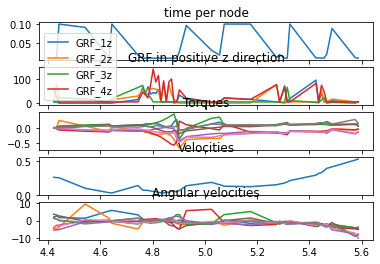

In [30]:
logger.info(results.solver.status) 
logger.info(results.solver.termination_condition) 

# Plotting the stuff --------------------------------------------------
fig, axs = plt.subplots(5)


print(f"theta x: {m.q0[1,'theta_bx'].value}")
print(f"theta y: {m.q0[1,'theta_by'].value}")
print(f"theta z: {m.q0[1,'theta_bz'].value}")


# Time stuff ----------------------------------------------------------
duration=m.tt0[N].value-m.tt0[1].value
print(f"tt0[1]: {m.tt0[1].value}")
print(f"tt0[N]: {m.tt0[N].value}")
print(f"duration: {duration}s")
print(f"final distance covered: {m.q0[N,'x'].value}s")
print(f"average velocity: {m.q0[N,'x'].value/duration}")
print(f"hm: {hm}s") 

time = np.zeros(N)
tt0 = np.zeros(N)
sum_z_vel = 0
min_z_vel = 100
max_z_vel = 0

for i in range(1,N+1):
    time[i-1]=m.h[i].value
    tt0[i-1]=m.tt0[i].value
    sum_z_vel=sum_z_vel+m.dq0[i,'x'].value
    print(f"node {i} duration: {m.h[i].value}")
    if m.dq0[i,'x'].value < min_z_vel:
        min_z_vel=m.dq0[i,'x'].value
    if m.dq0[i,'x'].value > max_z_vel:
        max_z_vel=m.dq0[i,'x'].value

avg_z_vel=sum_z_vel/N
print(f"average z velocity: {avg_z_vel}")
print(f"minimum z velocity: {min_z_vel}")
print(f"maximum z velocity: {max_z_vel}")
    
axs[0].plot(tt0, time)
axs[0].set_title("time per node")

# GRF z ps -------------------------------------------------------------
GRF_1z = np.zeros(N) 
GRF_2z = np.zeros(N) 
GRF_3z = np.zeros(N) 
GRF_4z = np.zeros(N) 
for i in range(1,N+1):
    GRF_1z[i-1]=m.GRF1[i,3,'Z','ps'].value
    GRF_2z[i-1]=m.GRF2[i,3,'Z','ps'].value
    GRF_3z[i-1]=m.GRF3[i,3,'Z','ps'].value
    GRF_4z[i-1]=m.GRF4[i,3,'Z','ps'].value
    
axs[1].plot(tt0, GRF_1z)
axs[1].plot(tt0, GRF_2z)
axs[1].plot(tt0, GRF_3z)
axs[1].plot(tt0, GRF_4z)
axs[1].set_title("GRF in positive z direction")
axs[1].legend(["GRF_1z", "GRF_2z","GRF_3z", "GRF_4z"])

# Torques --------------------------------------------------------------
tau_h1 = np.zeros(N) 
tau_k1 = np.zeros(N) 
tau_h2 = np.zeros(N) 
tau_k2 = np.zeros(N) 
tau_h3 = np.zeros(N) 
tau_k3 = np.zeros(N) 
tau_h4 = np.zeros(N) 
tau_k4 = np.zeros(N)
for i in range(1,N+1):
    tau_h1[i-1]=m.tau_h1[i].value
    tau_k1[i-1]=m.tau_k1[i].value
    tau_h2[i-1]=m.tau_h2[i].value
    tau_k2[i-1]=m.tau_k2[i].value
    tau_h3[i-1]=m.tau_h3[i].value
    tau_k3[i-1]=m.tau_k3[i].value
    tau_h4[i-1]=m.tau_h4[i].value
    tau_k4[i-1]=m.tau_k4[i].value
    
axs[2].plot(tt0, tau_h1)
axs[2].plot(tt0, tau_k1)
axs[2].plot(tt0, tau_h2)
axs[2].plot(tt0, tau_k2)
axs[2].plot(tt0, tau_h3)
axs[2].plot(tt0, tau_k3)
axs[2].plot(tt0, tau_h4)
axs[2].plot(tt0, tau_k4)
axs[2].set_title("Torques")
# axs[2].legend(["tau_h1", "tau_k1","tau_h2", "tau_k2","tau_h3", "tau_k3","tau_h4", "tau_k4"],loc='upper right')

# Velocities --------------------------------------------------------------
v_x = np.zeros(N) 

for i in range(1,N+1):
    v_x[i-1]=m.dq0[i,'x'].value
    
axs[3].plot(tt0, v_x)
axs[3].set_title("Velocities")

# Angular Velocity --------------------------------------------------------------
w_h1 = np.zeros(N) 
w_k1 = np.zeros(N) 
w_h2 = np.zeros(N) 
w_k2 = np.zeros(N) 
w_h3 = np.zeros(N) 
w_k3 = np.zeros(N) 
w_h4 = np.zeros(N) 
w_k4 = np.zeros(N)
for i in range(1,N+1):
    w_h1[i-1]=m.dq0[i,'theta_h1'].value
    w_k1[i-1]=m.dq0[i,'theta_k1'].value
    w_h2[i-1]=m.dq0[i,'theta_h2'].value
    w_k2[i-1]=m.dq0[i,'theta_k2'].value
    w_h3[i-1]=m.dq0[i,'theta_h3'].value
    w_k3[i-1]=m.dq0[i,'theta_k3'].value
    w_h4[i-1]=m.dq0[i,'theta_h4'].value
    w_k4[i-1]=m.dq0[i,'theta_k4'].value
    
axs[4].plot(tt0, w_h1)
axs[4].plot(tt0, w_k1)
axs[4].plot(tt0, w_h2)
axs[4].plot(tt0, w_k2)
axs[4].plot(tt0, w_h3)
axs[4].plot(tt0, w_k3)
axs[4].plot(tt0, w_h4)
axs[4].plot(tt0, w_k4)
axs[4].set_title("Angular velocities")
# axs[4].legend(["h1", "k1","h2", "k2","h3", "k3","h4", "k4"],loc='upper right')


MovieWriter PillowWriter unavailable; using Pillow instead.


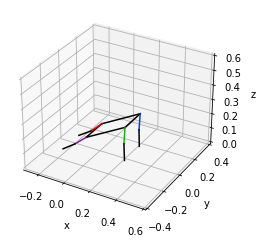

In [31]:
# Animation stuff -------------------------------------------------------
#-----------Print 3D---------------------
fig1 = plt.figure()
ax1 = plt.axes(projection='3d') #create axes

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-0.3, 0.6) 
    ax.set_ylim(-0.4, 0.4)
    ax.set_zlim(-0.0, 0.6);

    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)

    #plot body
    ax.plot([h1[0,0],h2[0,0]],[h1[1,0],h2[1,0]],[h1[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h1[0,0],h3[0,0]],[h1[1,0],h3[1,0]],[h1[2,0],h3[2,0]],color='xkcd:black')
    ax.plot([h4[0,0],h2[0,0]],[h4[1,0],h2[1,0]],[h4[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h3[0,0],h4[0,0]],[h3[1,0],h4[1,0]],[h3[2,0],h4[2,0]],color='xkcd:black')
    
    #Plot Femur 1
    ax.plot([h1[0,0],k1[0,0]],[h1[1,0],k1[1,0]],[h1[2,0],k1[2,0]],color='xkcd:blue')

    #Plot Femur 2
    ax.plot([h2[0,0],k2[0,0]],[h2[1,0],k2[1,0]],[h2[2,0],k2[2,0]],color='xkcd:green')

    #Plot Femur 3
    ax.plot([h3[0,0],k3[0,0]],[h3[1,0],k3[1,0]],[h3[2,0],k3[2,0]],color='xkcd:red')

    #Plot Femur 4
    ax.plot([h4[0,0],k4[0,0]],[h4[1,0],k4[1,0]],[h4[2,0],k4[2,0]],color='xkcd:purple')

    #Plot Tibia 1
    ax.plot([k1[0,0],foot1[0,0]],[k1[1,0],foot1[1,0]],[k1[2,0],foot1[2,0]],color='xkcd:black')

    #Plot Tibia 2
    ax.plot([k2[0,0],foot2[0,0]],[k2[1,0],foot2[1,0]],[k2[2,0],foot2[2,0]],color='xkcd:black')

    #Plot Tibia 3
    ax.plot([k3[0,0],foot3[0,0]],[k3[1,0],foot3[1,0]],[k3[2,0],foot3[2,0]],color='xkcd:black')

    #Plot Tibia 4
    ax.plot([k4[0,0],foot4[0,0]],[k4[1,0],foot4[1,0]],[k4[2,0],foot4[2,0]],color='xkcd:black')
       
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = m.h[i-1].value*hm*10000,repeat=False)
# m.h[i].value*hm*100000
animate.save(r"C:"+path+gait_name+"_3D.gif", writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())

MovieWriter PillowWriter unavailable; using Pillow instead.


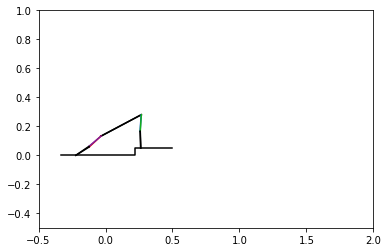

In [32]:
# Animation stuff -------------------------------------------------------
#-----------Print 2D - X-Z ---------------------
fig2,ax2= plt.subplots(1,1) #create axes

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,2])
    ax.set_ylim([-0.5,1.0])
    
    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)
    
   #plot body
    ax.plot([h1[0,0],h2[0,0]],[h1[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h1[0,0],h3[0,0]],[h1[2,0],h3[2,0]],color='xkcd:black')
    ax.plot([h4[0,0],h2[0,0]],[h4[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h3[0,0],h4[0,0]],[h3[2,0],h4[2,0]],color='xkcd:black')
    
    #Plot Femur 1
    ax.plot([h1[0,0],k1[0,0]],[h1[2,0],k1[2,0]],color='xkcd:blue')

    #Plot Femur 2
    ax.plot([h2[0,0],k2[0,0]],[h2[2,0],k2[2,0]],color='xkcd:green')

    #Plot Femur 3
    ax.plot([h3[0,0],k3[0,0]],[h3[2,0],k3[2,0]],color='xkcd:red')

    #Plot Femur 4
    ax.plot([h4[0,0],k4[0,0]],[h4[2,0],k4[2,0]],color='xkcd:purple')

    #Plot Tibia 1
    ax.plot([k1[0,0],foot1[0,0]],[k1[2,0],foot1[2,0]],color='xkcd:black')

    #Plot Tibia 2
    ax.plot([k2[0,0],foot2[0,0]],[k2[2,0],foot2[2,0]],color='xkcd:black')

    #Plot Tibia 3
    ax.plot([k3[0,0],foot3[0,0]],[k3[2,0],foot3[2,0]],color='xkcd:black')

    #Plot Tibia 4
    ax.plot([k4[0,0],foot4[0,0]],[k4[2,0],foot4[2,0]],color='xkcd:black')
    
#     Ground
    ax.plot([-BodyLength,BodyLength/2+dist_from_step,BodyLength/2+dist_from_step,0.5],[0,0,stair_height,stair_height],color='xkcd:black')
       
update = lambda i: plot_robot(i,m,ax2) #lambdify update function

animate = ani.FuncAnimation(fig2,update,range(1,N+1),interval = m.h[i].value*hm*10000,repeat=False)
# m.h[i].value*hm*100000
animate.save(r"C:"+path+gait_name+"_XZ.gif", writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())

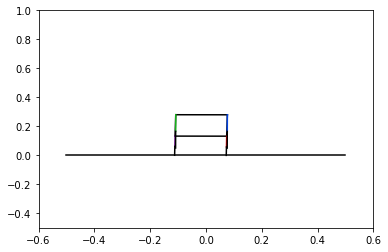

In [33]:
# Animation stuff -------------------------------------------------------
#-----------Print 2D - Y-Z ---------------------
fig3,ax3= plt.subplots(1,1) #create axes

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.6,0.6])
    ax.set_ylim([-0.5,1.0])
    
    rx=[[1, 0, 0], [0, cos(m.q0[i,'theta_bx'].value), -sin(m.q0[i,'theta_bx'].value)], [0, sin(m.q0[i,'theta_bx'].value), cos(m.q0[i,'theta_bx'].value)]]
    ry=[[cos(m.q0[i,'theta_by'].value), 0, sin(m.q0[i,'theta_by'].value)], [0, 1, 0], [-sin(m.q0[i,'theta_by'].value), 0, cos(m.q0[i,'theta_by'].value)]]
    rz=[[cos(m.q0[i,'theta_bz'].value), -sin(m.q0[i,'theta_bz'].value), 0], [sin(m.q0[i,'theta_bz'].value), cos(m.q0[i,'theta_bz'].value), 0], [0, 0, 1]]
    rxy=np.matmul(rx,ry)
    rxyz=np.matmul(rxy,rz)

    Hip11=[[0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip22=[[0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]
    Hip33=[[-0.5*m.l[('body',1)]],[0.5*m.l[('bodyWidth',1)]],[0]]
    Hip44=[[-0.5*m.l[('body',1)]],[-0.5*m.l[('bodyWidth',1)]],[0]]

    Knee11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)]]
    Knee22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)]]
    Knee33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)]]
    Knee44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)]]

    Foot11=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h1'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k1'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h1'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k1'].value)]]
    Foot22=[[0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h2'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k2'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h2'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k2'].value)]]
    Foot33=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h3'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k3'].value)],[0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h3'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k3'].value)]]
    Foot44=[[-0.5*m.l[('body',1)]+m.l[('femur',1)]*sin(m.q0[i,'theta_h4'].value)+m.l[('tibia',1)]*sin(m.q0[i,'theta_k4'].value)],[-0.5*m.l[('bodyWidth',1)]],[-m.l[('femur',1)]*cos(m.q0[i,'theta_h4'].value)-m.l[('tibia',1)]*cos(m.q0[i,'theta_k4'].value)]]

    b = [[m.q0[i,'x'].value],[m.q0[i,'y'].value],[m.q0[i,'z'].value]]

    h1 = b + np.matmul(rxyz,Hip11)
    h2 = b + np.matmul(rxyz,Hip22)
    h3 = b + np.matmul(rxyz,Hip33)
    h4 = b + np.matmul(rxyz,Hip44)

    k1 = b + np.matmul(rxyz,Knee11)
    k2 = b + np.matmul(rxyz,Knee22)
    k3 = b + np.matmul(rxyz,Knee33)
    k4 = b + np.matmul(rxyz,Knee44)

    foot1= b + np.matmul(rxyz,Foot11)
    foot2= b + np.matmul(rxyz,Foot22)
    foot3= b + np.matmul(rxyz,Foot33)
    foot4= b + np.matmul(rxyz,Foot44)
    
    #plot body
    ax.plot([h1[1,0],h2[1,0]],[h1[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h1[1,0],h3[1,0]],[h1[2,0],h3[2,0]],color='xkcd:black')
    ax.plot([h4[1,0],h2[1,0]],[h4[2,0],h2[2,0]],color='xkcd:black')
    ax.plot([h3[1,0],h4[1,0]],[h3[2,0],h4[2,0]],color='xkcd:black')
    
    #Plot Femur 1
    ax.plot([h1[1,0],k1[1,0]],[h1[2,0],k1[2,0]],color='xkcd:blue')

    #Plot Femur 2
    ax.plot([h2[1,0],k2[1,0]],[h2[2,0],k2[2,0]],color='xkcd:green')

    #Plot Femur 3
    ax.plot([h3[1,0],k3[1,0]],[h3[2,0],k3[2,0]],color='xkcd:red')

    #Plot Femur 4
    ax.plot([h4[1,0],k4[1,0]],[h4[2,0],k4[2,0]],color='xkcd:purple')

    #Plot Tibia 1
    ax.plot([k1[1,0],foot1[1,0]],[k1[2,0],foot1[2,0]],color='xkcd:black')

    #Plot Tibia 2
    ax.plot([k2[1,0],foot2[1,0]],[k2[2,0],foot2[2,0]],color='xkcd:black')

    #Plot Tibia 3
    ax.plot([k3[1,0],foot3[1,0]],[k3[2,0],foot3[2,0]],color='xkcd:black')

    #Plot Tibia 4
    ax.plot([k4[1,0],foot4[1,0]],[k4[2,0],foot4[2,0]],color='xkcd:black')
    
#     Ground
    ax.plot([-0.5,0.5],[0,0],color='xkcd:black')
       
update = lambda i: plot_robot(i,m,ax3) #lambdify update function

animate = ani.FuncAnimation(fig3,update,range(1,N+1),interval = m.h[i].value*hm*1000,repeat=False)
# m.h[i].value*hm*100000
# animate.save('YZ_Quad_without_Y_slip.gif', writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())

In [34]:
#SAVING PARAMETERS
import pandas as pd
#Physical properties -----------------------------------------------------------------------------------------------
properties = {'N':[N],'Body Mass':[m.m[('body',1)]],'Femur 1 Mass':[m.m[('femur',1)]],'Tibia 1 Mass':[m.m[('tibia',1)]],'Femur 2 Mass':[m.m[('femur',2)]],
                                    'Tibia 2 Mass':[m.m[('tibia',2)]],'Femur 3 Mass':[m.m[('femur',3)]],'Tibia 3 Mass':[m.m[('tibia',3)]],'Femur 4 Mass':[m.m[('femur',4)]],'Tibia 4 Mass':[m.m[('tibia',4)]],
                                    'Body Length':[m.l[('body',1)]],'Body Width':[m.l[('bodyWidth',1)]],'Femur 1 Length':[m.l[('femur',1)]],'Tibia 1 Length':[m.l[('tibia',1)]],'Femur 2 Length':[m.l[('femur',2)]],'Tibia 2 Length':[m.l[('tibia',2)]],
                                    'Femur 3 Length':[m.l[('femur',3)]],'Tibia 3 Length':[m.l[('tibia',3)]],'Femur 4 Length':[m.l[('femur',4)]],'Tibia 4 Length':[m.l[('tibia',4)]]}
Properties = pd.DataFrame(properties)
Properties.to_csv (r"C:"+path+gait_name+"_3D_Properties.csv", index = False, header=True)

#Torques, node time steps ------------------------------------------------------------------------------------------------------------
torques = {'Node timesteps':[m.h[n].value for n in range (1, N+1)],'Torque Hip 1':[m.tau_h1[n].value for n in range (1, N+1)],'Torque Knee 1':[m.tau_k1[n].value for n in range (1, N+1)],'Torque Hip 2':[m.tau_h2[n].value for n in range (1, N+1)],'Torque Knee 2':[m.tau_k2[n].value for n in range (1, N+1)],
                                    'Torque Hip 3':[m.tau_h3[n].value for n in range (1, N+1)],'Torque Knee 3':[m.tau_k3[n].value for n in range (1, N+1)],'Torque Hip 4':[m.tau_h4[n].value for n in range (1, N+1)],'Torque Knee 4':[m.tau_k4[n].value for n in range (1, N+1)]}
Torques = pd.DataFrame(torques)
Torques.to_csv (r"C:"+path+gait_name+"_3D_Nodal.csv", index = False, header=True)

#Trajectories per collocation point - Angles, Velocities and GRFs - unaltered ----------------------------------------------------------------------------------------
qx = [0 for x in range(N*3)]
qy = [0 for x in range(N*3)]
qz = [0 for x in range(N*3)]
qthx = [0 for x in range(N*3)]
qthy = [0 for x in range(N*3)]
qthz = [0 for x in range(N*3)]
qh1 = [0 for x in range(N*3)]
qk1 = [0 for x in range(N*3)]
qh2 = [0 for x in range(N*3)]
qk2 = [0 for x in range(N*3)]
qh3 = [0 for x in range(N*3)]
qk3 = [0 for x in range(N*3)]
qh4 = [0 for x in range(N*3)]
qk4 = [0 for x in range(N*3)]

dqx = [0 for x in range(N*3)]
dqy = [0 for x in range(N*3)]
dqz = [0 for x in range(N*3)]
dqthx = [0 for x in range(N*3)]
dqthy = [0 for x in range(N*3)]
dqthz = [0 for x in range(N*3)]
dqh1 = [0 for x in range(N*3)]
dqk1 = [0 for x in range(N*3)]
dqh2 = [0 for x in range(N*3)]
dqk2 = [0 for x in range(N*3)]
dqh3 = [0 for x in range(N*3)]
dqk3 = [0 for x in range(N*3)]
dqh4 = [0 for x in range(N*3)]
dqk4 = [0 for x in range(N*3)]

grf1x = [0 for x in range(N*3)]
grf1y = [0 for x in range(N*3)]
grf1z = [0 for x in range(N*3)]
grf2x = [0 for x in range(N*3)]
grf2y = [0 for x in range(N*3)]
grf2z = [0 for x in range(N*3)]
grf3x = [0 for x in range(N*3)]
grf3y = [0 for x in range(N*3)]
grf3z = [0 for x in range(N*3)]
grf4x = [0 for x in range(N*3)]
grf4y = [0 for x in range(N*3)]
grf4z = [0 for x in range(N*3)]

for n in range (1,N+1):
    for c in range (0,3):
        i = n*3-3+c
        qx[i] = m.q[n,c+1,'x'].value
        qy[i] = m.q[n,c+1,'x'].value
        qz[i] = m.q[n,c+1,'z'].value
        qthx[i] = m.q[n,c+1,'theta_bx'].value
        qthy[i] = m.q[n,c+1,'theta_by'].value
        qthz[i] = m.q[n,c+1,'theta_bz'].value
        qh1[i] = m.q[n,c+1,'theta_h1'].value
        qk1[i] = m.q[n,c+1,'theta_k1'].value
        qh2[i] = m.q[n,c+1,'theta_h2'].value
        qk2[i] = m.q[n,c+1,'theta_k2'].value
        qh3[i] = m.q[n,c+1,'theta_h3'].value
        qk3[i] = m.q[n,c+1,'theta_k3'].value
        qh4[i] = m.q[n,c+1,'theta_h4'].value
        qk4[i] = m.q[n,c+1,'theta_k4'].value
        
        dqx[i] = m.dq[n,c+1,'x'].value
        dqy[i] = m.dq[n,c+1,'x'].value
        dqz[i] = m.dq[n,c+1,'z'].value
        dqthx[i] = m.dq[n,c+1,'theta_bx'].value
        dqthy[i] = m.dq[n,c+1,'theta_by'].value
        dqthz[i] = m.dq[n,c+1,'theta_bz'].value
        dqh1[i] = m.dq[n,c+1,'theta_h1'].value
        dqk1[i] = m.dq[n,c+1,'theta_k1'].value
        dqh2[i] = m.dq[n,c+1,'theta_h2'].value
        dqk2[i] = m.dq[n,c+1,'theta_k2'].value
        dqh3[i] = m.dq[n,c+1,'theta_h3'].value
        dqk3[i] = m.dq[n,c+1,'theta_k3'].value
        dqh4[i] = m.dq[n,c+1,'theta_h4'].value
        dqk4[i] = m.dq[n,c+1,'theta_k4'].value
        
        grf1x[i] = m.GRF1[n,c+1,'X','ps'].value-m.GRF1[n,c+1,'X','ng'].value
        grf1y[i] = m.GRF1[n,c+1,'Y','ps'].value-m.GRF1[n,c+1,'Y','ng'].value
        grf1z[i] = m.GRF1[n,c+1,'Z','ps'].value
        grf2x[i] = m.GRF2[n,c+1,'X','ps'].value-m.GRF2[n,c+1,'X','ng'].value
        grf2y[i] = m.GRF2[n,c+1,'Y','ps'].value-m.GRF2[n,c+1,'Y','ng'].value
        grf2z[i] = m.GRF2[n,c+1,'Z','ps'].value
        grf3x[i] = m.GRF3[n,c+1,'X','ps'].value-m.GRF3[n,c+1,'X','ng'].value
        grf3y[i] = m.GRF3[n,c+1,'Y','ps'].value-m.GRF3[n,c+1,'Y','ng'].value
        grf3z[i] = m.GRF3[n,c+1,'Z','ps'].value
        grf4x[i] = m.GRF4[n,c+1,'X','ps'].value-m.GRF4[n,c+1,'X','ng'].value
        grf4y[i] = m.GRF4[n,c+1,'Y','ps'].value-m.GRF4[n,c+1,'Y','ng'].value
        grf4z[i] = m.GRF4[n,c+1,'Z','ps'].value

movement_traj = {'X Position':[qx[i] for i in range (len(qx))],'Y Position':[qy[i] for i in range (len(qy))],'Z Position':[qz[i] for i in range (len(qz))],'Body Angle x':[qthx[i] for i in range (len(qthx))],'Body Angle y':[qthy[i] for i in range (len(qthy))],'Body Angle z':[qthz[i] for i in range (len(qthz))],'Hip 1 Angle':[qh1[i] for i in range (len(qh1))],'Knee 1 Angle':[qk1[i] for i in range (len(qk1))],'Hip 2 Angle':[qh2[i] for i in range (len(qh2))],'Knee 2 Angle':[qk2[i] for i in range (len(qk2))],
           'Hip 3 Angle':[qh3[i] for i in range (len(qh3))],'Knee 3 Angle':[qk3[i] for i in range (len(qk3))],'Hip 4 Angle':[qh4[i] for i in range (len(qh4))],'Knee 4 Angle':[qk4[i] for i in range (len(qk4))],
           'X Velocity':[dqx[i] for i in range (len(dqx))],'Z Velocity':[dqz[i] for i in range (len(dqz))],'Body Velocity x':[dqthx[i] for i in range (len(dqthx))],'Body Velocity y':[dqthy[i] for i in range (len(dqthy))],'Body Velocity z':[dqthz[i] for i in range (len(dqthz))],'Hip 1 Velocity':[dqh1[i] for i in range (len(dqh1))],'Knee 1 Velocity':[dqk1[i] for i in range (len(dqk1))],'Hip 2 Velocity':[dqh2[i] for i in range (len(dqh2))],'Knee 2 Velocity':[dqk2[i] for i in range (len(dqk2))],
           'Hip 3 Velocity':[dqh3[i] for i in range (len(dqh3))],'Knee 3 Velocity':[dqk3[i] for i in range (len(dqk3))],'Hip 4 Velocity':[dqh4[i] for i in range (len(dqh4))],'Knee 4 Velocity':[dqk4[i] for i in range (len(dqk4))],
           'GRF 1x':[grf1x[i] for i in range (len(grf1x))],'GRF 2x':[grf2x[i] for i in range (len(grf2x))],'GRF 3x':[grf3x[i] for i in range (len(grf3x))],'GRF 4x':[grf4x[i] for i in range (len(grf4x))],
           'GRF 1y':[grf1y[i] for i in range (len(grf1y))],'GRF 2y':[grf2y[i] for i in range (len(grf2y))],'GRF 3y':[grf3y[i] for i in range (len(grf3y))],'GRF 4y':[grf4y[i] for i in range (len(grf4y))],
           'GRF 1z':[grf1z[i] for i in range (len(grf1z))],'GRF 2z':[grf2z[i] for i in range (len(grf2z))],'GRF 3z':[grf3z[i] for i in range (len(grf3z))],'GRF 4z':[grf4z[i] for i in range (len(grf4z))]}

Movement_traj = pd.DataFrame(movement_traj)
Movement_traj.to_csv (r"C:"+path+gait_name+"_3D_col_traj.csv", index = False, header=True)

#ROS trajectories per collocation point  - Angles, Velocities and GRFs - altered ----------------------------------------------------------------------------------------
r_qx = [0 for x in range(N*3)]
r_qy = [0 for x in range(N*3)]
r_qz = [0 for x in range(N*3)]
r_qthx = [0 for x in range(N*3)]
r_qthy = [0 for x in range(N*3)]
r_qthz = [0 for x in range(N*3)]
r_qh1 = [0 for x in range(N*3)]
r_qk1 = [0 for x in range(N*3)]
r_qh2 = [0 for x in range(N*3)]
r_qk2 = [0 for x in range(N*3)]
r_qh3 = [0 for x in range(N*3)]
r_qk3 = [0 for x in range(N*3)]
r_qh4 = [0 for x in range(N*3)]
r_qk4 = [0 for x in range(N*3)]
t = [0 for x in range(N*3)]
t_new = [0 for x in range(N*3)]


for n in range (1,N+1):
    for c in range (0,3):
        i = n*3-3+c
        r_qx[i] = m.q[n,c+1,'x'].value
        r_qy[i] = m.q[n,c+1,'y'].value
        r_qz[i] = m.q[n,c+1,'z'].value
        r_qthx[i] = m.q[n,c+1,'theta_bx'].value
        r_qthy[i] = m.q[n,c+1,'theta_by'].value
        r_qthz[i] = m.q[n,c+1,'theta_bz'].value
        r_qh1[i] = m.q[n,c+1,'theta_h1'].value
        r_qk1[i] = m.q[n,c+1,'theta_k1'].value
        r_qh2[i] = m.q[n,c+1,'theta_h2'].value
        r_qk2[i] = m.q[n,c+1,'theta_k2'].value
        r_qh3[i] = m.q[n,c+1,'theta_h3'].value
        r_qk3[i] = m.q[n,c+1,'theta_k3'].value
        r_qh4[i] = m.q[n,c+1,'theta_h4'].value
        r_qk4[i] = m.q[n,c+1,'theta_k4'].value
        t[i] = m.tt[n,c+1].value

for n in range (1,len(t)):
    t_new[n]=t[n]-t[n-1]
t_new[0]=m.h[1].value/3

movement_ros = {'X Position':[r_qx[i] for i in range (len(r_qx))],'Y Position':[r_qy[i] for i in range (len(r_qy))],'Z Position':[r_qz[i] for i in range (len(r_qz))],'Body Angle x':[r_qthx[i] for i in range (len(r_qthx))],'Body Angle y':[r_qthy[i] for i in range (len(r_qthy))],'Body Angle z':[r_qthz[i] for i in range (len(r_qthz))],'Hip 1 Angle':[r_qh1[i] for i in range (len(r_qh1))],'Knee 1 Angle':[r_qk1[i] for i in range (len(r_qk1))],'Hip 2 Angle':[r_qh2[i] for i in range (len(r_qh2))],'Knee 2 Angle':[r_qk2[i] for i in range (len(r_qk2))],
           'Hip 3 Angle':[r_qh3[i] for i in range (len(r_qh3))],'Knee 3 Angle':[r_qk3[i] for i in range (len(r_qk3))],'Hip 4 Angle':[r_qh4[i] for i in range (len(r_qh4))],'Knee 4 Angle':[r_qk4[i] for i in range (len(r_qk4))],'m.tt':[t_new[i] for i in range (len(t))]}

Movement_ros = pd.DataFrame(movement_ros)
Movement_ros.to_csv (r"C:"+path+gait_name+"_3D_col_ros.csv", index = False, header=True)

In [35]:
logger.info("Trajectory Optimisation Completed")
logger.info(f"Distance travelled: {m.q[N,3,'x'].value-m.q[1,1,'x'].value} m")
logger.info(f"Gait Duration: {duration} s")
logger.info(f"velocity (dist/time): {m.q0[N,'x'].value/duration}")
logger.info(f"Final velocity: {m.dq0[N,'x'].value}")
logger.info("-------------------------------------------------------")

[2023-10-15T11:31:12+0200.0538][INFO ][<ipython-input-35-c7f6671dd6ff>] - Trajectory Optimisation Completed
[2023-10-15T11:31:12+0200.0540][INFO ][<ipython-input-35-c7f6671dd6ff>] - Distance travelled: 0.20281898356937872 m
[2023-10-15T11:31:12+0200.0542][INFO ][<ipython-input-35-c7f6671dd6ff>] - Gait Duration: 1.1646647205571927 s
[2023-10-15T11:31:12+0200.0545][INFO ][<ipython-input-35-c7f6671dd6ff>] - velocity (dist/time): 0.09973895087345591
[2023-10-15T11:31:12+0200.0547][INFO ][<ipython-input-35-c7f6671dd6ff>] - Final velocity: 0.5361025976665896
[2023-10-15T11:31:12+0200.0548][INFO ][<ipython-input-35-c7f6671dd6ff>] - -------------------------------------------------------
